<div style="text-align:center;">

<style>
:root {
  --accent: #1e6fd9;
  --card-bg: #F4F8FF;
  --card-border: #E2ECFF;
  --text: #1f2937;
}

.report { max-width: 1100px; margin: 0 auto; font-size:16px; color: var(--text); }
.report h1 { text-align:center; margin: 8px 0 2px; font-weight: 700; }
.report .subtitle { text-align:center; color:#6b7280; margin-bottom: 18px; }
.report .hr { height:1px; background:#e5e7eb; border:0; margin: 12px auto 24px; width: 80%; }

.block { background: var(--card-bg); border:1px solid var(--card-border); border-radius:12px;
         padding: 24px 28px; box-shadow: 0 2px 10px rgba(0,0,0,0.05); }

.columns { display:grid; grid-template-columns: 1fr 1fr; gap:18px; }
@media (max-width: 960px) { .columns { grid-template-columns: 1fr; } }

.card { background: #fff; border:1px solid #e8eefc; border-radius:12px; padding:18px 20px; 
        box-shadow: 0 1px 6px rgba(30,111,217,0.06); text-align:justify; }
.card h3 { margin: 4px 0 10px; font-weight: 700; }
.card .hint { color:#6b7280; font-size: 0.9em; }
.small { font-size: 0.95em; line-height:1.6; }
</style>

<div class="report">
  <h1>Fault Detection, Diagnosis, and Prognosis using PCA, Takens-PCA, CVA, and CVDA </h1>
  <div class="subtitle">Multivariate Process Monitoring • DMW1 Final Project</div>
  <div class="hr"></div>
</div>

</div>

## 1. Introduction & Objective

This notebook continues from the PREPROCESSING & EDA work and assumes that the Tennessee Eastman Process (TEP) data have already been cleaned, validated, and explored. The focus here is no longer on data quality or basic behaviour, but on building a multivariate process monitoring framework that can detect, diagnose, and anticipate faults in an interpretable way.

Concretely, we:

- Learn a normal operating baseline using static PCA, then extend it with dynamic embeddings (Takens-PCA / Enhanced PCA) and state-space methods (CVA, CVDA).

- Construct control statistics (T², Q, and D-index) with data-driven limits to measure how far the process has moved away from normal conditions.

- Quantify fault detection performance per scenario (false alarm rate, detection rate, and detection delay).

- Use contribution analysis and latent trajectories to understand which variables or states drive an alarm and how a fault evolves over time.

Together, these elements turn the descriptive insights from the EDA notebook into a full monitoring workflow that can support real-time surveillance, root-cause analysis, and early-warning decisions in a realistic industrial setting.

## 2. Data Preparation

In this notebook, we start from the cleaned TEP dataset produced in the PREPROCESSING & EDA notebook and reshape it for multivariate monitoring:

*Select variables* Use all XMEAS() and XMV() columns as features and STATUS as the operating-condition label.

*Normal vs. faulty data*
Split the data into:

- Normal (STATUS = 0) for model fitting and false-alarm evaluation.
- Faulty (STATUS ≠ 0), grouped by fault_id for per-fault analysis.

*Time-based train–test split (normal only)*
Sort normal data by time and split into:

- Train-normal (early 70%) to estimate the baseline model.
- Test-normal (late 30%) to measure false alarms.

*Standardization*

Fit a StandardScaler on train-normal features only, then apply it to test-normal and all fault subsets so that PCA, DPCA, Enhanced PCA, CVA, and CVDA all work in the same standardized space.

These standardized matrices form the common starting point for all subsequent detection, diagnosis, and prognosis models.

### 2.1 Load & Inspect

In [340]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.api.types import is_datetime64_any_dtype as is_datetime

from sklearn.preprocessing import StandardScaler

from sklearn.decomposition import PCA
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


import numpy as np
import pandas as pd

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split


In [ ]:
### Load the raw data

file = "TEP_FULL_3YEARS.txt"
df = pd.read_csv(file, sep=";")

print(df.shape)
print(df.columns)
print(df.head())

(525600, 54)
Index(['Unnamed: 0', 'XMEAS(1)', 'XMEAS(2)', 'XMEAS(3)', 'XMEAS(4)',
       'XMEAS(5)', 'XMEAS(6)', 'XMEAS(7)', 'XMEAS(8)', 'XMEAS(9)', 'XMEAS(10)',
       'XMEAS(11)', 'XMEAS(12)', 'XMEAS(13)', 'XMEAS(14)', 'XMEAS(15)',
       'XMEAS(16)', 'XMEAS(17)', 'XMEAS(18)', 'XMEAS(19)', 'XMEAS(20)',
       'XMEAS(21)', 'XMEAS(22)', 'XMEAS(23)', 'XMEAS(24)', 'XMEAS(25)',
       'XMEAS(26)', 'XMEAS(27)', 'XMEAS(28)', 'XMEAS(29)', 'XMEAS(30)',
       'XMEAS(31)', 'XMEAS(32)', 'XMEAS(33)', 'XMEAS(34)', 'XMEAS(35)',
       'XMEAS(36)', 'XMEAS(37)', 'XMEAS(38)', 'XMEAS(39)', 'XMEAS(40)',
       'XMEAS(41)', 'XMV(1)', 'XMV(2)', 'XMV(3)', 'XMV(4)', 'XMV(5)', 'XMV(6)',
       'XMV(7)', 'XMV(8)', 'XMV(9)', 'XMV(10)', 'XMV(11)', 'STATUS'],
      dtype='object')
            Unnamed: 0  XMEAS(1)     XMEAS(2)     XMEAS(3)  XMEAS(4)  \
0  1970-01-01 00:00:00  0.249016  3669.257897  4501.008339  9.449552   
1  1970-01-01 00:03:00  0.249237  3691.240035  4508.871049  9.427162   
2  1970-01-01 00:0

### 2.2 Build a Timestamp and Enforce Time Order

Here we convert the original index column into a proper timestamp, drop the redundant source column, and explicitly sort the dataset by time. This guarantees that all subsequent train–test splits and dynamic models (lags, Hankel blocks, etc.) respect the true temporal order of the process data.

In [342]:
### Create a proper timestamp and sort

# Make a timestamp column
df["timestamp"] = pd.to_datetime(df["Unnamed: 0"])
df = df.drop(columns=["Unnamed: 0"])

# Sort by time
df = df.sort_values("timestamp").reset_index(drop=True)

print(df[["timestamp", "STATUS"]].head())
print(df[["timestamp", "STATUS"]].tail())

            timestamp  STATUS
0 1970-01-01 00:00:00       0
1 1970-01-01 00:03:00       0
2 1970-01-01 00:06:00       0
3 1970-01-01 00:09:00       0
4 1970-01-01 00:12:00       0
                 timestamp  STATUS
525595 1972-12-30 23:45:00      17
525596 1972-12-30 23:48:00      17
525597 1972-12-30 23:51:00      17
525598 1972-12-30 23:54:00      17
525599 1972-12-30 23:57:00      17


# 2.3 Normal vs Faulty Data and Time-Based Split

Here we separate the dataset into normal operation (STATUS = 0) and faulty operation (STATUS ≠ 0) so that only healthy data are used to learn the baseline model.

Within the normal subset, we perform a 70/30 time-based split: the earlier 70% of timestamps form the training set for all monitoring models, and the later 30% serve as held-out normal data to estimate false alarm behaviour under healthy conditions.

In [343]:
### Split into normal vs faulty, then train/test on normal

# Separate Normal vs Faulty Data
df_normal = df[df["STATUS"] == 0].copy()
df_faulty = df[df["STATUS"] != 0].copy()

print(df_normal.shape)
print(df_faulty.shape)

# Time-based TRAIN / TEST split on NORMAL data
split_time = df_normal["timestamp"].quantile(0.7)
print("Time cutoff for train/test:", split_time)

df_train_normal = df_normal[df_normal["timestamp"] <= split_time].copy()
df_test_normal = df_normal[df_normal["timestamp"] > split_time].copy()

print("Train normal:", df_train_normal.shape)
print("Test normal :", df_test_normal.shape)

(264912, 54)
(260688, 54)
Time cutoff for train/test: 1972-01-30 03:50:06
Train normal: (185438, 54)
Test normal : (79474, 54)


###  2.4 Split Normal vs Faulty and Define Train/Test (Normal Only)
In this step, we first split the dataset into normal operation (STATUS = 0) and faulty operation (STATUS ≠ 0). From the normal subset, we then create a time-ordered train/test split using the 70th percentile of the timestamp as the cutoff: the earlier portion is used to learn the baseline “healthy” model, and the later portion provides independent normal data to assess false alarms.

In [344]:
### Group faulty data by fault type & build PCA-ready matrices

# Identify NORMAL vs FAULTY
df_normal = df[df["STATUS"] == 0].copy()
df_faulty = df[df["STATUS"] != 0].copy()

print("===== NORMAL vs FAULTY SPLIT =====")
print(f"Total rows: {len(df):,}")
print(f"Normal rows (STATUS=0): {len(df_normal):,}")
print(f"Faulty rows (!=0): {len(df_faulty):,}")
print()

# Group faulty data by fault type
fault_datasets = {
    fault_id: fdf.copy()
    for fault_id, fdf in df_faulty.groupby("STATUS")
}
print("===== FAULTY DATASETS (PER FAULT) =====")
for fault_id, fdf in fault_datasets.items():
    print(f"Fault {fault_id}: {len(fdf):,} rows")
print()


# Keep only process variables (XMEAS + XMV)
process_cols = [c for c in df.columns if "XMEAS" in c or "XMV" in c]
print("===== PROCESS VARIABLE COUNT =====")
print(f"Total XMEAS + XMV variables: {len(process_cols)}")
print(process_cols)
print()

# PCA-ready datasets
X_train_normal = df_train_normal[process_cols].copy()
X_test_normal = df_test_normal[process_cols].copy()
X_faulty = {fault_id: fdf[process_cols].copy()
            for fault_id, fdf in fault_datasets.items()}

print("===== FINAL PCA-READY SETS =====")
print(f"X_train_normal: {X_train_normal.shape}")
print(f"X_test_normal : {X_test_normal.shape}")
print("\nFaulty PCA-ready sets:")
for fault_id, Xf in X_faulty.items():
    print(f"  Fault {fault_id}: {Xf.shape}")


===== NORMAL vs FAULTY SPLIT =====
Total rows: 525,600
Normal rows (STATUS=0): 264,912
Faulty rows (!=0): 260,688

===== FAULTY DATASETS (PER FAULT) =====
Fault 1: 12,678 rows
Fault 2: 19,181 rows
Fault 3: 14,164 rows
Fault 4: 12,347 rows
Fault 5: 14,176 rows
Fault 6: 1,322 rows
Fault 7: 16,314 rows
Fault 8: 16,189 rows
Fault 9: 17,433 rows
Fault 10: 16,438 rows
Fault 11: 12,300 rows
Fault 12: 869 rows
Fault 13: 11,926 rows
Fault 14: 17,733 rows
Fault 15: 13,945 rows
Fault 16: 14,440 rows
Fault 17: 14,171 rows
Fault 18: 1,011 rows
Fault 19: 14,704 rows
Fault 20: 19,347 rows

===== PROCESS VARIABLE COUNT =====
Total XMEAS + XMV variables: 52
['XMEAS(1)', 'XMEAS(2)', 'XMEAS(3)', 'XMEAS(4)', 'XMEAS(5)', 'XMEAS(6)', 'XMEAS(7)', 'XMEAS(8)', 'XMEAS(9)', 'XMEAS(10)', 'XMEAS(11)', 'XMEAS(12)', 'XMEAS(13)', 'XMEAS(14)', 'XMEAS(15)', 'XMEAS(16)', 'XMEAS(17)', 'XMEAS(18)', 'XMEAS(19)', 'XMEAS(20)', 'XMEAS(21)', 'XMEAS(22)', 'XMEAS(23)', 'XMEAS(24)', 'XMEAS(25)', 'XMEAS(26)', 'XMEAS(27)', 'XMEAS(2

### 1.6 Standardize Features

Here we fit a StandardScaler only on the normal training features to define the baseline mean and variance of healthy operation. The same scaler is then applied to the normal test set and to every fault-specific subset, producing standardized versions of all feature matrices. This ensures that all subsequent models (PCA, dynamic PCA, CVA, CVDA) work in a consistent, comparable feature space anchored on normal behaviour.

In [345]:
### Standardize (fit only on normal train)

print("===== STANDARDIZATION =====")

# Initialize the scaler
scaler = StandardScaler()

# Fit only using NORMAL-TRAIN data
scaler.fit(X_train_normal)
print("Means shape:", scaler.mean_.shape)
print("Stds shape :", scaler.scale_.shape)

# Transform train/test normal sets
X_train_normal_std = pd.DataFrame(
    scaler.transform(X_train_normal),
    columns=X_train_normal.columns,
    index=X_train_normal.index,
)
X_test_normal_std = pd.DataFrame(
    scaler.transform(X_test_normal),
    columns=X_test_normal.columns,
    index=X_test_normal.index,
)

# Transform ALL faulty sets
X_faulty_std = {}
for fault_id, df_fault in X_faulty.items():
    X_faulty_std[fault_id] = pd.DataFrame(
        scaler.transform(df_fault),
        columns=df_fault.columns,
        index=df_fault.index,
    )

print("\nStandardized shapes:")
print("X_train_normal_std:", X_train_normal_std.shape)
print("X_test_normal_std :", X_test_normal_std.shape)
for fault_id, df_fault_std in X_faulty_std.items():
    print(f"Fault {fault_id} standardized: {df_fault_std.shape}")


===== STANDARDIZATION =====
Means shape: (52,)
Stds shape : (52,)

Standardized shapes:
X_train_normal_std: (185438, 52)
X_test_normal_std : (79474, 52)
Fault 1 standardized: (12678, 52)
Fault 2 standardized: (19181, 52)
Fault 3 standardized: (14164, 52)
Fault 4 standardized: (12347, 52)
Fault 5 standardized: (14176, 52)
Fault 6 standardized: (1322, 52)
Fault 7 standardized: (16314, 52)
Fault 8 standardized: (16189, 52)
Fault 9 standardized: (17433, 52)
Fault 10 standardized: (16438, 52)
Fault 11 standardized: (12300, 52)
Fault 12 standardized: (869, 52)
Fault 13 standardized: (11926, 52)
Fault 14 standardized: (17733, 52)
Fault 15 standardized: (13945, 52)
Fault 16 standardized: (14440, 52)
Fault 17 standardized: (14171, 52)
Fault 18 standardized: (1011, 52)
Fault 19 standardized: (14704, 52)
Fault 20 standardized: (19347, 52)


## 3. Preprocessing for Dynamic Methods

To prepare the data for dynamic monitoring methods (Takens-PCA, Enhanced PCA, CVA, CVDA), we augment the standardized features with simple temporal structure. First, we optionally smooth signals using a short moving-average filter to reduce high-frequency noise. Then, we construct lagged versions of the process variables (or Hankel past–future blocks in the CVA/CVDA case), so that each sample encodes not only the current state but also recent history. These dynamic inputs allow the models to capture process memory and detect faults based on trajectory patterns rather than single-point deviations.

In [346]:
# Noise Filtering (Moving Average)

def moving_average_filter(df, window=5):
    """
    Applies a moving average filter to each column of the dataframe.
    Used for Enhanced PCA to smooth noise before lag embedding.
    """
    return df.rolling(window=window, min_periods=1).mean()

In [347]:
X_train_filt = moving_average_filter(X_train_normal_std)
X_test_filt  = moving_average_filter(X_test_normal_std)

X_faulty_filt = {
    fid: moving_average_filter(df) 
    for fid, df in X_faulty_std.items()
}

In [348]:
# Lag Embedding (Takens, Lags=1,2)
def add_lags(df, lags=[1, 2]):
    """
    Creates lag-embedded features for DPCA and Enhanced PCA.
    Example:
        If df has shape (N, 52) and lags=[1,2],
        output shape becomes (N, 52 * 3).
    """
    df_lagged = df.copy()
    for L in lags:
        shifted = df.shift(L)
        shifted.columns = [f"{col}_lag{L}" for col in df.columns]
        df_lagged = pd.concat([df_lagged, shifted], axis=1)

    return df_lagged.dropna().copy()

In [349]:
X_train_lag = add_lags(X_train_normal_std, lags=[1,2])
X_test_lag  = add_lags(X_test_normal_std, lags=[1,2])

X_faulty_lag = {
    fid: add_lags(df, lags=[1,2]) 
    for fid, df in X_faulty_std.items()
}


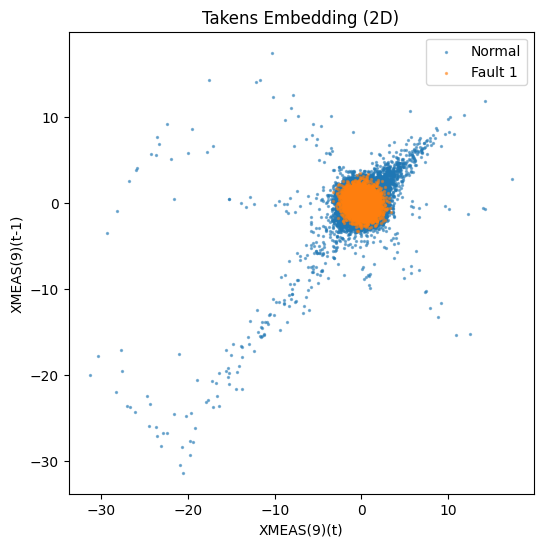

In [350]:
# Takens Embedding EDA (2D/3D Visualization)

# 2D Takens Plot

plt.figure(figsize=(6,6))

plt.scatter(
    X_train_normal_std["XMEAS(9)"].iloc[1:], 
    X_train_normal_std["XMEAS(9)"].shift(1).iloc[1:], 
    s=2, alpha=0.5, label="Normal"
)

plt.scatter(
    X_faulty_std[1]["XMEAS(9)"].iloc[1:], 
    X_faulty_std[1]["XMEAS(9)"].shift(1).iloc[1:], 
    s=2, alpha=0.5, label="Fault 1"
)

plt.xlabel("XMEAS(9)(t)")
plt.ylabel("XMEAS(9)(t-1)")
plt.title("Takens Embedding (2D)")
plt.legend()
plt.show()

## 4. Fault Detection
With the data prepared and standardized, this section evaluates whether the process remains within its learned “normal” operating region or deviates into a fault condition. We apply several multivariate monitoring methods—PCA, dynamic PCA variants, CVA, and CVDA—to compute statistics such as T², Q, and the D-index. These statistics are compared against data-driven control limits derived from normal-operation training data.

Each model is assessed using both held-out normal data (false alarms) and individual fault scenarios (detection rate and detection delay), allowing us to compare how well different approaches identify abnormal behavior as early and reliably as possible.

## 4.1 Static PCA
Static PCA provides the baseline multivariate model for detecting departures from normal operation. Using only the standardized normal-training data, PCA captures the dominant correlation structure among the process variables and defines a low-dimensional “normal subspace.”

Two monitoring statistics are derived from this model: T², which measures variation within the PCA subspace, and Q, which measures reconstruction error outside it. Control limits for both are estimated from held-out normal data, allowing us to flag observations that lie unusually far from normal behavior.

This section uses these limits to evaluate false alarms on normal test data and to measure detection accuracy and detection delay for each fault scenario.

In [351]:
# Fit PCA on normal-only data

# Keep 90% variance
pca_var_explained = 0.90

pca = PCA(n_components=pca_var_explained)
pca.fit(X_train_normal_std)

print("PCA components kept:", pca.n_components_)
print("Explained variance (sum):", pca.explained_variance_ratio_.sum())

PCA components kept: 23
Explained variance (sum): 0.9045744460898163


In [352]:
# Helper functions: scores, T² and Q (SPE)

def compute_pca_scores_and_residuals(X, pca_model):
    """
    Project X into PCA space and compute reconstruction residuals.
    Returns:
        T : scores in PC space
        E : residuals (X - X_reconstructed)
    """
    T = pca_model.transform(X)
    X_recon = pca_model.inverse_transform(T)
    E = X - X_recon
    return T, E


def compute_T2(T, eigenvalues):
    """
    Hotelling's T² statistic for each sample.
    """
    return np.sum((T ** 2) / eigenvalues, axis=1)


def compute_Q(E):
    """
    Squared Prediction Error (Q / SPE) for each sample.
    """
    return np.sum(E ** 2, axis=1)


In [353]:
# Compute T² and Q on Training-Normal + Initial Limits

# Training-normal stats
T_train, E_train = compute_pca_scores_and_residuals(X_train_normal_std, pca)
eigvals = pca.explained_variance_

T2_train = compute_T2(T_train, eigvals)
Q_train = compute_Q(E_train)

# Initial limits using 99% quantile on training-normal
T2_lim = np.quantile(T2_train, 0.99)
Q_lim = np.quantile(Q_train, 0.99)

print("T² limit (99%):", T2_lim)
print("Q limit (99%):", Q_lim)


T² limit (99%): 141.06951273731116
Q limit (99%): 22.3289757421706


In [354]:
# False Alarm Rate on Test-Normal

# Test-normal stats
T_test, E_test = compute_pca_scores_and_residuals(X_test_normal_std, pca)
T2_test = compute_T2(T_test, eigvals)
Q_test = compute_Q(E_test)

fa_T2 = np.mean(T2_test > T2_lim)
fa_Q = np.mean(Q_test > Q_lim)

print("\n=== False Alarm Rate (NORMAL test) ===")
print("T² false alarm rate:", fa_T2)
print("Q false alarm rate:", fa_Q)



=== False Alarm Rate (NORMAL test) ===
T² false alarm rate: 0.010066185167476156
Q false alarm rate: 0.00997810604726074


In [355]:
# Detection Rate per Fault (Initial, no delay yet)

fault_results = {}

print("\n=== Fault Detection Rates (Static PCA) ===")
for fault_id, Xf in X_faulty_std.items():
    T_f, E_f = compute_pca_scores_and_residuals(Xf, pca)
    T2_f = compute_T2(T_f, eigvals)
    Q_f = compute_Q(E_f)

    det_T2 = np.mean(T2_f > T2_lim)
    det_Q = np.mean(Q_f > Q_lim)

    fault_results[fault_id] = (det_T2, det_Q)

    print(f"Fault {fault_id}: T²={det_T2:.3f}, Q={det_Q:.3f}")



=== Fault Detection Rates (Static PCA) ===
Fault 1: T²=0.079, Q=0.977
Fault 2: T²=0.943, Q=0.044
Fault 3: T²=0.000, Q=0.000
Fault 4: T²=0.000, Q=0.231
Fault 5: T²=0.000, Q=0.000
Fault 6: T²=0.473, Q=0.986
Fault 7: T²=0.579, Q=0.027
Fault 8: T²=0.047, Q=0.086
Fault 9: T²=0.000, Q=0.000
Fault 10: T²=0.000, Q=0.000
Fault 11: T²=0.009, Q=0.243
Fault 12: T²=0.003, Q=0.258
Fault 13: T²=0.092, Q=0.497
Fault 14: T²=0.608, Q=0.570
Fault 15: T²=0.000, Q=0.000
Fault 16: T²=0.000, Q=0.000
Fault 17: T²=0.416, Q=0.266
Fault 18: T²=0.046, Q=0.133
Fault 19: T²=0.000, Q=0.000
Fault 20: T²=0.000, Q=0.115


In [356]:
# Improved Control Limits using Validation-Normal

print("\n===== CONTROL LIMITS (Using Validation-Normal) =====")

# Split training-normal into MAIN TRAIN + VALIDATION-NORMAL
X_train_main, X_val_normal = train_test_split(
    X_train_normal_std,
    test_size=0.20,
    shuffle=False   # preserve time order
)

print("Main training set:", X_train_main.shape)
print("Validation-normal:", X_val_normal.shape)

# Refit PCA on main training-only
pca = PCA(n_components=pca_var_explained)
pca.fit(X_train_main)
eigvals = pca.explained_variance_

# Compute T² and Q on validation-normal
T_val, E_val = compute_pca_scores_and_residuals(X_val_normal, pca)
T2_val = compute_T2(T_val, eigvals)
Q_val = compute_Q(E_val)

# Final limits (99% quantile)
T2_lim_final = np.quantile(T2_val, 0.99)
Q_lim_final = np.quantile(Q_val, 0.99)

print("Final T² limit (99%):", T2_lim_final)
print("Final Q limit (99%):", Q_lim_final)



===== CONTROL LIMITS (Using Validation-Normal) =====
Main training set: (148350, 52)
Validation-normal: (37088, 52)
Final T² limit (99%): 170.86870578107968
Final Q limit (99%): 26.03660877481294


In [357]:
# False Alarm Rate + Detection Rate + Detection Delay (Final)

print("\n===== EVALUATION OF STATIC PCA =====")

# False Alarm Rate on test-normal
T_test, E_test = compute_pca_scores_and_residuals(X_test_normal_std, pca)
T2_test = compute_T2(T_test, eigvals)
Q_test = compute_Q(E_test)

fa_T2_final = np.mean(T2_test > T2_lim_final)
fa_Q_final = np.mean(Q_test > Q_lim_final)

print("\n=== FALSE ALARM RATE (Normal Test) ===")
print(f"T² False Alarm Rate: {fa_T2_final:.4f}")
print(f"Q False Alarm Rate: {fa_Q_final:.4f}")

# Fault Detection Rate + Detection Delay
fault_eval = []
print("\n=== FAULT DETECTION PERFORMANCE (Static PCA) ===")

for fault_id, Xf in X_faulty_std.items():
    T_f, E_f = compute_pca_scores_and_residuals(Xf, pca)
    T2_f = compute_T2(T_f, eigvals)
    Q_f = compute_Q(E_f)

    # Detection rates
    det_T2 = np.mean(T2_f > T2_lim_final)
    det_Q = np.mean(Q_f > Q_lim_final)

    # Detection delays (first index where alarm occurs)
    idx_T2 = np.argmax(T2_f > T2_lim_final)
    idx_Q = np.argmax(Q_f > Q_lim_final)

    delay_T2 = idx_T2 if det_T2 > 0 else None
    delay_Q = idx_Q if det_Q > 0 else None

    fault_eval.append({
        "Fault": fault_id,
        "T2_DetectionRate": det_T2,
        "Q_DetectionRate": det_Q,
        "T2_DetectionDelay": delay_T2,
        "Q_DetectionDelay": delay_Q,
    })

    print(
        f"Fault {fault_id:2d} → "
        f"T² DR={det_T2:.3f}, delay={delay_T2} "
        f"Q DR={det_Q:.3f}, delay={delay_Q}"
    )

# Convert to DataFrame for summary
fault_eval_df = pd.DataFrame(fault_eval)
fault_eval_df



===== EVALUATION OF STATIC PCA =====

=== FALSE ALARM RATE (Normal Test) ===
T² False Alarm Rate: 0.0079
Q False Alarm Rate: 0.0084

=== FAULT DETECTION PERFORMANCE (Static PCA) ===
Fault  1 → T² DR=0.018, delay=50 Q DR=0.971, delay=18
Fault  2 → T² DR=0.939, delay=43 Q DR=0.012, delay=64
Fault  3 → T² DR=0.000, delay=None Q DR=0.000, delay=None
Fault  4 → T² DR=0.000, delay=None Q DR=0.026, delay=87
Fault  5 → T² DR=0.000, delay=None Q DR=0.000, delay=None
Fault  6 → T² DR=0.360, delay=48 Q DR=0.981, delay=2
Fault  7 → T² DR=0.220, delay=10 Q DR=0.007, delay=3
Fault  8 → T² DR=0.018, delay=85 Q DR=0.044, delay=55
Fault  9 → T² DR=0.000, delay=None Q DR=0.000, delay=None
Fault 10 → T² DR=0.000, delay=None Q DR=0.000, delay=None
Fault 11 → T² DR=0.002, delay=146 Q DR=0.189, delay=6
Fault 12 → T² DR=0.002, delay=20 Q DR=0.167, delay=11
Fault 13 → T² DR=0.031, delay=116 Q DR=0.425, delay=35
Fault 14 → T² DR=0.531, delay=1 Q DR=0.611, delay=3
Fault 15 → T² DR=0.000, delay=None Q DR=0.000,

Fault  T2_DetectionRate  Q_DetectionRate  T2_DetectionDelay  \
0       1          0.018378         0.971368               50.0   
1       2          0.939263         0.012252               43.0   
2       3          0.000000         0.000000                NaN   
3       4          0.000000         0.025593                NaN   
4       5          0.000000         0.000000                NaN   
5       6          0.360061         0.981089               48.0   
6       7          0.219995         0.007478               10.0   
7       8          0.017543         0.043919               85.0   
8       9          0.000000         0.000000                NaN   
9      10          0.000000         0.000000                NaN   
10     11          0.002114         0.188537              146.0   
11     12          0.002301         0.166858               20.0   
12     13          0.031192         0.425122              116.0   
13     14          0.531157         0.610895                1.0   
14     15          0.000000         0.000000                NaN   
15     16          0.000000         0.000000                NaN   
16     17          0.373086         0.436525               81.0   
17     18          0.047478         0.094955              162.0   
18     19          0.000000         0.000136                NaN   
19     20          0.000000         0.087455                NaN   

    Q_DetectionDelay  
0               18.0  
1               64.0  
2                NaN  
3               87.0  
4                NaN  
5                2.0  
6                3.0  
7               55.0  
8                NaN  
9                NaN  
10               6.0  
11              11.0  
12              35.0  
13               3.0  
14               NaN  
15               NaN  
16              79.0  
17             152.0  
18            5813.0  
19              91.0

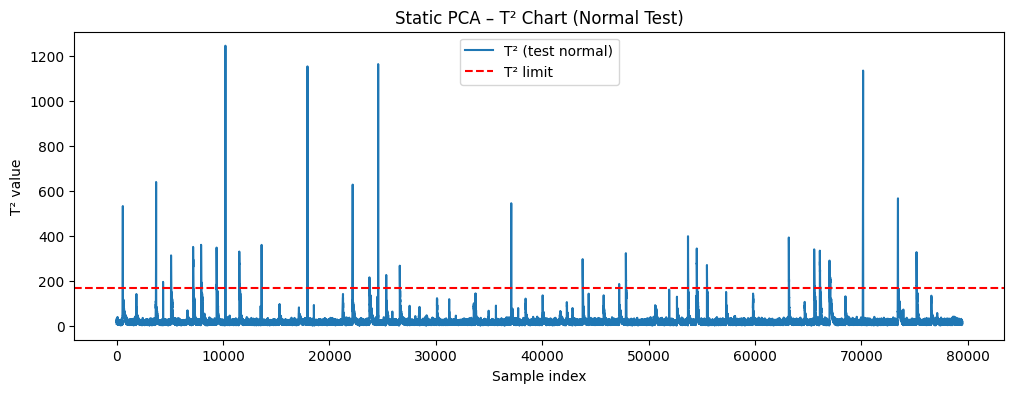

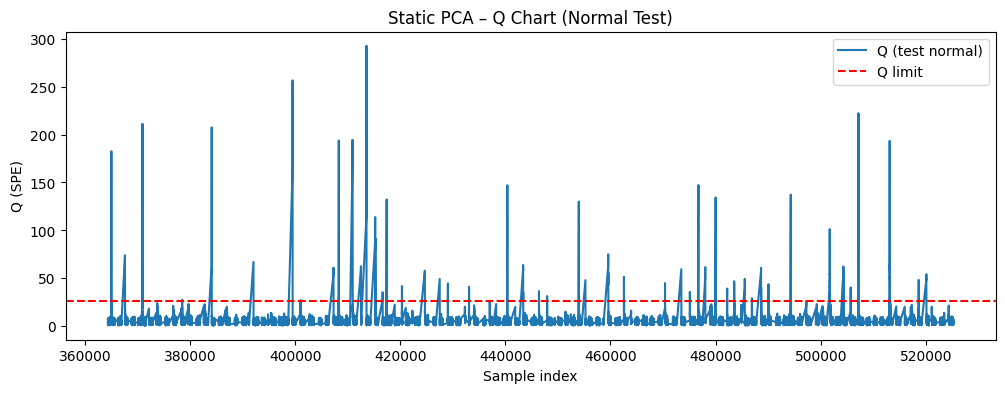

In [358]:
# Simple Visualizations

plt.figure(figsize=(12, 4))
plt.plot(T2_test, label="T² (test normal)")
plt.axhline(T2_lim_final, color="red", linestyle="--", label="T² limit")
plt.title("Static PCA – T² Chart (Normal Test)")
plt.xlabel("Sample index")
plt.ylabel("T² value")
plt.legend()
plt.show()

plt.figure(figsize=(12, 4))
plt.plot(Q_test, label="Q (test normal)")
plt.axhline(Q_lim_final, color="red", linestyle="--", label="Q limit")
plt.title("Static PCA – Q Chart (Normal Test)")
plt.xlabel("Sample index")
plt.ylabel("Q (SPE)")
plt.legend()
plt.show()


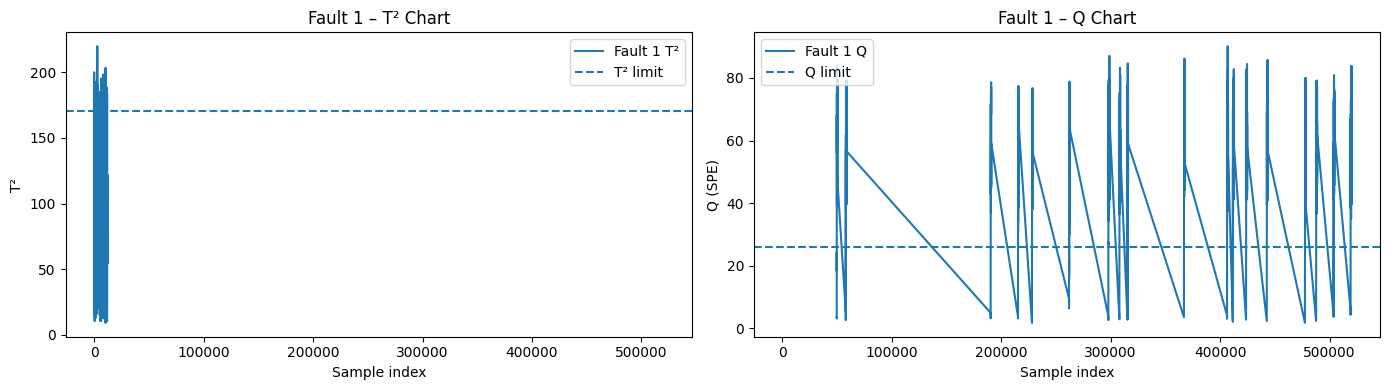

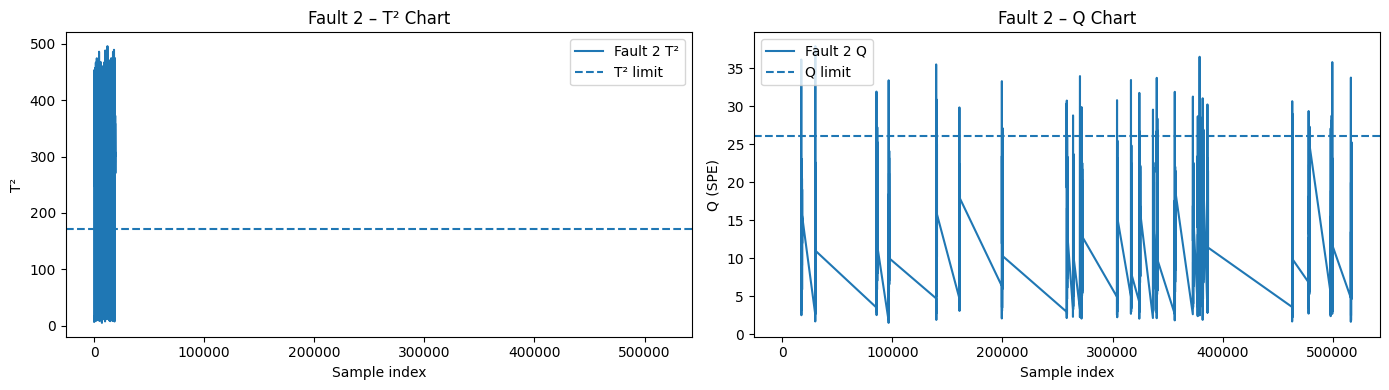

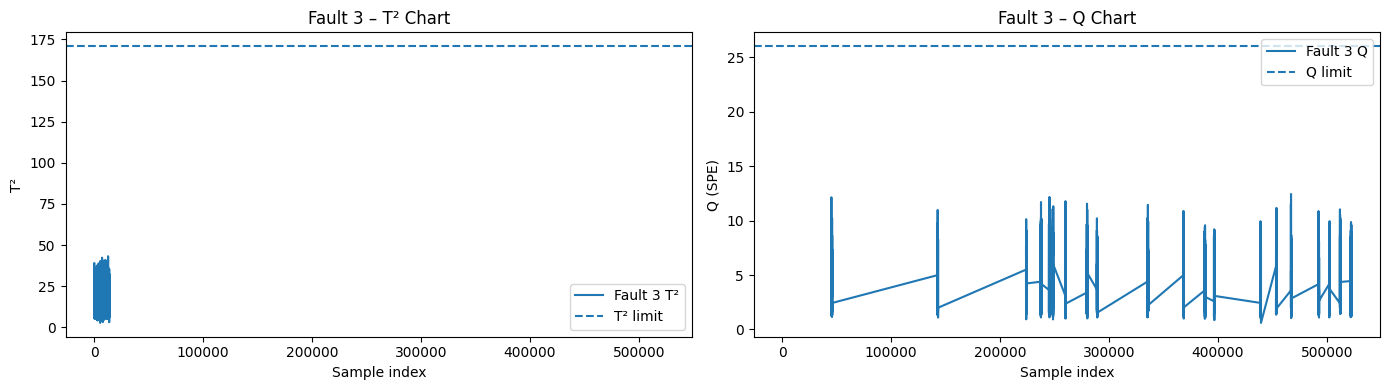

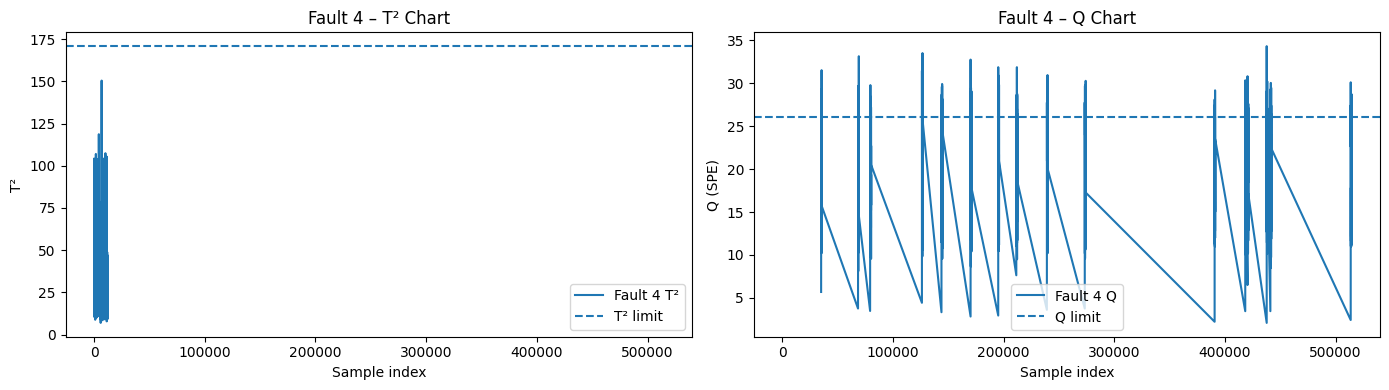

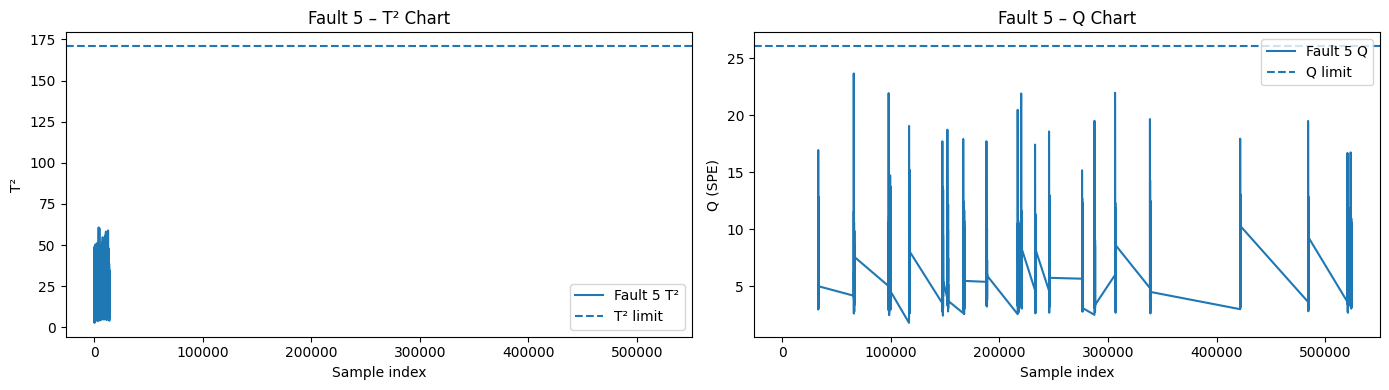

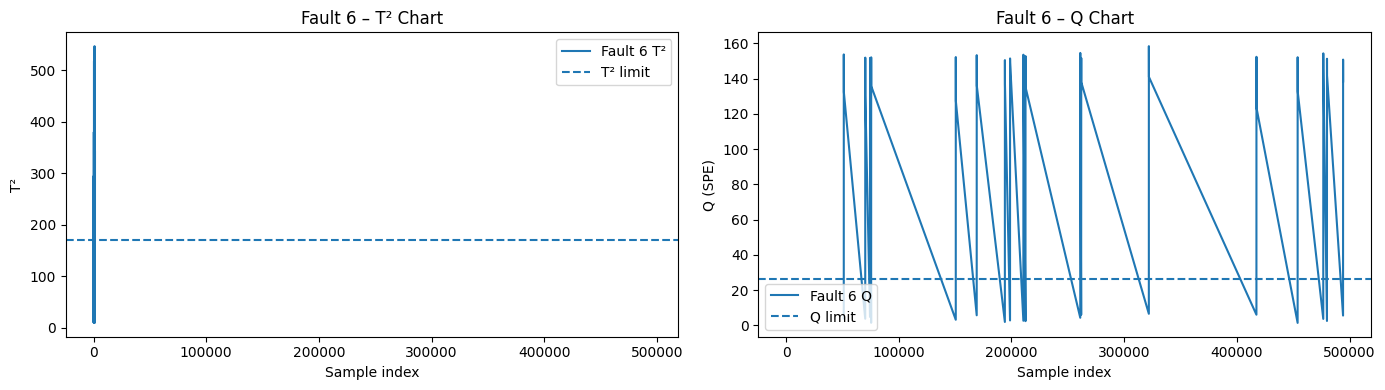

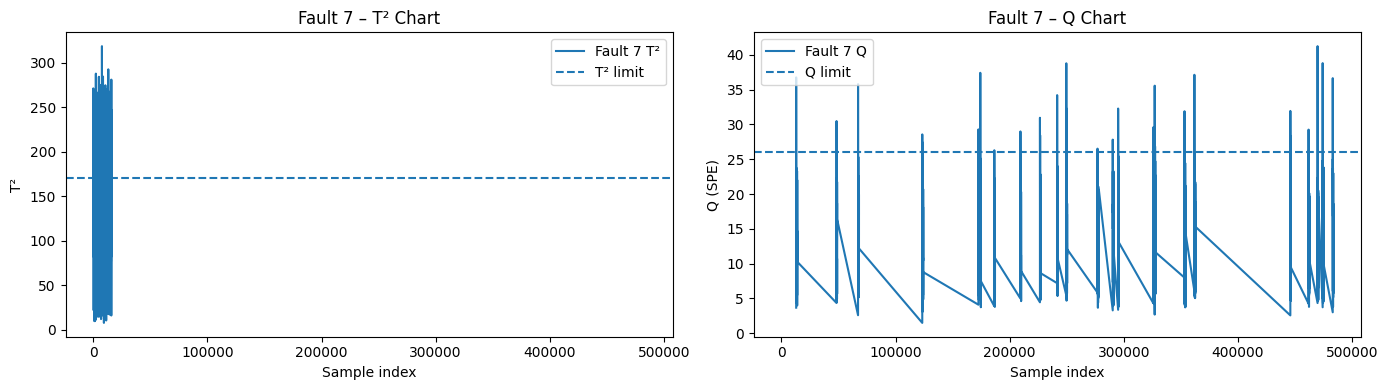

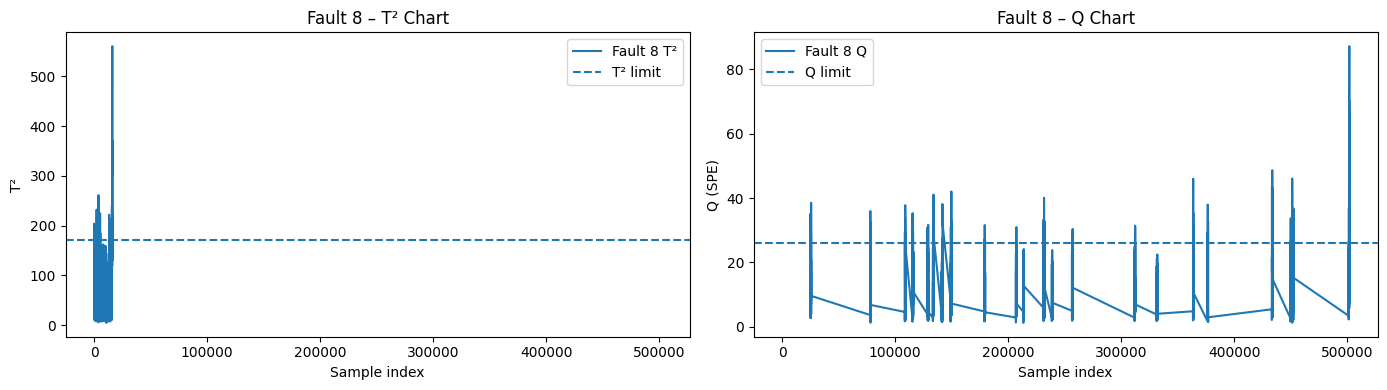

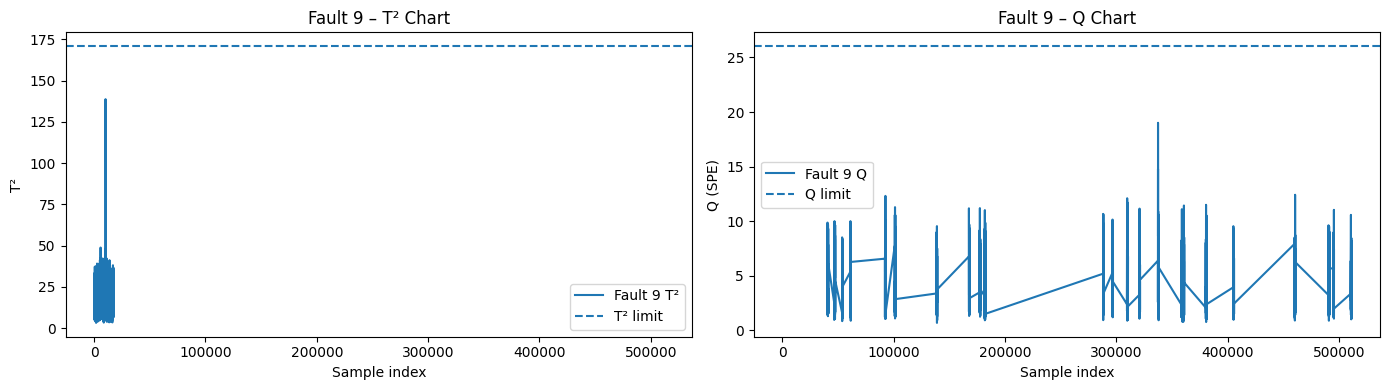

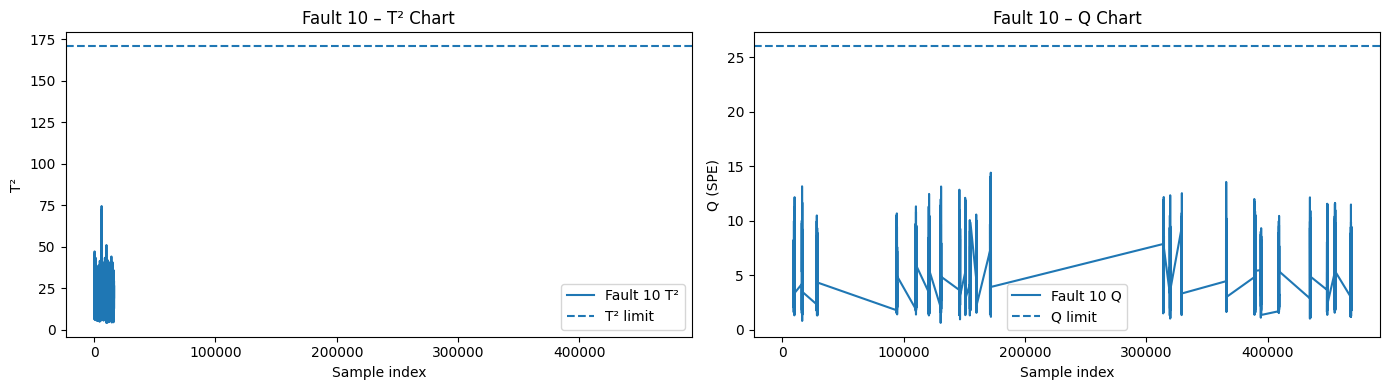

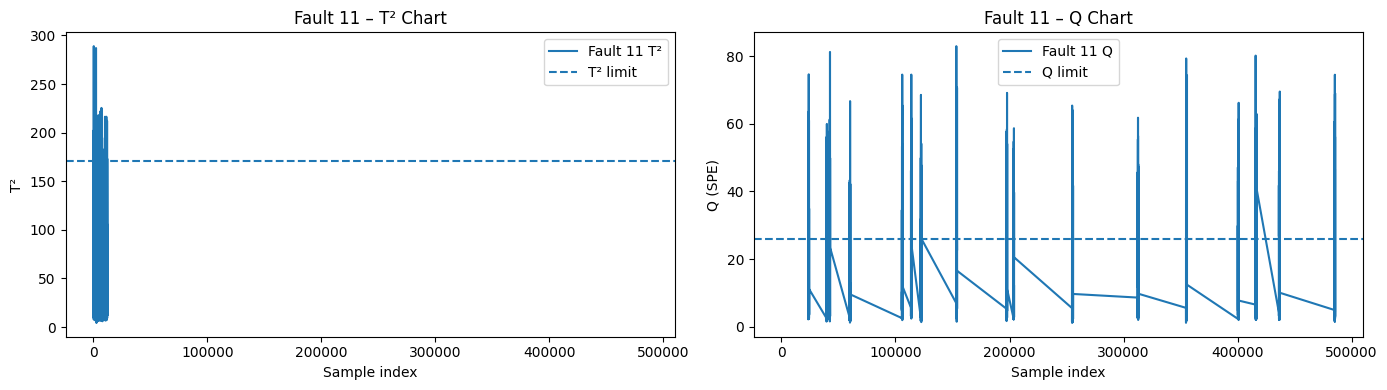

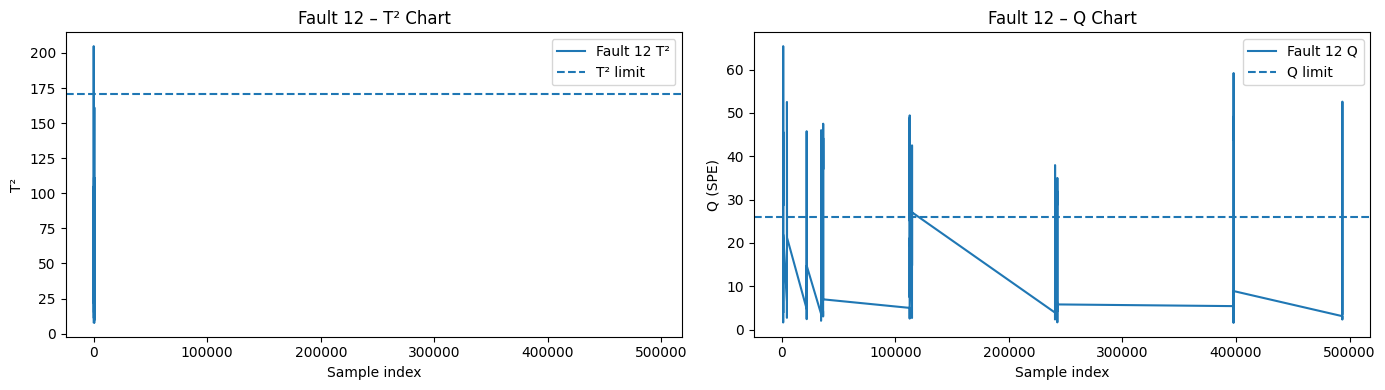

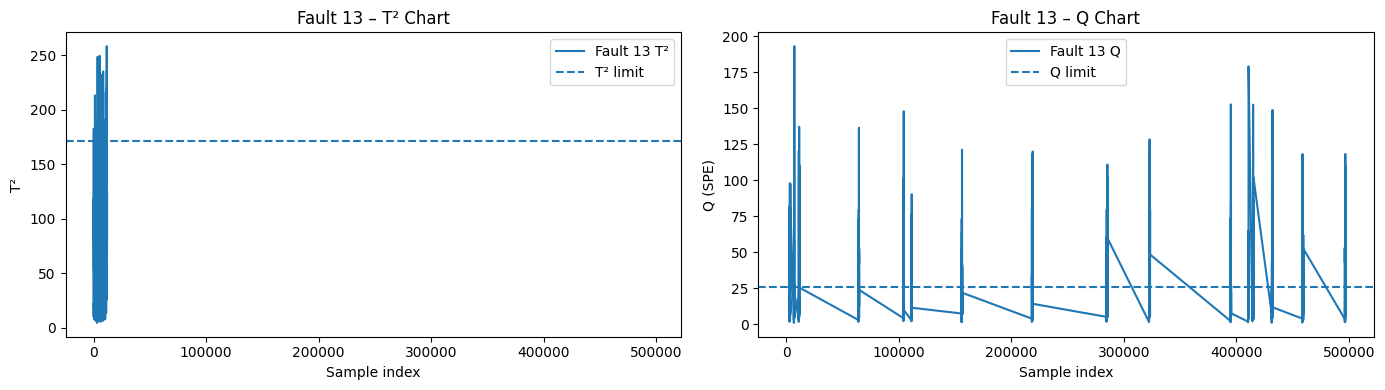

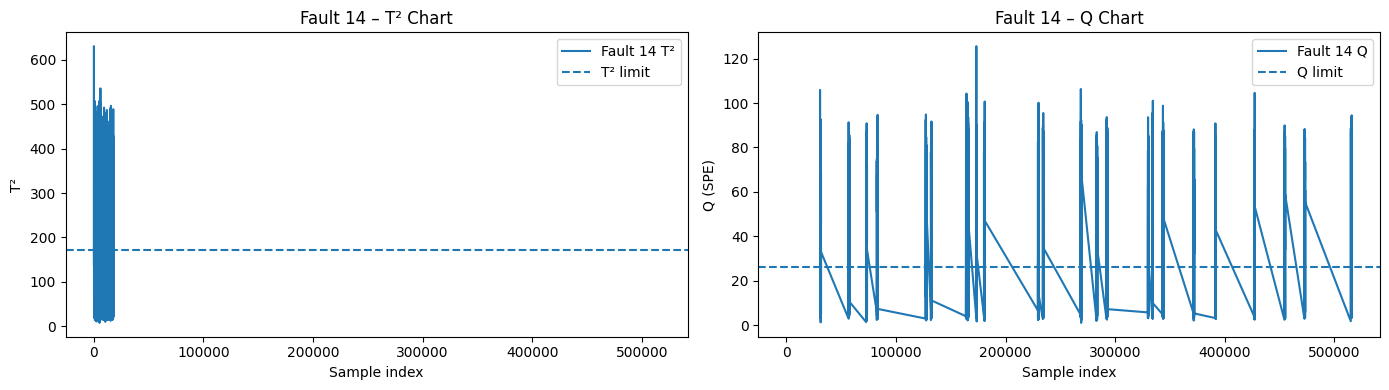

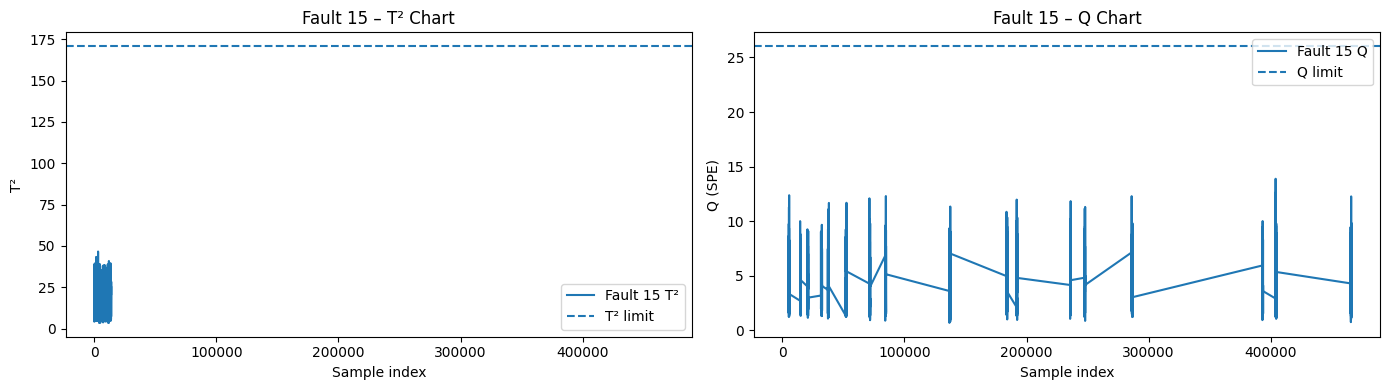

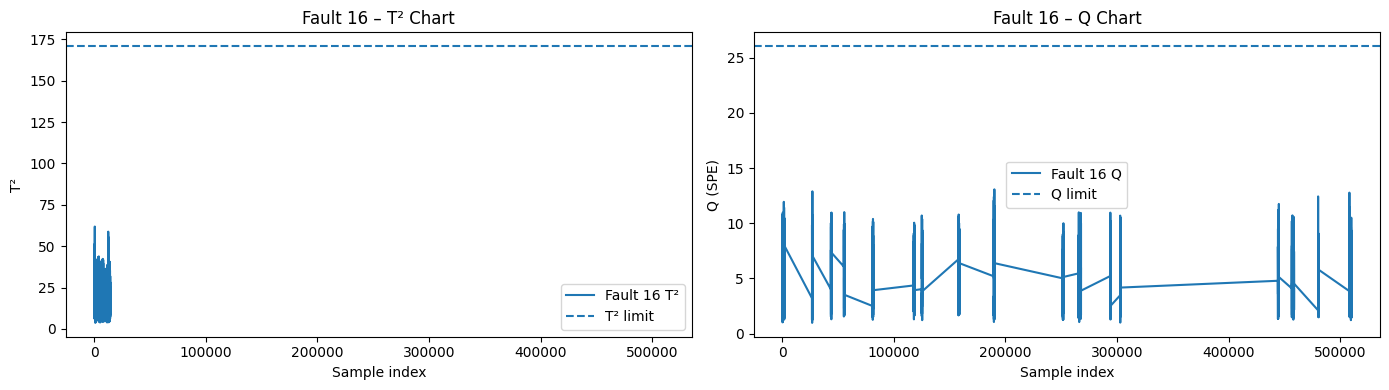

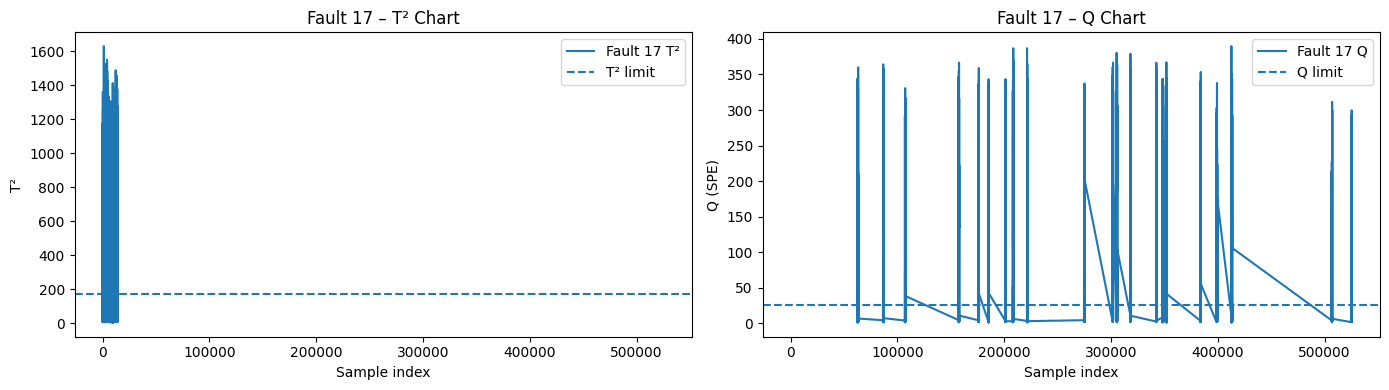

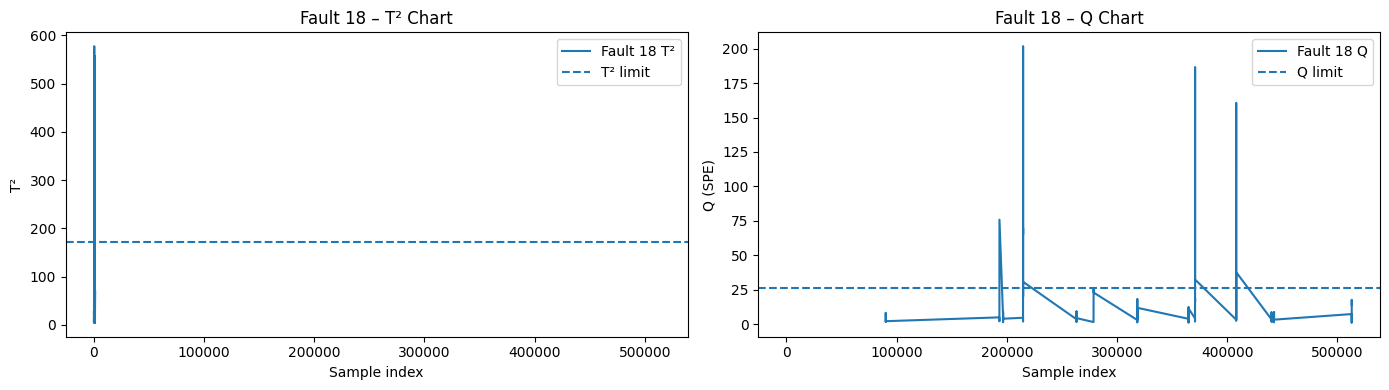

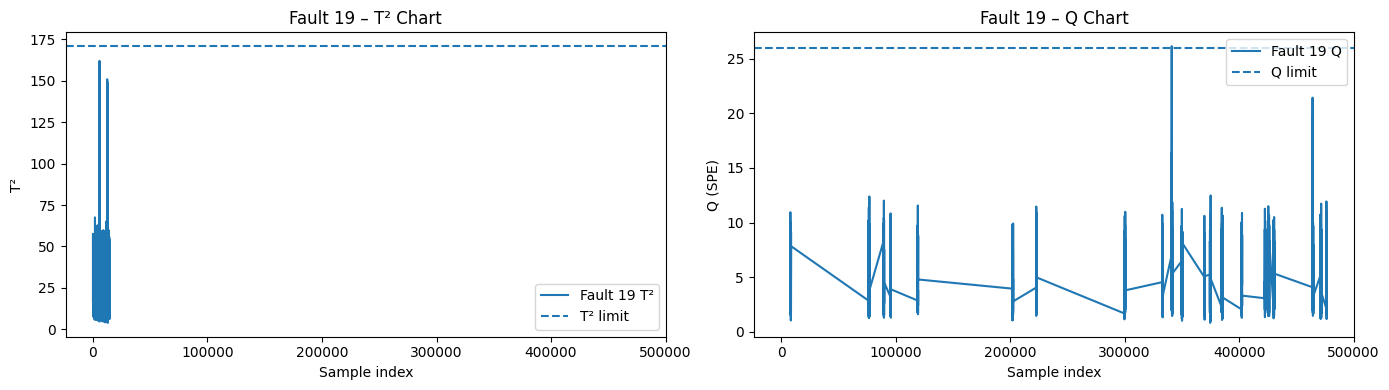

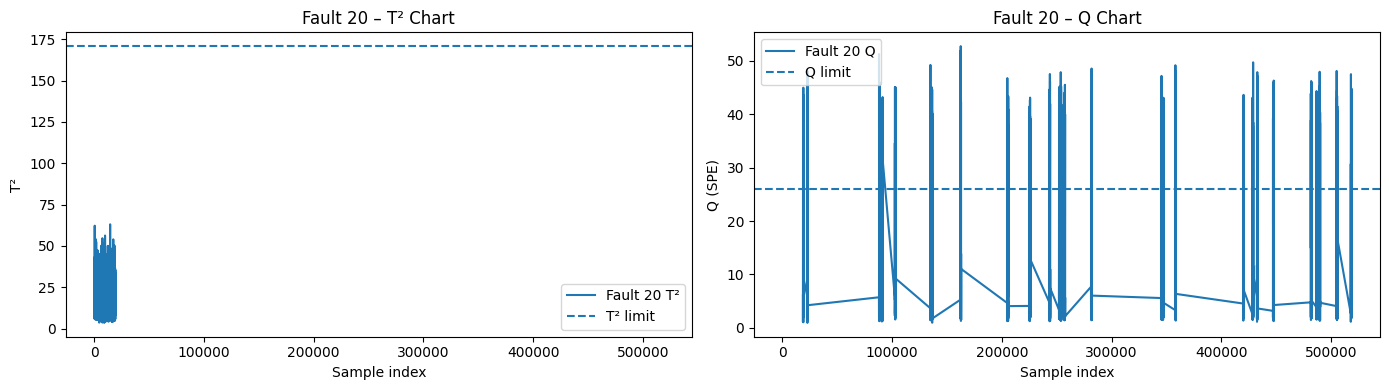

In [359]:

def plot_fault_pca_charts(fault_id):
    Xf = X_faulty_std[fault_id]
    T_f, E_f = compute_pca_scores_and_residuals(Xf, pca)
    T2_f = compute_T2(T_f, eigvals)
    Q_f = compute_Q(E_f)

    fig, axes = plt.subplots(1, 2, figsize=(14, 4), sharex=True)

    axes[0].plot(T2_f, label=f"Fault {fault_id} T²")
    axes[0].axhline(T2_lim_final, linestyle="--", label="T² limit")
    axes[0].set_title(f"Fault {fault_id} – T² Chart")
    axes[0].set_xlabel("Sample index")
    axes[0].set_ylabel("T²")
    axes[0].legend()

    axes[1].plot(Q_f, label=f"Fault {fault_id} Q")
    axes[1].axhline(Q_lim_final, linestyle="--", label="Q limit")
    axes[1].set_title(f"Fault {fault_id} – Q Chart")
    axes[1].set_xlabel("Sample index")
    axes[1].set_ylabel("Q (SPE)")
    axes[1].legend()

    plt.tight_layout()
    plt.show()

# Example: visualize a couple of faults
for f in range(1,21):
    plot_fault_pca_charts(f)




### 4.2 Takens-PCA / DPCA
Takens-PCA extends static PCA by incorporating short-term history into each sample through lagged variables. This creates a dynamic feature set that captures the temporal dependencies inherent in process data—information that static PCA cannot represent.

After constructing the lag-embedded inputs, PCA is fitted on the normal-training segment, and dynamic T² and Q limits are established from held-out normal data. These limits allow the model to detect faults based on deviations in trajectory rather than instantaneous behaviour.

This section compares DPCA’s false-alarm rate and fault detection performance against static PCA, highlighting whether the added temporal structure enables earlier or more reliable detection.

In [360]:
# Build lag-embedded data for DPCA

def add_lags(df, L=2):
    """
    Add L lagged versions of each column.

    Example:
    --------
    If df has shape (N, p) and L=2, the result contains:
        - original columns at time t
        - lag-1 columns  (t-1)
        - lag-2 columns  (t-2)
    and has shape (N - L, p * (L+1)).
    """
    df_lagged = df.copy()
    for lag in range(1, L + 1):
        shifted = df.shift(lag)
        shifted.columns = [f"{col}_lag{lag}" for col in df.columns]
        df_lagged = pd.concat([df_lagged, shifted], axis=1)

    # Drop first L rows with NaNs due to shifting
    return df_lagged.dropna().copy()


# Embedding length: current + 2 past steps
L = 2
print(f"Using embedding length L = {L} (current + {L} past steps)")

# --------------------------------------------------
# Build DPCA inputs for NORMAL data
# --------------------------------------------------
X_train_dpca = add_lags(X_train_normal_std, L=L)
X_test_dpca = add_lags(X_test_normal_std, L=L)

print("Original train_normal shape:", X_train_normal_std.shape)
print("DPCA train shape          :", X_train_dpca.shape)
print("Original test_normal shape:", X_test_normal_std.shape)
print("DPCA test shape           :", X_test_dpca.shape)

# --------------------------------------------------
# Build DPCA inputs for each FAULTY dataset
# --------------------------------------------------
X_faulty_dpca = {}
for fault_id, Xf in X_faulty_std.items():
    X_faulty_dpca[fault_id] = add_lags(Xf, L=L)
    print(
        f"Fault {fault_id:2d}: original {Xf.shape} "
        f"→ DPCA {X_faulty_dpca[fault_id].shape}"
    )


Using embedding length L = 2 (current + 2 past steps)
Original train_normal shape: (185438, 52)
DPCA train shape          : (185436, 156)
Original test_normal shape: (79474, 52)
DPCA test shape           : (79472, 156)
Fault  1: original (12678, 52) → DPCA (12676, 156)
Fault  2: original (19181, 52) → DPCA (19179, 156)
Fault  3: original (14164, 52) → DPCA (14162, 156)
Fault  4: original (12347, 52) → DPCA (12345, 156)
Fault  5: original (14176, 52) → DPCA (14174, 156)
Fault  6: original (1322, 52) → DPCA (1320, 156)
Fault  7: original (16314, 52) → DPCA (16312, 156)
Fault  8: original (16189, 52) → DPCA (16187, 156)
Fault  9: original (17433, 52) → DPCA (17431, 156)
Fault 10: original (16438, 52) → DPCA (16436, 156)
Fault 11: original (12300, 52) → DPCA (12298, 156)
Fault 12: original (869, 52) → DPCA (867, 156)
Fault 13: original (11926, 52) → DPCA (11924, 156)
Fault 14: original (17733, 52) → DPCA (17731, 156)
Fault 15: original (13945, 52) → DPCA (13943, 156)
Fault 16: original (14

In [361]:
print("\n===== Dynamic PCA (DPCA using Takens Embedding) =====")
pca_dpca = PCA(n_components=0.90) 
pca_dpca.fit(X_train_dpca)

print("DPCA components kept:", pca_dpca.n_components_)
print("DPCA explained variance (sum):", pca_dpca.explained_variance_ratio_.sum())

T_train_dpca, E_train_dpca = compute_pca_scores_and_residuals(
    X_train_dpca, pca_dpca
)
eigvals_dpca = pca_dpca.explained_variance_

T2_train_dpca = compute_T2(T_train_dpca, eigvals_dpca)
Q_train_dpca = compute_Q(E_train_dpca)

# DPCA control limits (99% quantile on training-normal)
T2_lim_dpca = np.quantile(T2_train_dpca, 0.99)
Q_lim_dpca = np.quantile(Q_train_dpca, 0.99)

print("\nDPCA T² limit (99%):", T2_lim_dpca)
print("DPCA Q limit  (99%):", Q_lim_dpca)


===== Dynamic PCA (DPCA using Takens Embedding) =====
DPCA components kept: 46
DPCA explained variance (sum): 0.9035646390689274

DPCA T² limit (99%): 217.02734780488743
DPCA Q limit  (99%): 37.388377870699664


In [362]:
# False Alarm Rate (normal test) + Detection Rate & Delay per fault

T_test_dpca, E_test_dpca = compute_pca_scores_and_residuals(
    X_test_dpca, pca_dpca
)
T2_test_dpca = compute_T2(T_test_dpca, eigvals_dpca)
Q_test_dpca = compute_Q(E_test_dpca)

fa_T2_dpca = np.mean(T2_test_dpca > T2_lim_dpca)
fa_Q_dpca = np.mean(Q_test_dpca > Q_lim_dpca)

print("\n=== DPCA FALSE ALARM RATE (Normal Test) ===")
print(f"DPCA T² False Alarm Rate: {fa_T2_dpca:.4f}")
print(f"DPCA Q  False Alarm Rate: {fa_Q_dpca:.4f}")

def detection_delay(sequence, limit):
    """
    Return the index of the first sample that exceeds 'limit'.
    If no sample exceeds the limit, return None.
    """
    idx = np.where(sequence > limit)[0]
    return None if len(idx) == 0 else int(idx[0])

fault_results_dpca = []

print("\n=== DPCA FAULT DETECTION PERFORMANCE ===")
for fault_id, Xf_dpca in X_faulty_dpca.items():
    T_f, E_f = compute_pca_scores_and_residuals(Xf_dpca, pca_dpca)
    T2_f = compute_T2(T_f, eigvals_dpca)
    Q_f = compute_Q(E_f)

    det_T2 = np.mean(T2_f > T2_lim_dpca)
    det_Q = np.mean(Q_f > Q_lim_dpca)

    delay_T2 = detection_delay(T2_f, T2_lim_dpca) if det_T2 > 0 else None
    delay_Q = detection_delay(Q_f, Q_lim_dpca) if det_Q > 0 else None

    print(
        f"Fault {fault_id:2d} → "
        f"T² DR={det_T2:.3f}, delay={delay_T2} | "
        f"Q DR={det_Q:.3f}, delay={delay_Q}"
    )

    fault_results_dpca.append(
        {
            "Fault": fault_id,
            "T2_DetectionRate": det_T2,
            "Q_DetectionRate": det_Q,
            "T2_DetectionDelay": delay_T2,
            "Q_DetectionDelay": delay_Q,
        }
    )

df_dpca_results = pd.DataFrame(fault_results_dpca)
print("\n===== DPCA Detection Summary =====")
df_dpca_results


=== DPCA FALSE ALARM RATE (Normal Test) ===
DPCA T² False Alarm Rate: 0.0100
DPCA Q  False Alarm Rate: 0.0107

=== DPCA FAULT DETECTION PERFORMANCE ===
Fault  1 → T² DR=0.947, delay=25 | Q DR=0.785, delay=12
Fault  2 → T² DR=0.943, delay=41 | Q DR=0.008, delay=62
Fault  3 → T² DR=0.000, delay=None | Q DR=0.000, delay=1448
Fault  4 → T² DR=0.000, delay=None | Q DR=1.000, delay=0
Fault  5 → T² DR=0.000, delay=None | Q DR=0.004, delay=504
Fault  6 → T² DR=0.436, delay=44 | Q DR=1.000, delay=0
Fault  7 → T² DR=0.998, delay=1 | Q DR=0.997, delay=0
Fault  8 → T² DR=0.041, delay=83 | Q DR=0.035, delay=74
Fault  9 → T² DR=0.000, delay=None | Q DR=0.001, delay=5437
Fault 10 → T² DR=0.000, delay=None | Q DR=0.001, delay=1449
Fault 11 → T² DR=0.020, delay=27 | Q DR=0.602, delay=3
Fault 12 → T² DR=0.008, delay=19 | Q DR=0.433, delay=9
Fault 13 → T² DR=0.252, delay=43 | Q DR=0.376, delay=31
Fault 14 → T² DR=0.749, delay=0 | Q DR=0.742, delay=0
Fault 15 → T² DR=0.000, delay=None | Q DR=0.000, delay

Fault  T2_DetectionRate  Q_DetectionRate  T2_DetectionDelay  \
0       1          0.947381         0.784553               25.0   
1       2          0.942698         0.007665               41.0   
2       3          0.000000         0.000282                NaN   
3       4          0.000000         1.000000                NaN   
4       5          0.000000         0.003528                NaN   
5       6          0.435606         1.000000               44.0   
6       7          0.997670         0.996812                1.0   
7       8          0.041391         0.034781               83.0   
8       9          0.000000         0.000574                NaN   
9      10          0.000000         0.000791                NaN   
10     11          0.019922         0.602374               27.0   
11     12          0.008074         0.432526               19.0   
12     13          0.251761         0.376468               43.0   
13     14          0.748971         0.742485                0.0   
14     15          0.000000         0.000359                NaN   
15     16          0.000000         0.001039                NaN   
16     17          0.435458         0.168890               79.0   
17     18          0.073340         0.093162              154.0   
18     19          0.000000         0.001088                NaN   
19     20          0.000000         0.239442                NaN   

    Q_DetectionDelay  
0                 12  
1                 62  
2               1448  
3                  0  
4                504  
5                  0  
6                  0  
7                 74  
8               5437  
9               1449  
10                 3  
11                 9  
12                31  
13                 0  
14              4572  
15               594  
16                92  
17               156  
18               460  
19                79

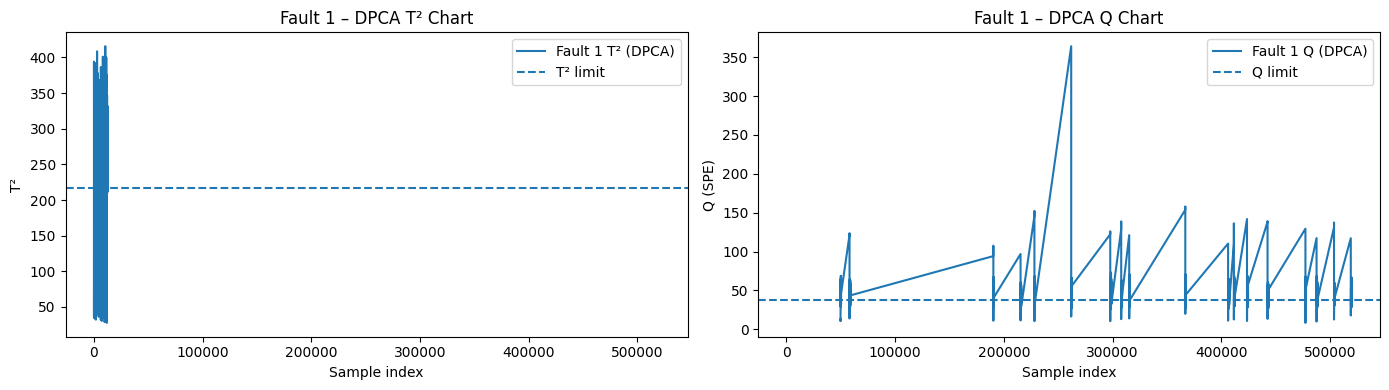

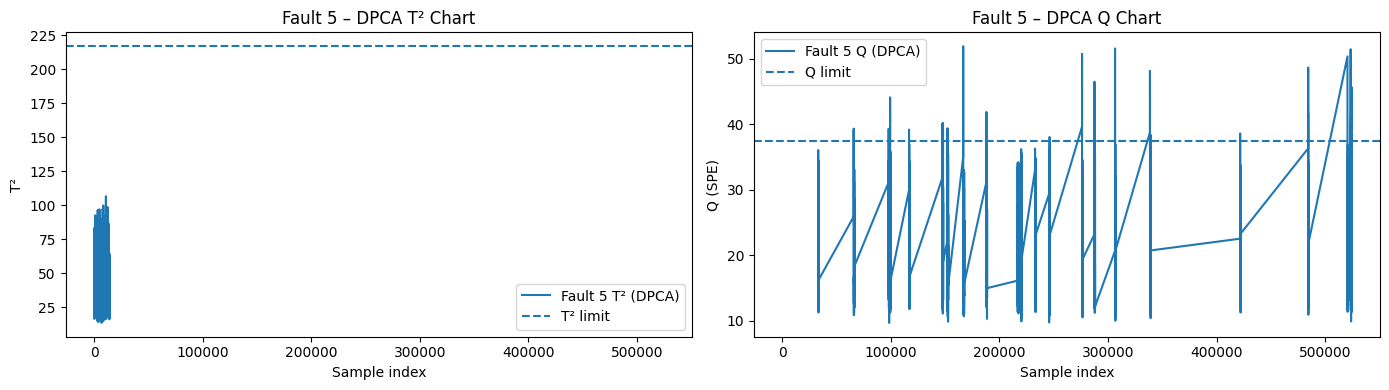

In [363]:
# DPCA T²/Q charts for a specific fault

def plot_fault_dpca_charts(fault_id):
    """
    Plot DPCA T² and Q charts for a given fault.
    """
    Xf_dpca = X_faulty_dpca[fault_id]
    T_f, E_f = compute_pca_scores_and_residuals(Xf_dpca, pca_dpca)
    T2_f = compute_T2(T_f, eigvals_dpca)
    Q_f = compute_Q(E_f)

    fig, axes = plt.subplots(1, 2, figsize=(14, 4), sharex=True)

    axes[0].plot(T2_f, label=f"Fault {fault_id} T² (DPCA)")
    axes[0].axhline(T2_lim_dpca, linestyle="--", label="T² limit")
    axes[0].set_title(f"Fault {fault_id} – DPCA T² Chart")
    axes[0].set_xlabel("Sample index")
    axes[0].set_ylabel("T²")
    axes[0].legend()

    axes[1].plot(Q_f, label=f"Fault {fault_id} Q (DPCA)")
    axes[1].axhline(Q_lim_dpca, linestyle="--", label="Q limit")
    axes[1].set_title(f"Fault {fault_id} – DPCA Q Chart")
    axes[1].set_xlabel("Sample index")
    axes[1].set_ylabel("Q (SPE)")
    axes[1].legend()

    plt.tight_layout()
    plt.show()

# Visualize DPCA detection for Fault 1 and Fault 5
plot_fault_dpca_charts(1)
plot_fault_dpca_charts(5)

## 4.3 Enhanced PCA (Filtered + Lagged)
Enhanced PCA combines two preprocessing steps—noise filtering and lag embedding—before fitting the PCA model. First, a short moving-average filter smooths high-frequency fluctuations that are unlikely to carry fault information. Then, lagged copies of the filtered variables are added to encode recent history in each observation.

PCA is trained on this filtered–lagged normal data, and T²/Q limits are again derived from held-out normal operation. By comparing false alarms, detection rates, and detection delays with the static PCA and DPCA models, this section evaluates whether jointly denoising and adding dynamics improves the sensitivity and timeliness of fault detection.

In [364]:
# Parameters
ma_window = 5  
L = 2        

print(f"Enhanced PCA: moving-average window = {ma_window}, lags = {L}")

X_train_filt = moving_average_filter(X_train_normal_std, window=ma_window)
X_test_filt  = moving_average_filter(X_test_normal_std, window=ma_window)

X_train_filt = X_train_filt.dropna().copy()
X_test_filt  = X_test_filt.dropna().copy()

print("Filtered train shape (no lags):", X_train_filt.shape)
print("Filtered test shape  (no lags):", X_test_filt.shape)

X_faulty_filt = {}
for fault_id, Xf in X_faulty_std.items():
    Xf_filt = moving_average_filter(Xf, window=ma_window).dropna().copy()
    X_faulty_filt[fault_id] = Xf_filt
    print(f"Fault {fault_id:2d}: filtered shape {Xf_filt.shape}")

X_train_enh = add_lags(X_train_filt, L=L)
X_test_enh  = add_lags(X_test_filt, L=L)

print("\nEnhanced PCA (Filtered + Lagged) shapes:")
print("Train enhanced:", X_train_enh.shape)
print("Test  enhanced:", X_test_enh.shape)

X_faulty_enh = {}
for fault_id, Xf_filt in X_faulty_filt.items():
    Xf_enh = add_lags(Xf_filt, L=L)
    X_faulty_enh[fault_id] = Xf_enh
    print(f"Fault {fault_id:2d}: enhanced shape {Xf_enh.shape}")

Enhanced PCA: moving-average window = 5, lags = 2
Filtered train shape (no lags): (185438, 52)
Filtered test shape  (no lags): (79474, 52)
Fault  1: filtered shape (12678, 52)
Fault  2: filtered shape (19181, 52)
Fault  3: filtered shape (14164, 52)
Fault  4: filtered shape (12347, 52)
Fault  5: filtered shape (14176, 52)
Fault  6: filtered shape (1322, 52)
Fault  7: filtered shape (16314, 52)
Fault  8: filtered shape (16189, 52)
Fault  9: filtered shape (17433, 52)
Fault 10: filtered shape (16438, 52)
Fault 11: filtered shape (12300, 52)
Fault 12: filtered shape (869, 52)
Fault 13: filtered shape (11926, 52)
Fault 14: filtered shape (17733, 52)
Fault 15: filtered shape (13945, 52)
Fault 16: filtered shape (14440, 52)
Fault 17: filtered shape (14171, 52)
Fault 18: filtered shape (1011, 52)
Fault 19: filtered shape (14704, 52)
Fault 20: filtered shape (19347, 52)

Enhanced PCA (Filtered + Lagged) shapes:
Train enhanced: (185436, 156)
Test  enhanced: (79472, 156)
Fault  1: enhanced shape

In [365]:
print("\n===== Enhanced PCA (Filtered + Lagged) =====")
pca_enh = PCA(n_components=0.90) 
pca_enh.fit(X_train_enh)
print("Enhanced PCA components kept:", pca_enh.n_components_)
print("Enhanced PCA explained variance (sum):",
      pca_enh.explained_variance_ratio_.sum())
# Training-normal stats in enhanced space
T_train_enh, E_train_enh = compute_pca_scores_and_residuals(
    X_train_enh, pca_enh
)
eigvals_enh = pca_enh.explained_variance_

T2_train_enh = compute_T2(T_train_enh, eigvals_enh)
Q_train_enh  = compute_Q(E_train_enh)

# Control limits (99% quantile on filtered+lagged training-normal)
T2_lim_enh = np.quantile(T2_train_enh, 0.99)
Q_lim_enh  = np.quantile(Q_train_enh, 0.99)

print("\nEnhanced PCA T² limit (99%):", T2_lim_enh)
print("Enhanced PCA Q  limit (99%):", Q_lim_enh)


===== Enhanced PCA (Filtered + Lagged) =====
Enhanced PCA components kept: 18
Enhanced PCA explained variance (sum): 0.9072174309190112

Enhanced PCA T² limit (99%): 163.11711746882756
Enhanced PCA Q  limit (99%): 48.74020772864292


In [366]:
T_test_enh, E_test_enh = compute_pca_scores_and_residuals(
    X_test_enh, pca_enh
)
T2_test_enh = compute_T2(T_test_enh, eigvals_enh)
Q_test_enh  = compute_Q(E_test_enh)

fa_T2_enh = np.mean(T2_test_enh > T2_lim_enh)
fa_Q_enh  = np.mean(Q_test_enh > Q_lim_enh)

print("\n=== Enhanced PCA FALSE ALARM RATE (Normal Test) ===")
print(f"Enhanced PCA T² False Alarm Rate: {fa_T2_enh:.4f}")
print(f"Enhanced PCA Q  False Alarm Rate: {fa_Q_enh:.4f}")

def detection_delay(sequence, limit):
    """
    Return the index of the first sample that exceeds 'limit'.
    If no sample exceeds the limit, return None.
    """
    idx = np.where(sequence > limit)[0]
    return None if len(idx) == 0 else int(idx[0])

fault_results_enh = []

print("\n=== Enhanced PCA FAULT DETECTION PERFORMANCE ===")
for fault_id, Xf_enh in X_faulty_enh.items():
    T_f, E_f = compute_pca_scores_and_residuals(Xf_enh, pca_enh)
    T2_f = compute_T2(T_f, eigvals_enh)
    Q_f  = compute_Q(E_f)

    det_T2 = np.mean(T2_f > T2_lim_enh)
    det_Q  = np.mean(Q_f > Q_lim_enh)

    delay_T2 = detection_delay(T2_f, T2_lim_enh) if det_T2 > 0 else None
    delay_Q  = detection_delay(Q_f, Q_lim_enh) if det_Q > 0 else None

    print(
        f"Fault {fault_id:2d} → "
        f"T² DR={det_T2:.3f}, delay={delay_T2} | "
        f"Q DR={det_Q:.3f}, delay={delay_Q}"
    )

    fault_results_enh.append(
        {
            "Fault": fault_id,
            "T2_DetectionRate": det_T2,
            "Q_DetectionRate": det_Q,
            "T2_DetectionDelay": delay_T2,
            "Q_DetectionDelay": delay_Q,
        }
    )

df_enh_results = pd.DataFrame(fault_results_enh)
print("\n===== Enhanced PCA Detection Summary =====")
df_enh_results


=== Enhanced PCA FALSE ALARM RATE (Normal Test) ===
Enhanced PCA T² False Alarm Rate: 0.0100
Enhanced PCA Q  False Alarm Rate: 0.0108

=== Enhanced PCA FAULT DETECTION PERFORMANCE ===
Fault  1 → T² DR=0.089, delay=34 | Q DR=0.980, delay=15
Fault  2 → T² DR=0.944, delay=42 | Q DR=0.049, delay=33
Fault  3 → T² DR=0.000, delay=None | Q DR=0.000, delay=None
Fault  4 → T² DR=0.000, delay=None | Q DR=1.000, delay=0
Fault  5 → T² DR=0.000, delay=None | Q DR=0.000, delay=None
Fault  6 → T² DR=0.455, delay=45 | Q DR=0.998, delay=2
Fault  7 → T² DR=0.000, delay=None | Q DR=1.000, delay=0
Fault  8 → T² DR=0.042, delay=82 | Q DR=0.098, delay=54
Fault  9 → T² DR=0.000, delay=None | Q DR=0.000, delay=None
Fault 10 → T² DR=0.000, delay=None | Q DR=0.000, delay=None
Fault 11 → T² DR=0.000, delay=None | Q DR=0.557, delay=5
Fault 12 → T² DR=0.000, delay=None | Q DR=0.230, delay=11
Fault 13 → T² DR=0.126, delay=104 | Q DR=0.577, delay=34
Fault 14 → T² DR=0.000, delay=None | Q DR=0.009, delay=22
Fault 15

Fault  T2_DetectionRate  Q_DetectionRate  T2_DetectionDelay  \
0       1          0.089303         0.979883               34.0   
1       2          0.943949         0.048543               42.0   
2       3          0.000000         0.000000                NaN   
3       4          0.000000         0.999757                NaN   
4       5          0.000000         0.000000                NaN   
5       6          0.454545         0.998485               45.0   
6       7          0.000000         1.000000                NaN   
7       8          0.041947         0.098042               82.0   
8       9          0.000000         0.000000                NaN   
9      10          0.000000         0.000000                NaN   
10     11          0.000000         0.557489                NaN   
11     12          0.000000         0.229527                NaN   
12     13          0.126132         0.576904              104.0   
13     14          0.000000         0.009024                NaN   
14     15          0.000000         0.000000                NaN   
15     16          0.000000         0.000000                NaN   
16     17          0.414144         0.346813               79.0   
17     18          0.081269         0.064420              153.0   
18     19          0.000000         0.000544                NaN   
19     20          0.000000         0.148566                NaN   

    Q_DetectionDelay  
0               15.0  
1               33.0  
2                NaN  
3                0.0  
4                NaN  
5                2.0  
6                0.0  
7               54.0  
8                NaN  
9                NaN  
10               5.0  
11              11.0  
12              34.0  
13              22.0  
14               NaN  
15               NaN  
16              89.0  
17             294.0  
18            5815.0  
19              88.0

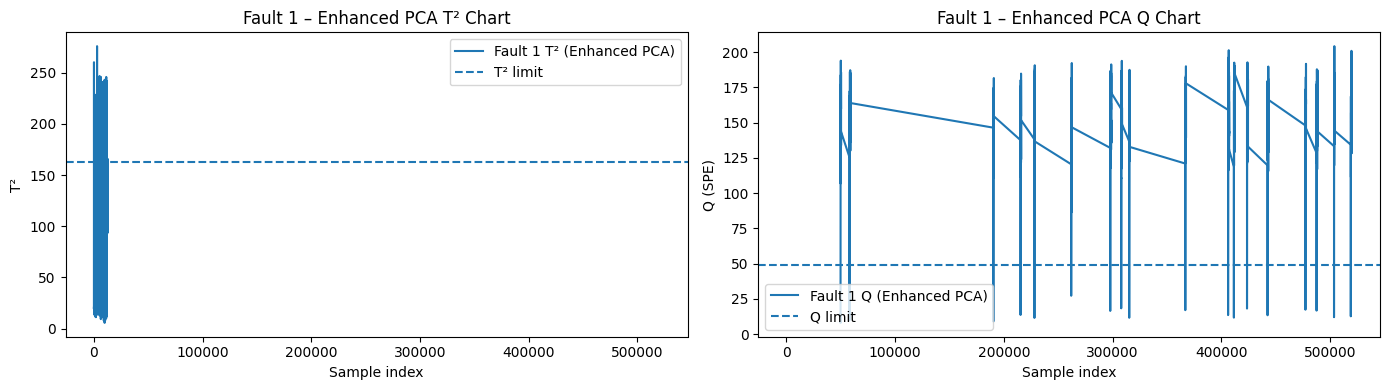

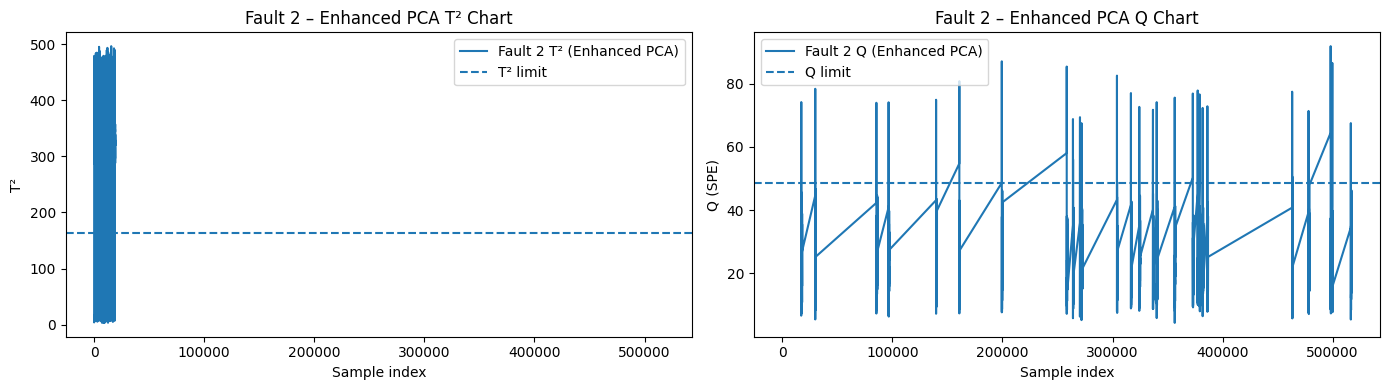

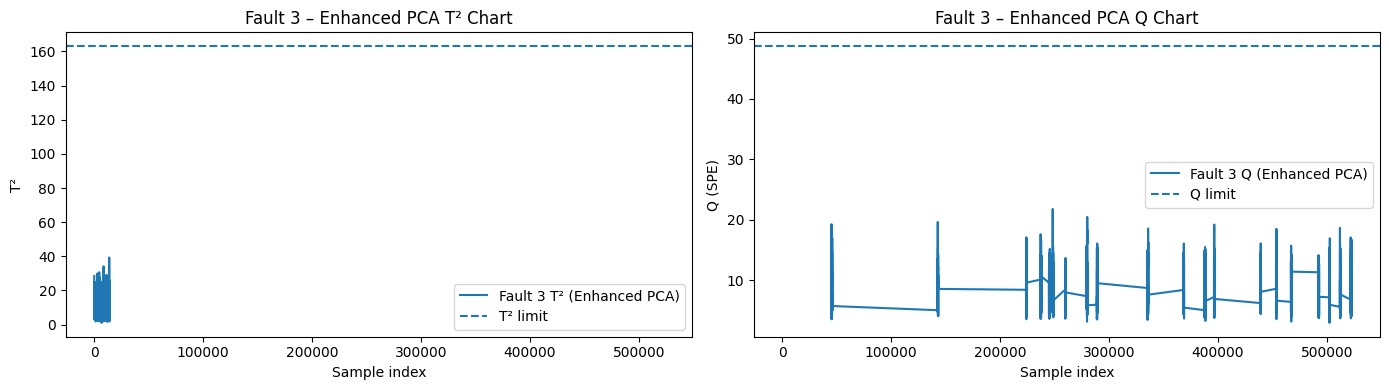

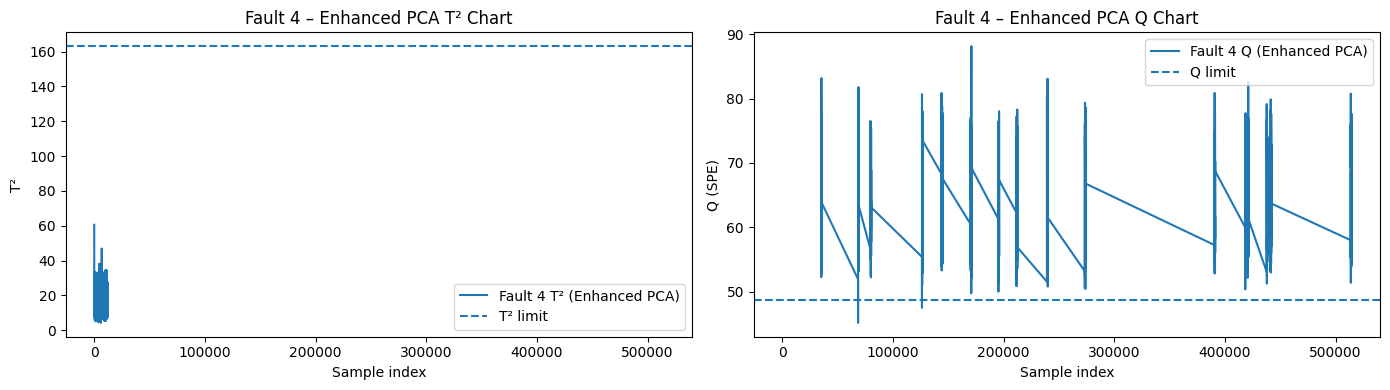

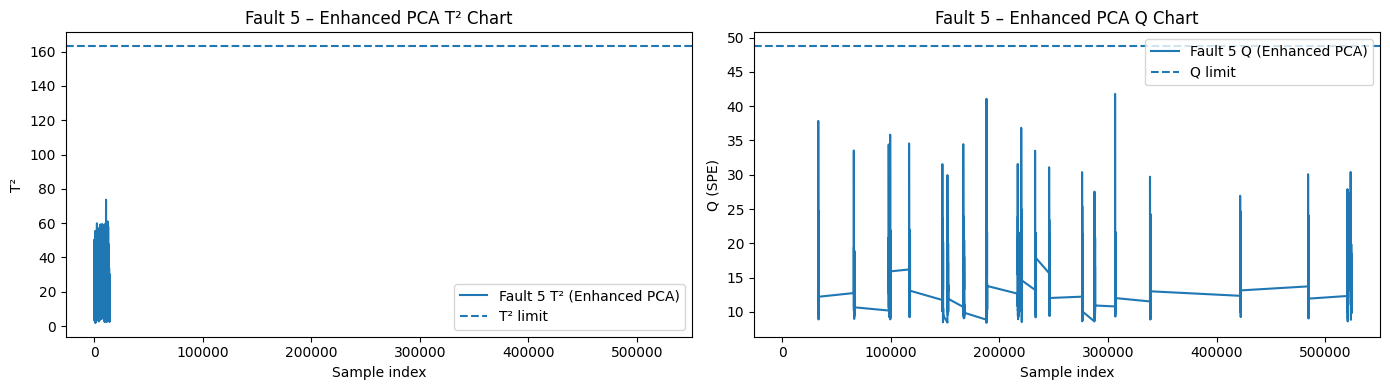

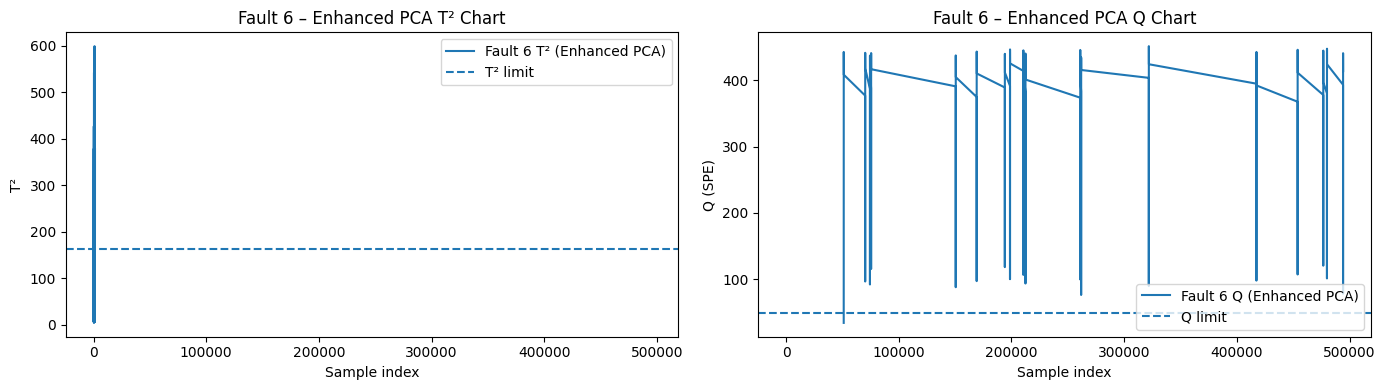

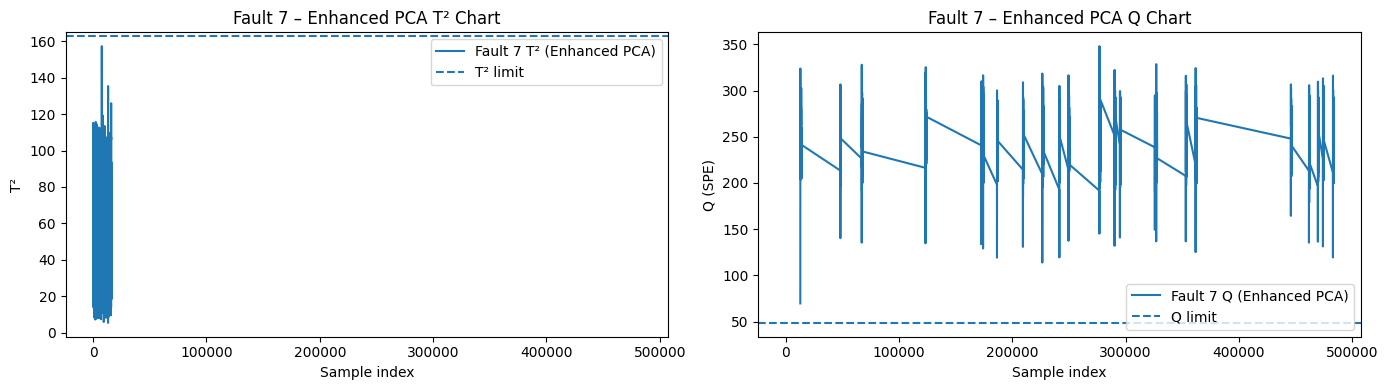

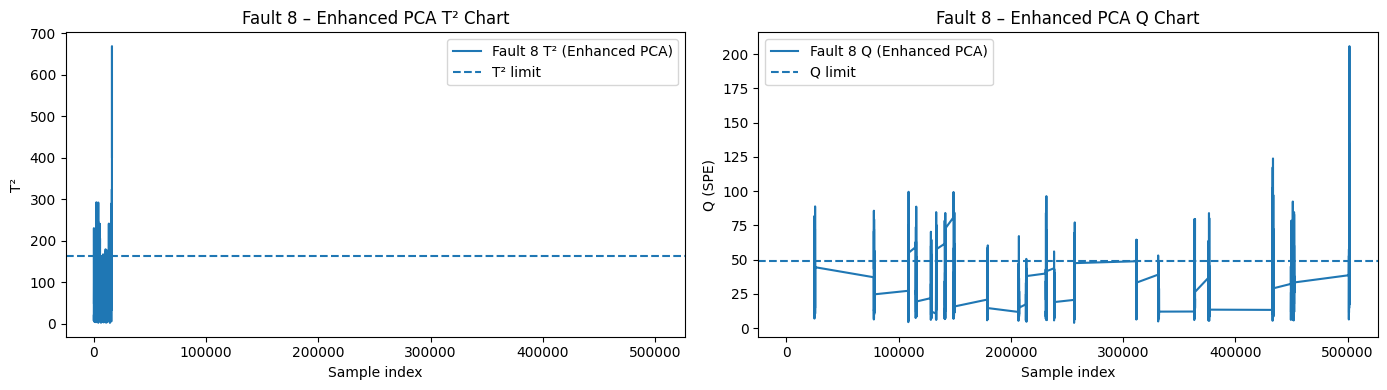

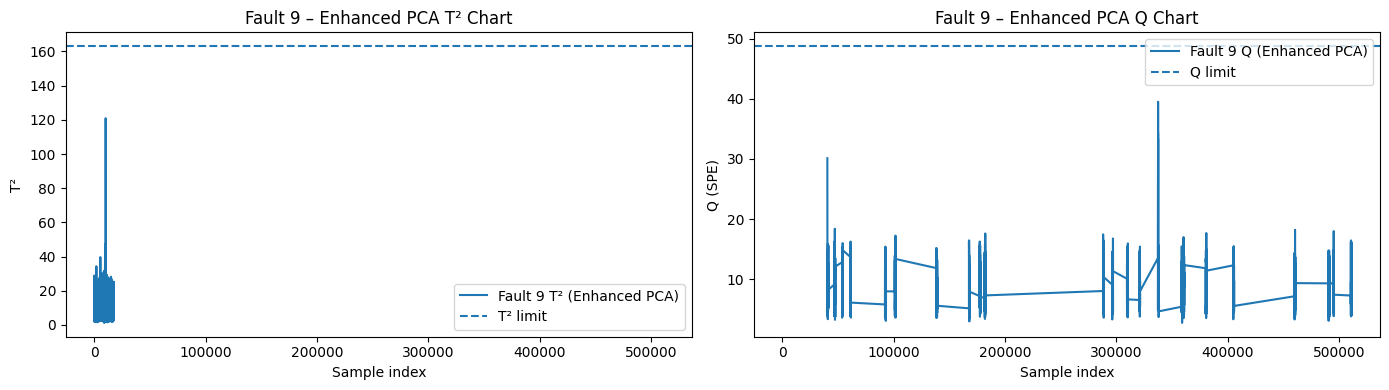

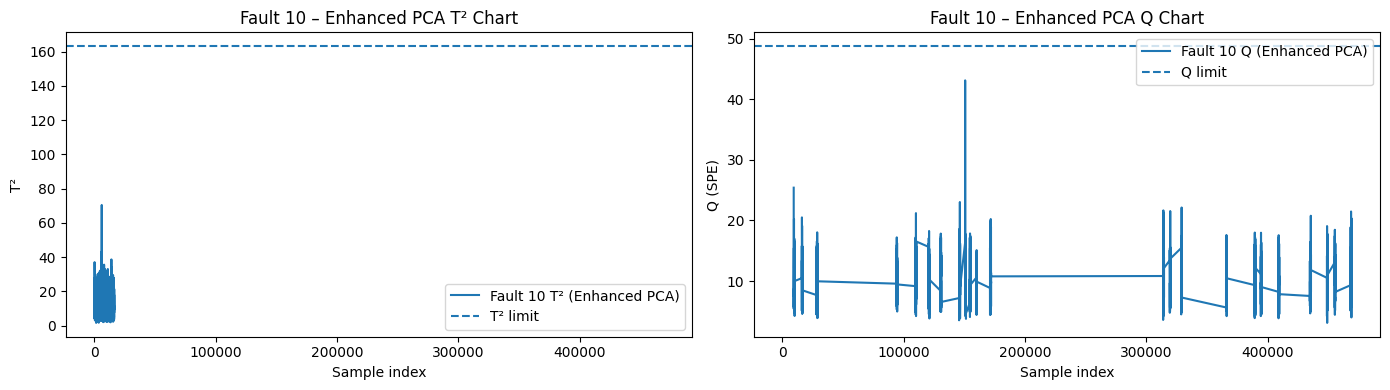

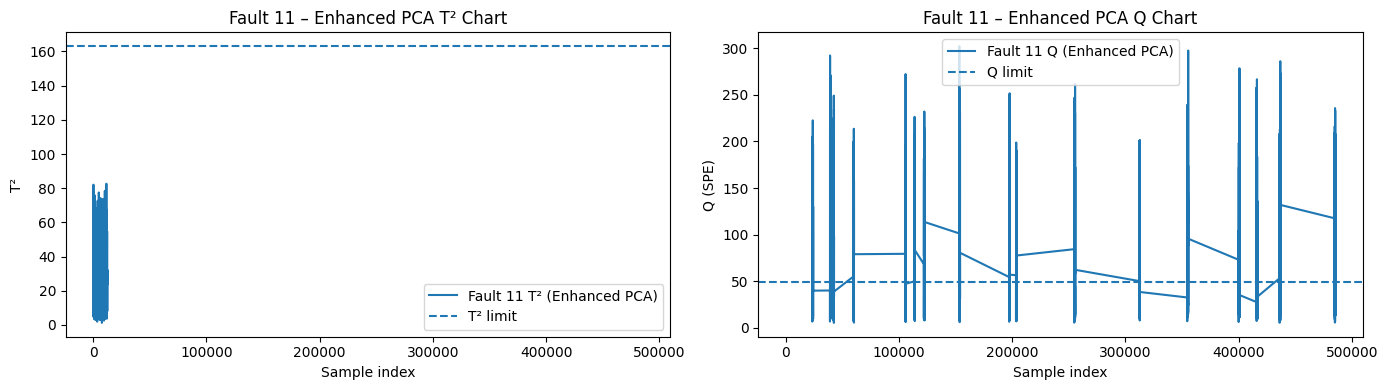

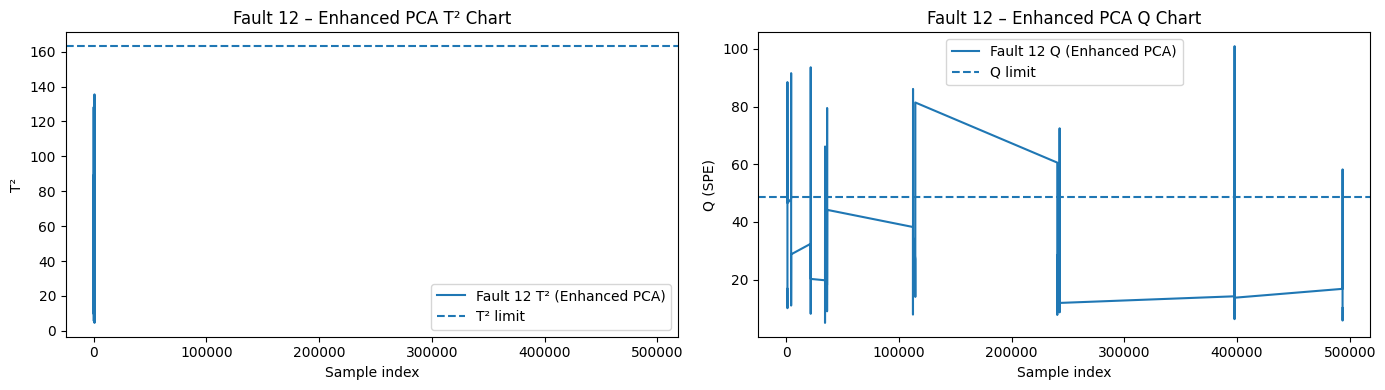

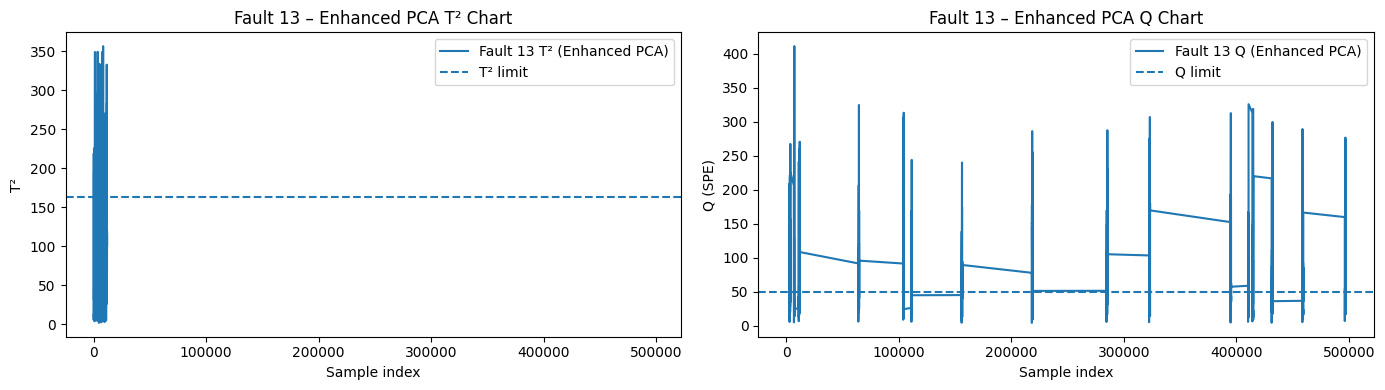

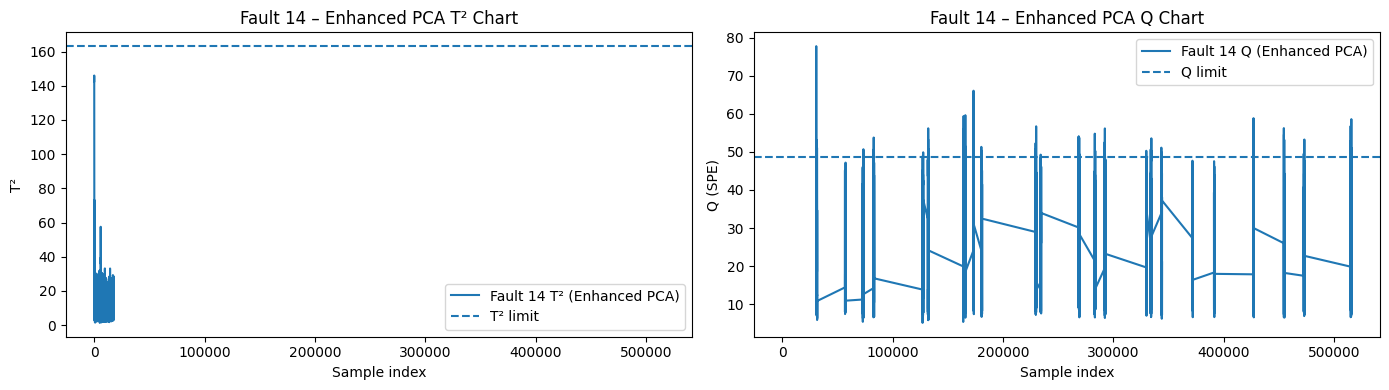

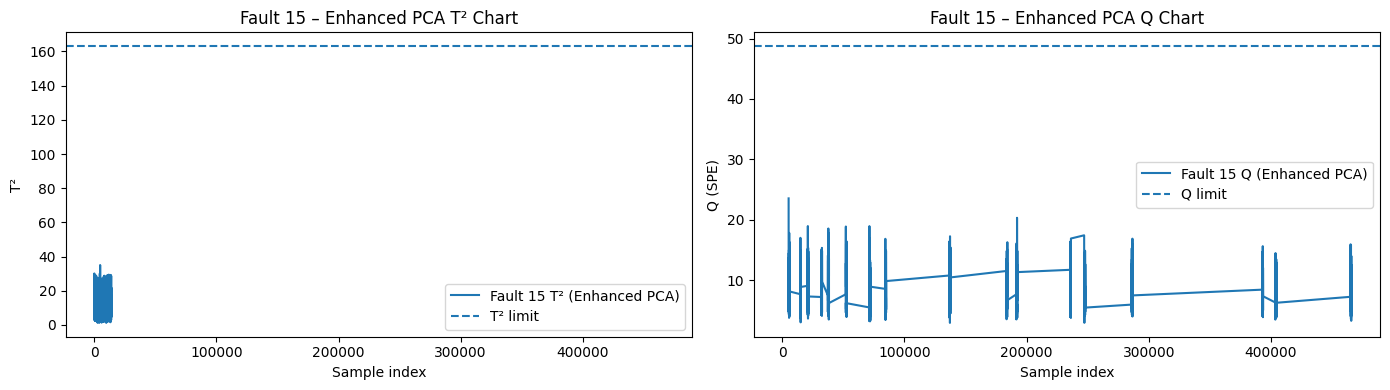

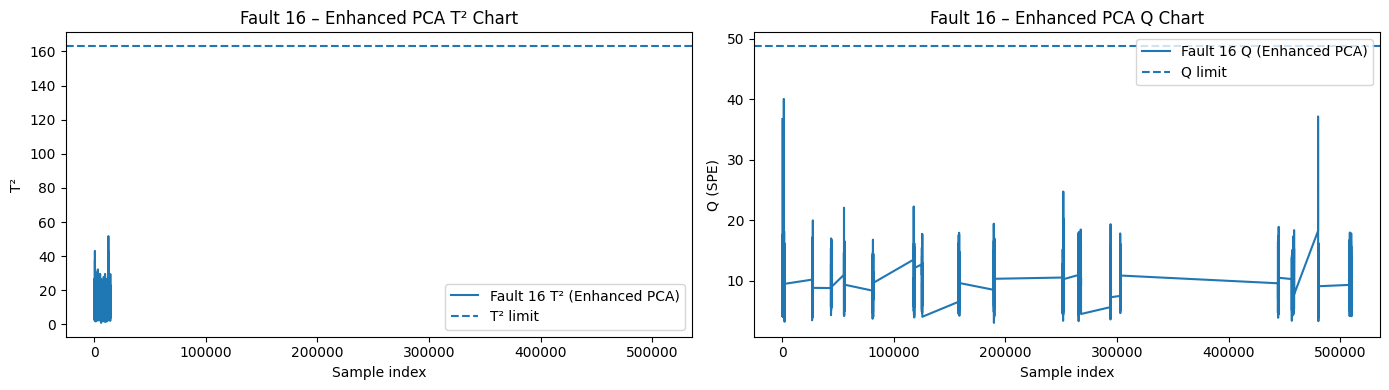

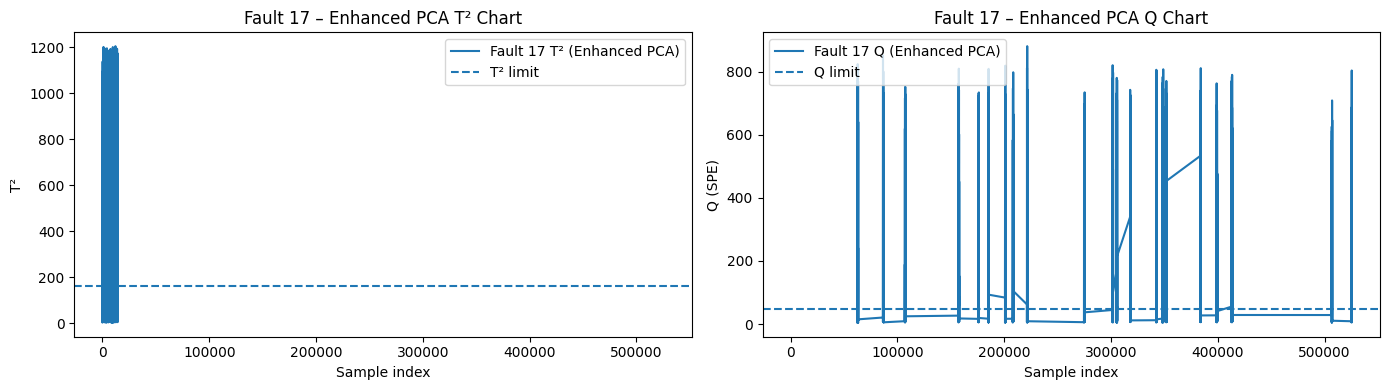

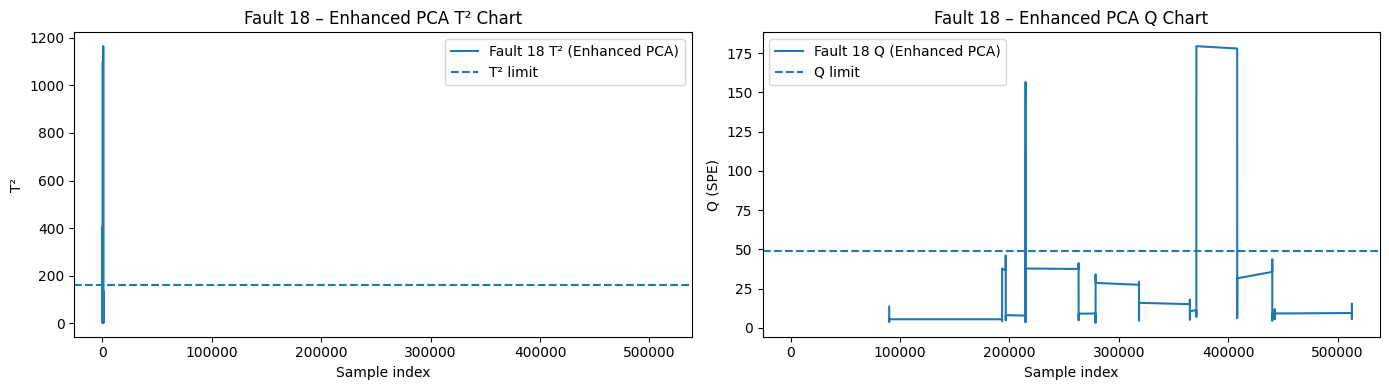

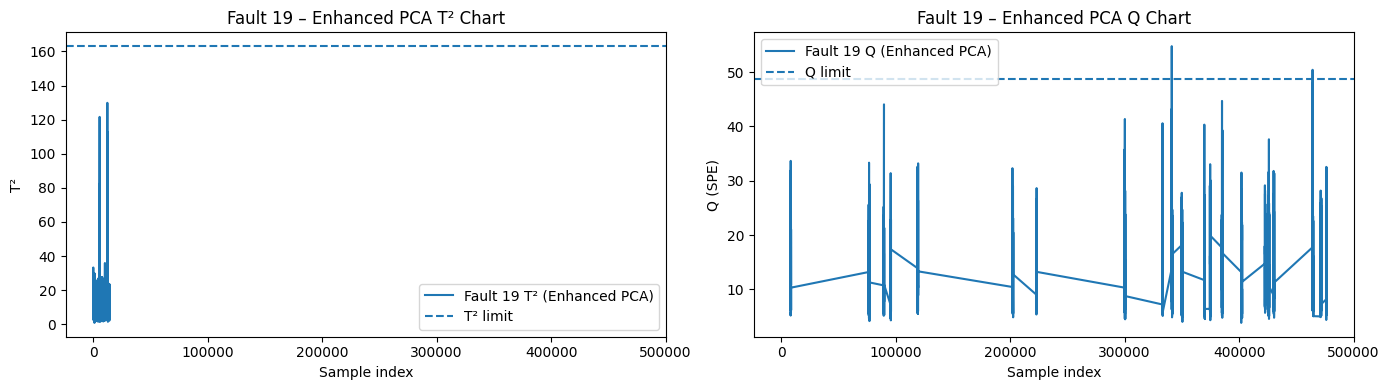

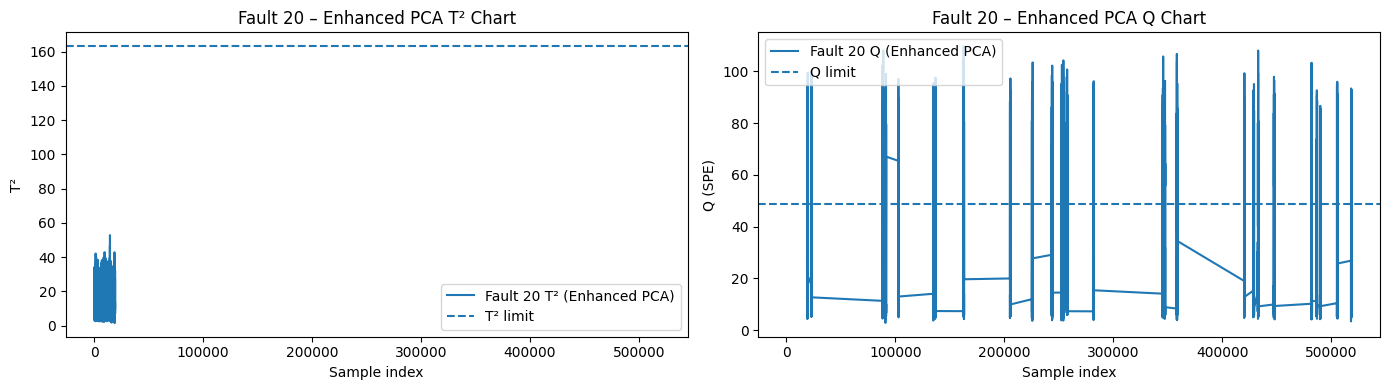

In [367]:
def plot_fault_enh_charts(fault_id):
    """
    Plot Enhanced PCA T² and Q charts for a given fault.
    """
    Xf_enh = X_faulty_enh[fault_id]
    T_f, E_f = compute_pca_scores_and_residuals(Xf_enh, pca_enh)
    T2_f = compute_T2(T_f, eigvals_enh)
    Q_f  = compute_Q(E_f)

    fig, axes = plt.subplots(1, 2, figsize=(14, 4), sharex=True)

    axes[0].plot(T2_f, label=f"Fault {fault_id} T² (Enhanced PCA)")
    axes[0].axhline(T2_lim_enh, linestyle="--", label="T² limit")
    axes[0].set_title(f"Fault {fault_id} – Enhanced PCA T² Chart")
    axes[0].set_xlabel("Sample index")
    axes[0].set_ylabel("T²")
    axes[0].legend()

    axes[1].plot(Q_f, label=f"Fault {fault_id} Q (Enhanced PCA)")
    axes[1].axhline(Q_lim_enh, linestyle="--", label="Q limit")
    axes[1].set_title(f"Fault {fault_id} – Enhanced PCA Q Chart")
    axes[1].set_xlabel("Sample index")
    axes[1].set_ylabel("Q (SPE)")
    axes[1].legend()

    plt.tight_layout()
    plt.show()

for f in range (1,21):
    plot_fault_enh_charts(f)


## 4.4 CVA (Canonical Variate Analysis)
Canonical Variate Analysis (CVA) models the process as a state-space system by separating each observation into “past” and “future” blocks and finding linear combinations (canonical variates) that are most predictive of the future from the past. Using only normal-operation training data, CVA learns these latent states and defines monitoring statistics (T² and Q) in the canonical space.

Control limits are estimated from held-out normal data, and the resulting CVA charts are used to evaluate false alarms and fault detection performance. Because CVA explicitly exploits process dynamics and state evolution, it often provides earlier and more sensitive detection than purely PCA-based approaches.


In [368]:
# Build Hankel matrices (Normal Training Only)

print("===== CVA (Canonical Variate Analysis) =====")

def build_hankel(X, p=5, f=5):
    """
    Build past (P) and future (F) Hankel matrices for CVA.

    Parameters
    ----------
    X : array-like, shape (T, n_features)
        Time-ordered multivariate series (standardized).
    p : int
        Number of past time steps in the window.
    f : int
        Number of future time steps in the window.

    Returns
    -------
    P : ndarray, shape (N, p * n_features)
        Past Hankel matrix.
    F : ndarray, shape (N, f * n_features)
        Future Hankel matrix.
    """
    X = np.asarray(X)
    T, n = X.shape

    N = T - p - f + 1
    if N <= 0:
        raise ValueError("Time series too short for chosen p and f")

    # Past block
    P = np.hstack([X[i : i + N] for i in range(p)])
    # Future block
    F = np.hstack([X[i + p : i + p + N] for i in range(f)])

    return P, F


# ---------------------------------------------------------
# Build CVA matrices using NORMAL TRAINING data only
# ---------------------------------------------------------
p = 5
f = 5
print(f"Using CVA windows: past p={p}, future f={f}")

X_train_np = X_train_normal_std.values
P_train, F_train = build_hankel(X_train_np, p=p, f=f)

print("Past Hankel P shape :", P_train.shape)
print("Future Hankel F shape:", F_train.shape)


===== CVA (Canonical Variate Analysis) =====
Using CVA windows: past p=5, future f=5
Past Hankel P shape : (185429, 260)
Future Hankel F shape: (185429, 260)


In [369]:
# CVA Training: Canonical Variates, T² and Q Limits

print("\n===== CVA TRAINING PHASE =====")

# Center P and F
mean_P = P_train.mean(axis=0)
mean_F = F_train.mean(axis=0)

P0 = P_train - mean_P
F0 = F_train - mean_F

N, dim_p = P0.shape
_, dim_f = F0.shape

# Covariance blocks
R_pp = (P0.T @ P0) / (N - 1)
R_ff = (F0.T @ F0) / (N - 1)
R_pf = (P0.T @ F0) / (N - 1)

print("R_pp shape:", R_pp.shape)
print("R_ff shape:", R_ff.shape)
print("R_pf shape:", R_pf.shape)

# Whitening for past and future
eig_pp, U_pp = np.linalg.eigh(R_pp)
eig_ff, U_ff = np.linalg.eigh(R_ff)

tol = 1e-9
idx_pp = eig_pp > tol
idx_ff = eig_ff > tol

Wp = U_pp[:, idx_pp] @ np.diag(1.0 / np.sqrt(eig_pp[idx_pp])) @ U_pp[:, idx_pp].T
Wf = U_ff[:, idx_ff] @ np.diag(1.0 / np.sqrt(eig_ff[idx_ff])) @ U_ff[:, idx_ff].T

print("Whitening done.")

# SVD of whitened cross-covariance
M = Wp @ R_pf @ Wf.T
U, s, Vt = np.linalg.svd(M)

print("Singular values (first 10):", s[:10])

# Choose number of canonical variates (can tune; 20 is a reasonable start)
r = 20
r = min(r, U.shape[1])  # safety
print("Number of canonical variates kept: r =", r)

U_r = U[:, :r]
V_r = Vt.T[:, :r]

# Canonical directions for past (A) and future (B)
A = Wp.T @ U_r   # dim_p × r
B = Wf.T @ V_r   # dim_f × r (used later for CVDA)

# Canonical variates for training data
Z_train = P0 @ A  # N × r

# Variances of canonical variates (for T² scaling)
eig_z = np.var(Z_train, axis=0, ddof=1)
eig_z = np.clip(eig_z, 1e-9, None)

# CVA T² and Q for training
T2_train_cva = np.sum((Z_train ** 2) / eig_z, axis=1)

P_proj = Z_train @ A.T
E_train_cva = P0 - P_proj
Q_train_cva = np.sum(E_train_cva ** 2, axis=1)

# Control limits (99% quantiles)
T2_lim_cva = np.quantile(T2_train_cva, 0.99)
Q_lim_cva = np.quantile(Q_train_cva, 0.99)

print("===== CVA TRAINING STATISTICS =====")
print("CVA T² limit (99%):", T2_lim_cva)
print("CVA Q limit  (99%):", Q_lim_cva)

# Store CVA model pieces for later use (test + faults + CVDA)
cva_model = {
    "A": A,
    "B": B,           
    "mean_P": mean_P,
    "mean_F": mean_F,
    "eig_z": eig_z,
    "T2_lim": T2_lim_cva,
    "Q_lim": Q_lim_cva,
    "p": p,
    "f": f,
}


===== CVA TRAINING PHASE =====
R_pp shape: (260, 260)
R_ff shape: (260, 260)
R_pf shape: (260, 260)
Whitening done.
Singular values (first 10): [0.99879485 0.99840982 0.99744631 0.99677162 0.99609264 0.99555255
 0.99212807 0.99115159 0.99050794 0.98768832]
Number of canonical variates kept: r = 20
===== CVA TRAINING STATISTICS =====
CVA T² limit (99%): 217.37916493882824
CVA Q limit  (99%): 5537.210609928217


In [370]:
# Helper: Project Any Sequence Through CVA (T² & Q)

def cva_project(X_df, cva_model):
    """
    Apply trained CVA model to a new standardized time series.

    Parameters
    ----------
    X_df : DataFrame
        Standardized process variables, time-ordered.
    cva_model : dict
        Dictionary containing CVA parameters (A, mean_P, eig_z, p, f, T2/Q limits).

    Returns
    -------
    T2 : ndarray
        CVA Hotelling's T² sequence.
    Q : ndarray
        CVA Q (residual) sequence.
    """
    A = cva_model["A"]
    mean_P = cva_model["mean_P"]
    eig_z = cva_model["eig_z"]
    p = cva_model["p"]
    f = cva_model["f"]

    X = X_df.values
    P, F = build_hankel(X, p=p, f=f)  # F not used for detection here

    # Center using training mean of P
    P0 = P - mean_P

    # Canonical variates
    Z = P0 @ A  # (N, r)

    # T² in canonical space
    T2 = np.sum((Z ** 2) / eig_z, axis=1)

    # Residual in past space
    P_proj = Z @ A.T
    E = P0 - P_proj
    Q = np.sum(E ** 2, axis=1)

    return T2, Q


def detection_delay(sequence, limit):
    """
    First time index where statistic exceeds limit.
    Returns None if never crossed.
    """
    idx = np.where(sequence > limit)[0]
    return None if len(idx) == 0 else int(idx[0])

In [371]:
# CVA on Normal Test Data (False Alarms)

print("\n===== 4.4.4 CVA on NORMAL TEST DATA =====")

T2_lim_cva = cva_model["T2_lim"]
Q_lim_cva = cva_model["Q_lim"]

T2_test_cva, Q_test_cva = cva_project(X_test_normal_std, cva_model)

fa_T2_cva = np.mean(T2_test_cva > T2_lim_cva)
fa_Q_cva  = np.mean(Q_test_cva > Q_lim_cva)

print("CVA T² false alarm rate:", fa_T2_cva)
print("CVA Q  false alarm rate:", fa_Q_cva)


===== 4.4.4 CVA on NORMAL TEST DATA =====
CVA T² false alarm rate: 0.010054741080979047
CVA Q  false alarm rate: 0.010293840055370288


In [372]:
# CVA on Faulty Data (Detection Rate + Delay Summary)

print("\n===== CVA FAULT DETECTION SUMMARY =====")

rows = []

for fault_id, Xf_std in X_faulty_std.items():
    T2_fault, Q_fault = cva_project(Xf_std, cva_model)

    dr_T2 = np.mean(T2_fault > T2_lim_cva)  # detection rate
    dr_Q  = np.mean(Q_fault > Q_lim_cva)

    delay_T2 = detection_delay(T2_fault, T2_lim_cva)
    delay_Q  = detection_delay(Q_fault, Q_lim_cva)

    rows.append({
        "Fault": fault_id,
        "T2_DetectionRate": dr_T2,
        "Q_DetectionRate": dr_Q,
        "T2_DetectionDelay": delay_T2,
        "Q_DetectionDelay": delay_Q,
    })

cva_results = pd.DataFrame(rows).sort_values("Fault").reset_index(drop=True)

print("===== CVA Detection Summary =====")
print(cva_results)


===== CVA FAULT DETECTION SUMMARY =====
===== CVA Detection Summary =====
    Fault  T2_DetectionRate  Q_DetectionRate  T2_DetectionDelay  \
0       1          0.963375         0.622385               21.0   
1       2          0.925203         0.000730               50.0   
2       3          0.000000         0.000000                NaN   
3       4          0.000000         0.000000                NaN   
4       5          0.920449         0.983906               45.0   
5       6          0.827875         0.774562               12.0   
6       7          0.000797         0.020852            13189.0   
7       8          0.032262         0.048393               87.0   
8       9          0.000000         0.000000                NaN   
9      10          0.000000         0.001096                NaN   
10     11          0.000000         0.000000                NaN   
11     12          0.020930         0.282558               11.0   
12     13          0.338340         0.199043          

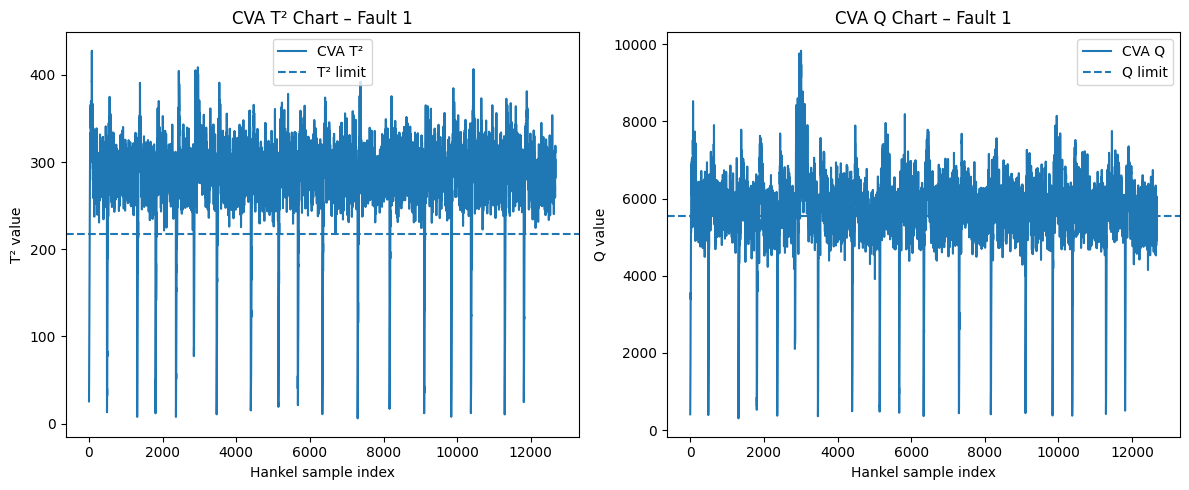

In [373]:
fault_to_plot = 1  

Xf_std = X_faulty_std[fault_to_plot]
T2_fault, Q_fault = cva_project(Xf_std, cva_model)

plt.figure(figsize=(12, 5))

# T² chart
plt.subplot(1, 2, 1)
plt.plot(T2_fault, label="CVA T²")
plt.axhline(T2_lim_cva, linestyle="--", label="T² limit")
plt.xlabel("Hankel sample index")
plt.ylabel("T² value")
plt.title(f"CVA T² Chart – Fault {fault_to_plot}")
plt.legend()

# Q chart
plt.subplot(1, 2, 2)
plt.plot(Q_fault, label="CVA Q")
plt.axhline(Q_lim_cva, linestyle="--", label="Q limit")
plt.xlabel("Hankel sample index")
plt.ylabel("Q value")
plt.title(f"CVA Q Chart – Fault {fault_to_plot}")
plt.legend()

plt.tight_layout()
plt.show()

## 4.5 CVDA (Dissimilarity Analysis)
Canonical Variate Dissimilarity Analysis (CVDA) builds on the CVA state-space model by focusing on how well the predicted future state matches the actual future state under normal operation. For each time point, a scalar D-index measures this mismatch: small values indicate behaviour consistent with the learned normal dynamics, while large values signal abnormal evolution. A data-driven control limit for the D-index is obtained from held-out normal data, and exceedances are treated as alarms. This section uses CVDA to assess false alarms and per-fault detection performance, highlighting its ability to capture subtle changes in dynamic behaviour that may not strongly affect traditional T² or Q statistics.

In [374]:
def compute_cvda_D(X_df, cva_model):
    """
    Compute D-index sequence for CVDA.

    Steps:
    1. Build past (P) and future (F) Hankel matrices.
    2. Center P and F using training means.
    3. Project P and F into canonical variate spaces (A and B).
    4. Compute dissimilarity index:
         D = || Zf_actual - Zf_predicted ||^2
    """
    A = cva_model["A"]
    B = cva_model["B"]
    mean_P = cva_model["mean_P"]
    mean_F = cva_model["mean_F"]
    p = cva_model["p"]
    f = cva_model["f"]

    X = X_df.values
    P, F = build_hankel(X, p=p, f=f)

    P0 = P - mean_P
    F0 = F - mean_F

    Zp = P0 @ A
    Zf = F0 @ B

 
    Zf_pred = Zp.copy()  

    D = np.sum((Zf - Zf_pred)**2, axis=1)

    return D

In [375]:
# Compute D-index on NORMAL test → False Alarm Rate

print("\n===== CVDA on NORMAL TEST DATA =====")

D_normal = compute_cvda_D(X_test_normal_std, cva_model)

# Control limit at 99% quantile
D_lim = np.quantile(D_normal, 0.99)

FAR_D = np.mean(D_normal > D_lim)

print("CVDA D-index limit (99%):", D_lim)
print("CVDA False Alarm Rate:", FAR_D)


===== CVDA on NORMAL TEST DATA =====
CVDA D-index limit (99%): 9.143135381499773
CVDA False Alarm Rate: 0.010004404454791418


In [376]:
# Fault Detection — DR + Delay per Fault

print("\n===== CVDA FAULT DETECTION SUMMARY =====")

results_cvda = []

def detection_delay(sequence, limit):
    idx = np.where(sequence > limit)[0]
    return None if len(idx) == 0 else int(idx[0])

for fault_id, Xf_std in X_faulty_std.items():
    D_fault = compute_cvda_D(Xf_std, cva_model)

    DR = np.mean(D_fault > D_lim)
    delay = detection_delay(D_fault, D_lim)

    print(
        f"Fault {fault_id:2d} → "
        f"D-index DR={DR:.3f}, delay={delay}"
    )

    results_cvda.append({
        "Fault": fault_id,
        "D_DetectionRate": DR,
        "D_DetectionDelay": delay,
    })

df_cvda_results = pd.DataFrame(results_cvda).sort_values("Fault")
print("\n===== CVDA Detection Summary =====")
df_cvda_results


===== CVDA FAULT DETECTION SUMMARY =====
Fault  1 → D-index DR=0.054, delay=74
Fault  2 → D-index DR=0.009, delay=824
Fault  3 → D-index DR=0.005, delay=945
Fault  4 → D-index DR=0.006, delay=746
Fault  5 → D-index DR=0.238, delay=2
Fault  6 → D-index DR=1.000, delay=0
Fault  7 → D-index DR=0.009, delay=114
Fault  8 → D-index DR=0.036, delay=196
Fault  9 → D-index DR=0.007, delay=863
Fault 10 → D-index DR=0.015, delay=880
Fault 11 → D-index DR=0.053, delay=11
Fault 12 → D-index DR=0.238, delay=4
Fault 13 → D-index DR=0.023, delay=338
Fault 14 → D-index DR=0.007, delay=1607
Fault 15 → D-index DR=0.006, delay=743
Fault 16 → D-index DR=0.242, delay=38
Fault 17 → D-index DR=0.074, delay=88
Fault 18 → D-index DR=0.075, delay=68
Fault 19 → D-index DR=0.007, delay=631
Fault 20 → D-index DR=0.024, delay=162

===== CVDA Detection Summary =====


Fault  D_DetectionRate  D_DetectionDelay
0       1         0.054148                74
1       2         0.008711               824
2       3         0.005298               945
3       4         0.005755               746
4       5         0.237947                 2
5       6         1.000000                 0
6       7         0.008954               114
7       8         0.036218               196
8       9         0.006600               863
9      10         0.015034               880
10     11         0.053291                11
11     12         0.238372                 4
12     13         0.023496               338
13     14         0.006601              1607
14     15         0.005812               743
15     16         0.241633                38
16     17         0.073507                88
17     18         0.074850                68
18     19         0.006533               631
19     20         0.024201               162

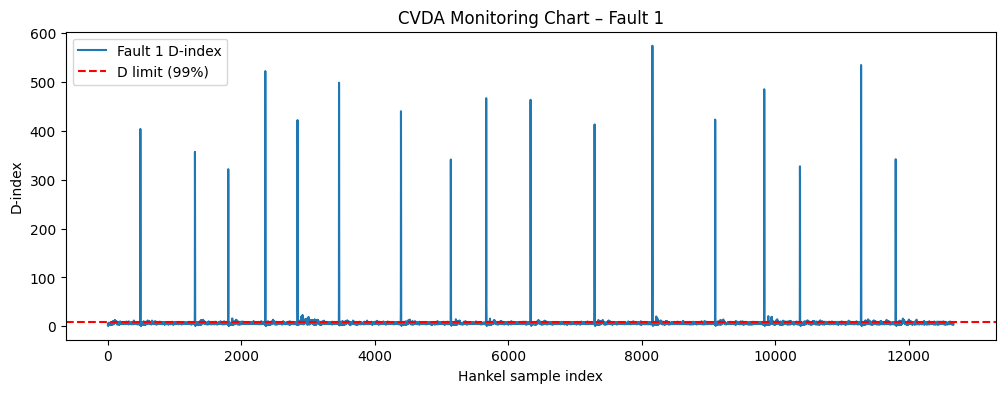

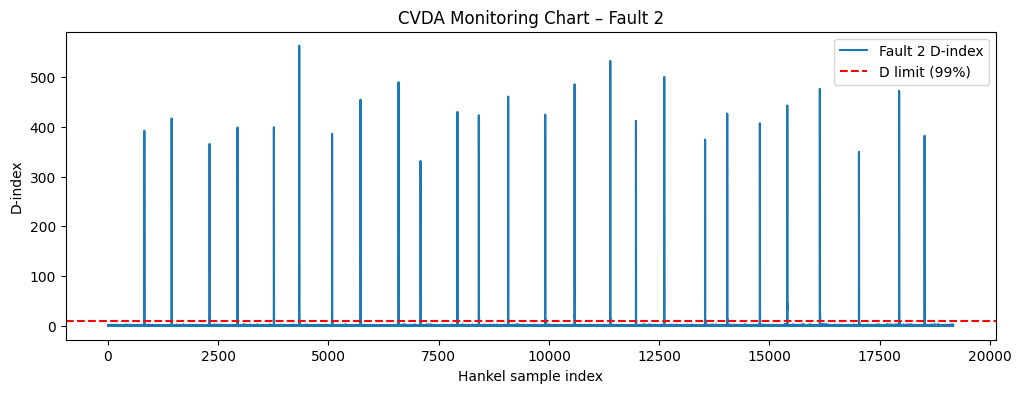

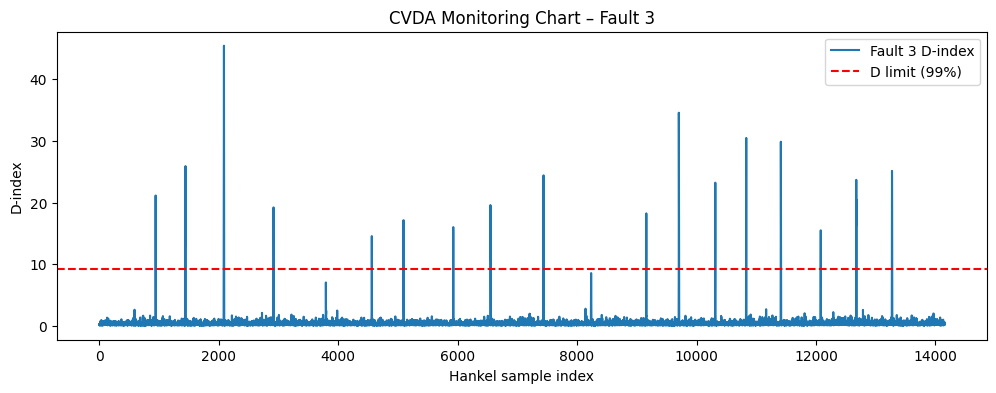

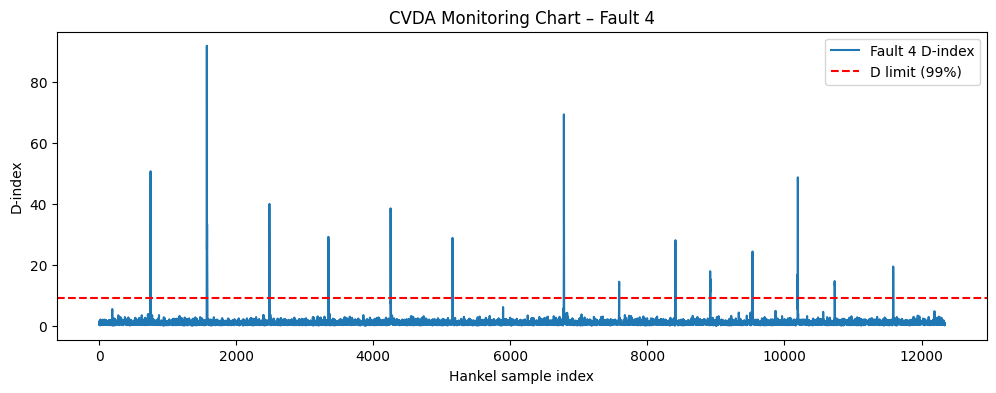

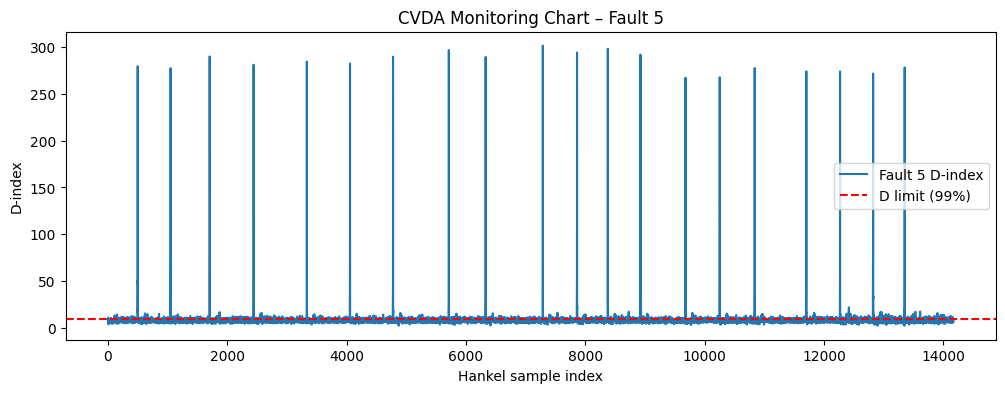

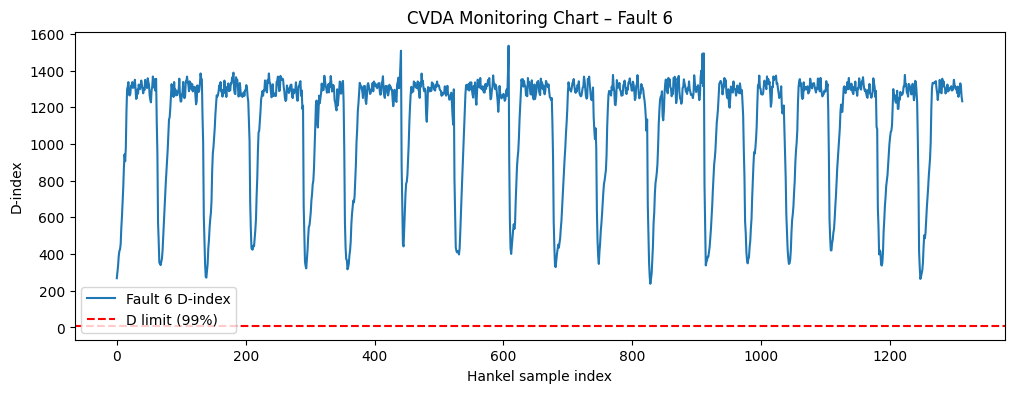

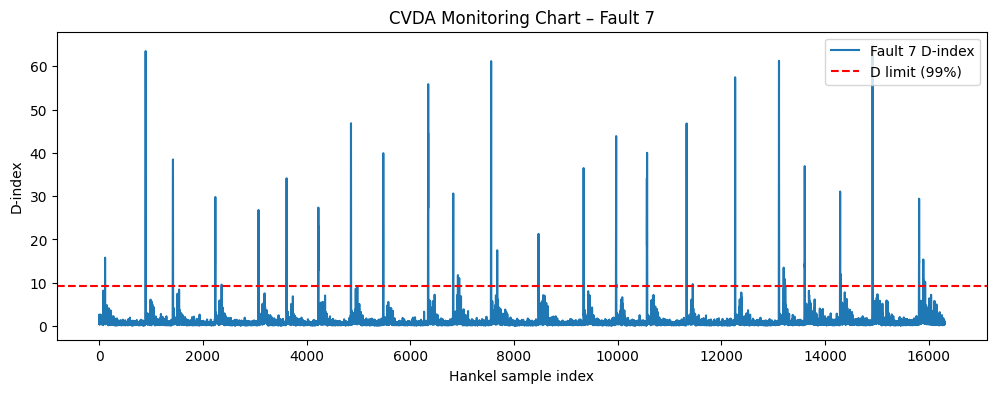

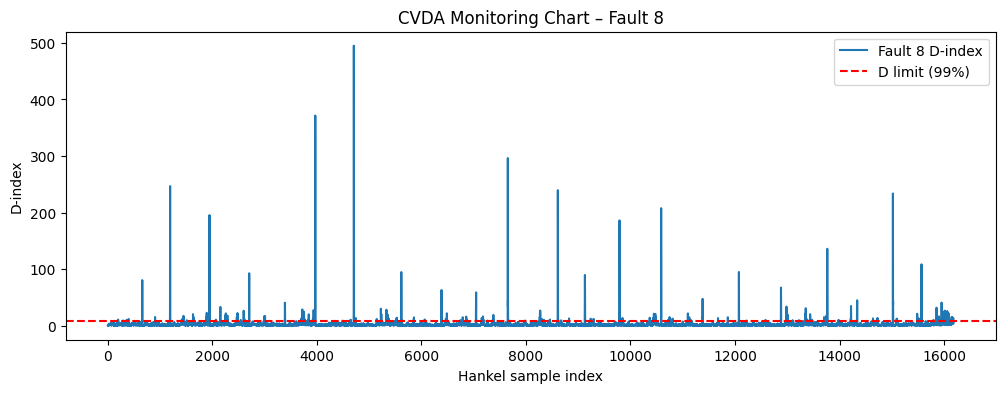

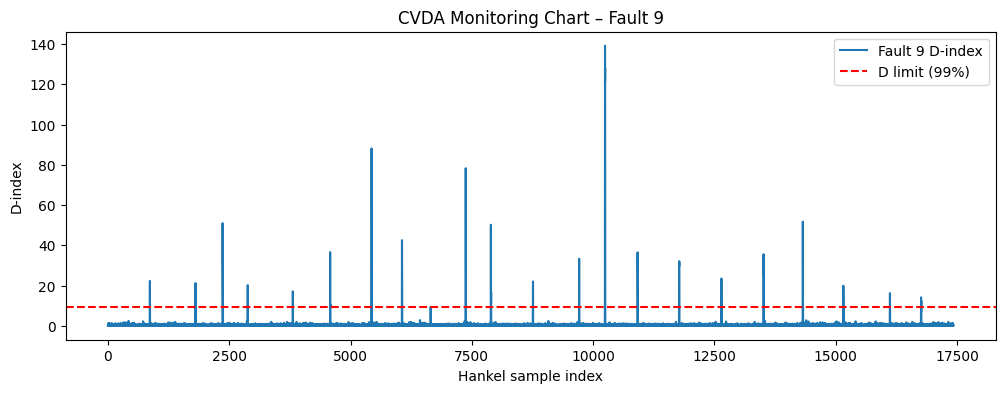

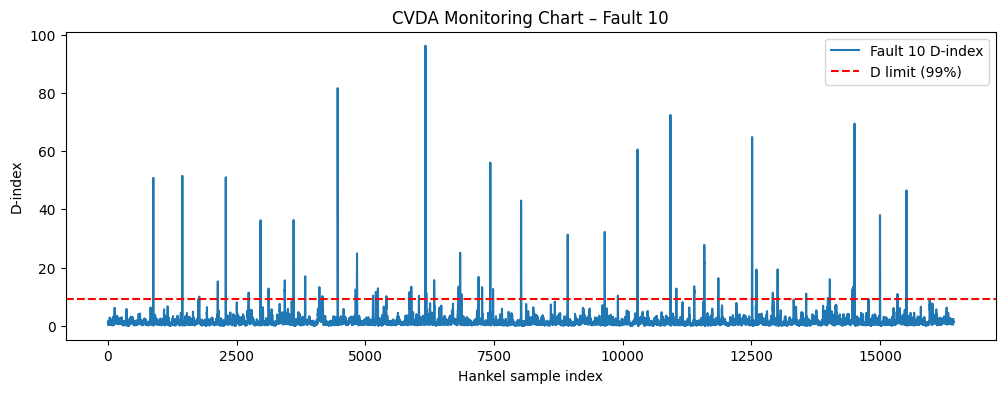

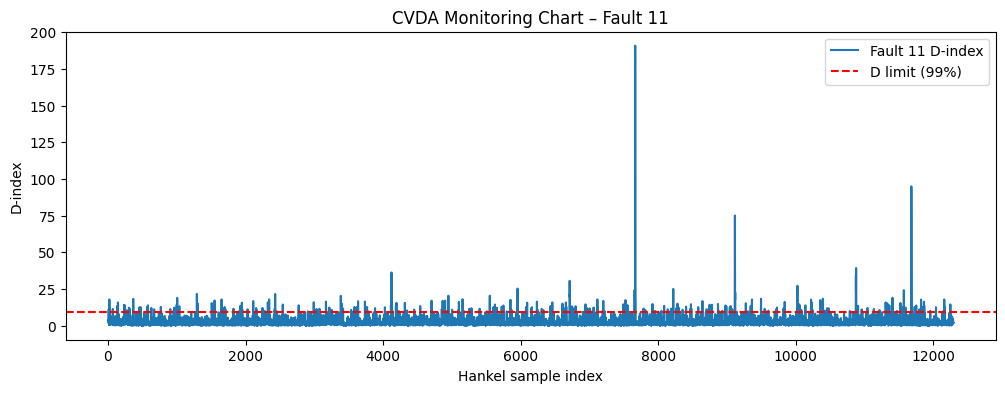

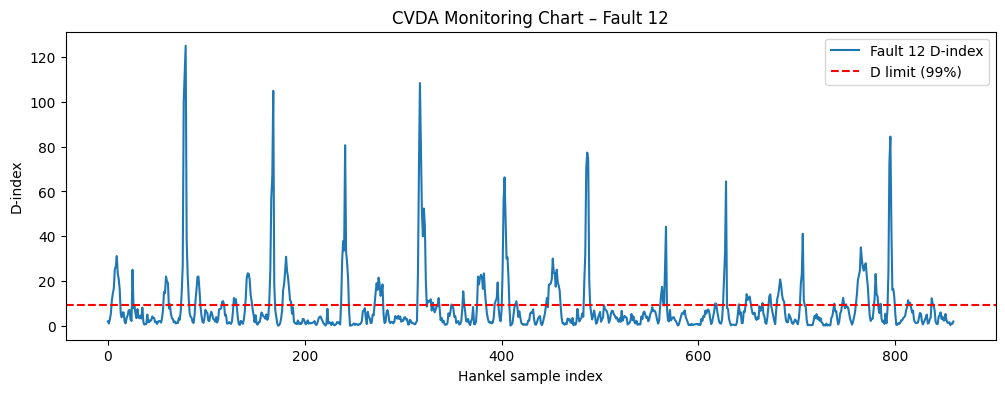

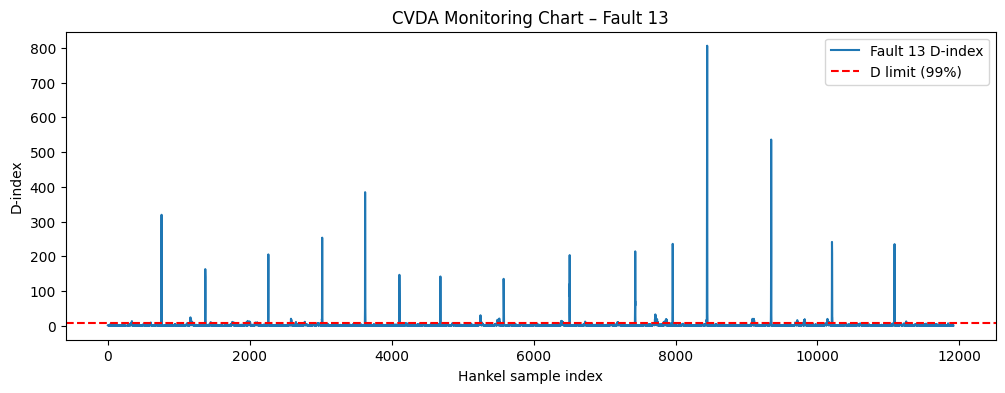

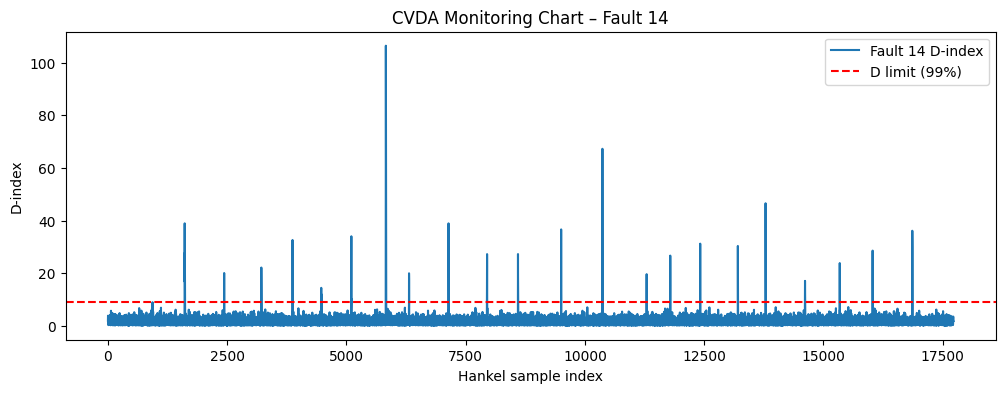

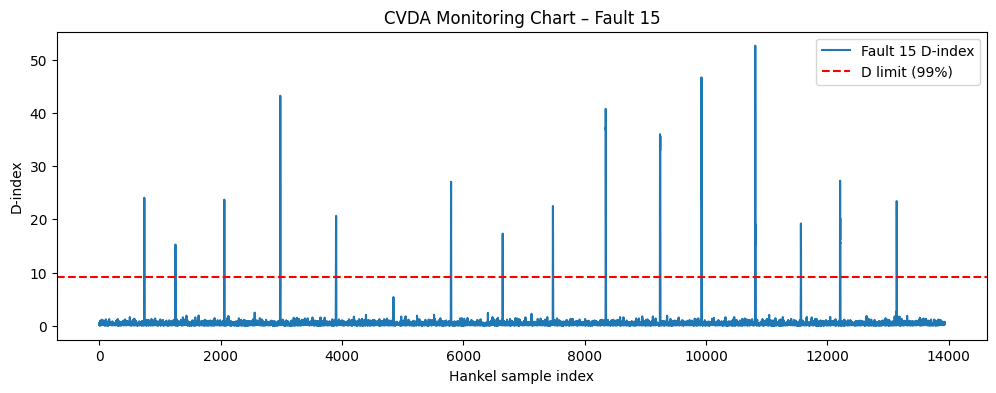

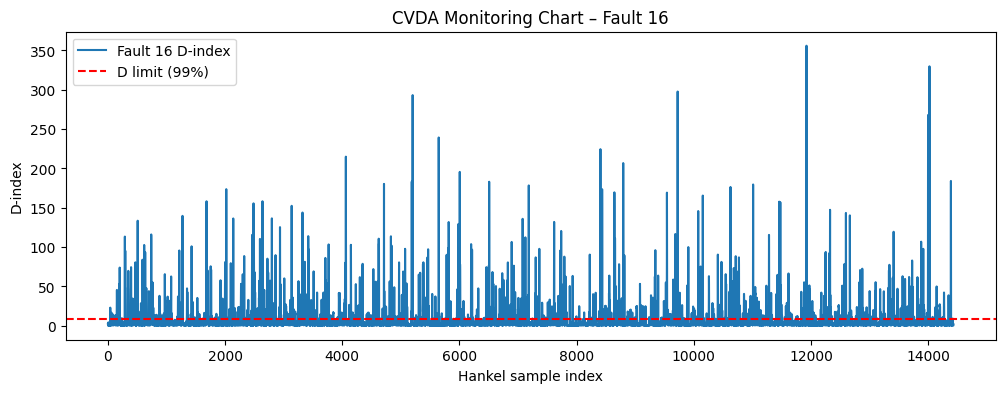

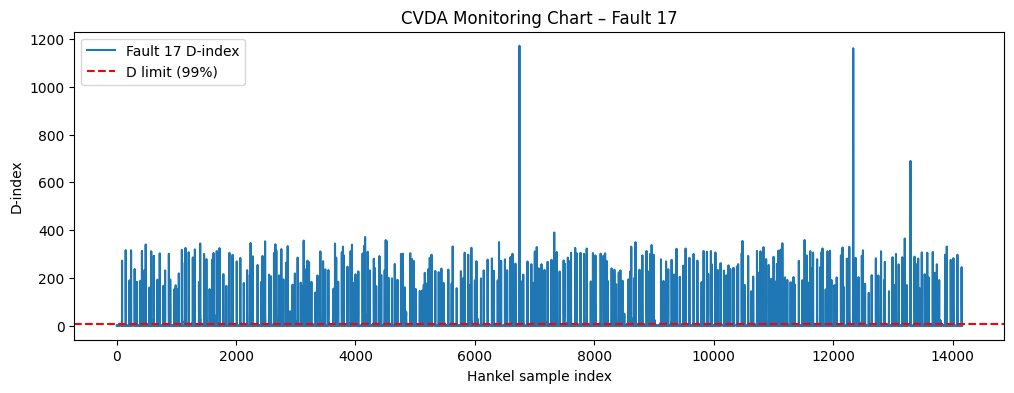

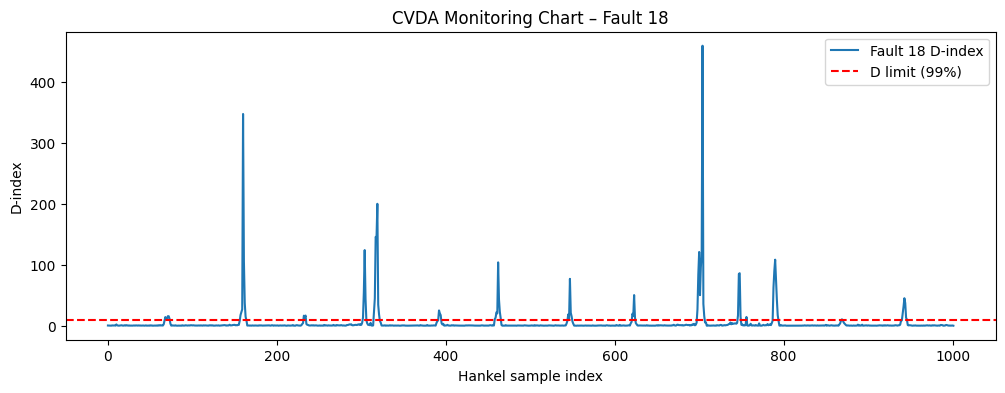

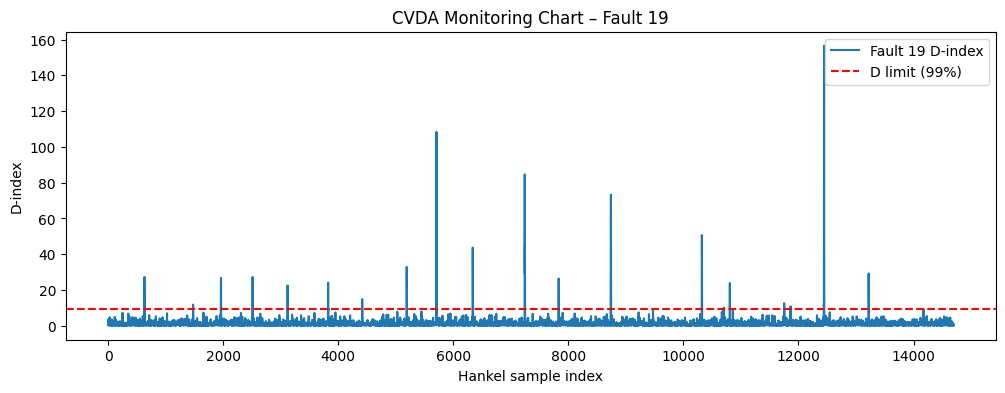

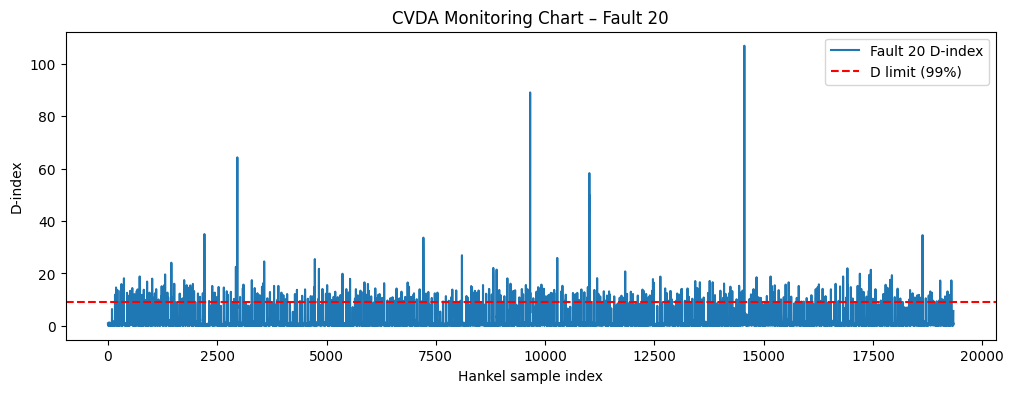

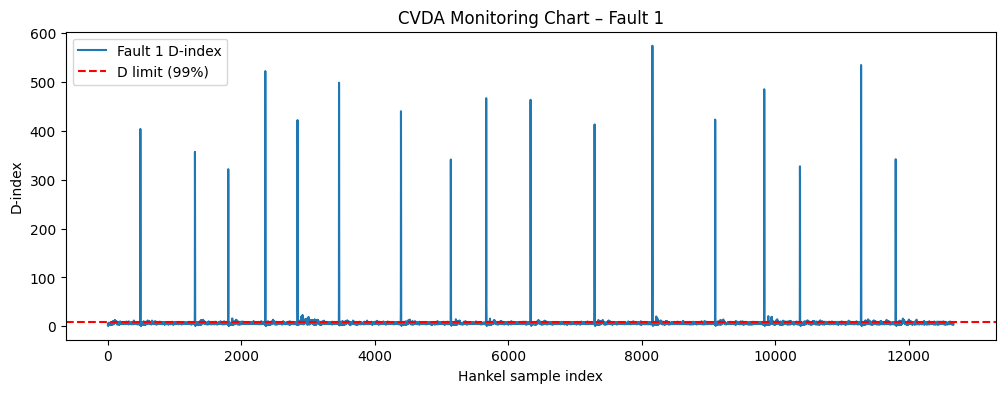

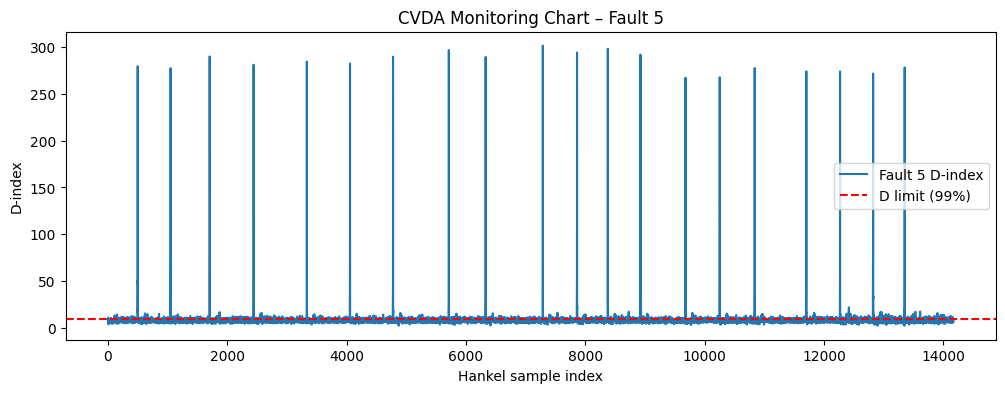

In [377]:
# Visualization


def plot_cvda_fault(fault_id):
    D_fault = compute_cvda_D(X_faulty_std[fault_id], cva_model)

    plt.figure(figsize=(12,4))
    plt.plot(D_fault, label=f"Fault {fault_id} D-index")
    plt.axhline(D_lim, linestyle="--", color="red", label="D limit (99%)")

    plt.xlabel("Hankel sample index")
    plt.ylabel("D-index")
    plt.title(f"CVDA Monitoring Chart – Fault {fault_id}")
    plt.legend()
    plt.show()

for f in range (1,21):
    plot_cvda_fault(f)
plot_cvda_fault(1)
plot_cvda_fault(5)

# 5. Detection Summary
In this section, we bring together the per-fault results from all monitoring methods—Static PCA, Takens-PCA/DPCA, Enhanced PCA, CVA, and CVDA—into a single comparison. For each fault scenario, we summarize detection rate, average detection delay, and false-alarm behaviour using tables and heatmaps. This consolidated view highlights which methods detect which faults most reliably and how quickly, providing a clear basis for judging trade-offs between simplicity (PCA-based models) and dynamic sophistication (CVA/CVDA) when designing a practical monitoring strategy.

## 5.1 Consolidate All Detection Tables Into One Master Table
In this step, we merge the individual detection result tables from each monitoring method (PCA, DPCA, Enhanced PCA, CVA, CVDA) into a single master table indexed by fault ID. For every fault, the table reports key metrics such as detection rate and average detection delay per method. This unified view makes it straightforward to compare models side by side and to identify which techniques offer the best overall performance or complementary strengths across different fault types.

In [378]:
print("===== CONSOLIDATED DETECTION TABLE =====")

# Rename columns for clarity before merging
pca_det = fault_eval_df.rename(columns={
    "T2_DetectionRate": "PCA_T2_DR",
    "Q_DetectionRate":  "PCA_Q_DR",
    "T2_DetectionDelay": "PCA_T2_Delay",
    "Q_DetectionDelay":  "PCA_Q_Delay"
})

dpca_det = df_dpca_results.rename(columns={
    "T2_DetectionRate": "DPCA_T2_DR",
    "Q_DetectionRate":  "DPCA_Q_DR",
    "T2_DetectionDelay": "DPCA_T2_Delay",
    "Q_DetectionDelay":  "DPCA_Q_Delay"
})

enh_det = df_enh_results.rename(columns={
    "T2_DetectionRate": "ENH_T2_DR",
    "Q_DetectionRate":  "ENH_Q_DR",
    "T2_DetectionDelay": "ENH_T2_Delay",
    "Q_DetectionDelay":  "ENH_Q_Delay"
})

cva_det = cva_results.rename(columns={
    "T2_DetectionRate": "CVA_T2_DR",
    "Q_DetectionRate":  "CVA_Q_DR",
    "T2_DetectionDelay": "CVA_T2_Delay",
    "Q_DetectionDelay":  "CVA_Q_Delay"
})

cvda_det = df_cvda_results.rename(columns={
    "D_DetectionRate":   "CVDA_D_DR",
    "D_DetectionDelay":  "CVDA_D_Delay"
})

# Merge everything on Fault number
df_all_det = (
    pca_det
    .merge(dpca_det, on="Fault")
    .merge(enh_det, on="Fault")
    .merge(cva_det, on="Fault")
    .merge(cvda_det, on="Fault")
    .sort_values("Fault")
)

df_all_det

===== CONSOLIDATED DETECTION TABLE =====


Fault  PCA_T2_DR  PCA_Q_DR  PCA_T2_Delay  PCA_Q_Delay  DPCA_T2_DR  \
0       1   0.018378  0.971368          50.0         18.0    0.947381   
1       2   0.939263  0.012252          43.0         64.0    0.942698   
2       3   0.000000  0.000000           NaN          NaN    0.000000   
3       4   0.000000  0.025593           NaN         87.0    0.000000   
4       5   0.000000  0.000000           NaN          NaN    0.000000   
5       6   0.360061  0.981089          48.0          2.0    0.435606   
6       7   0.219995  0.007478          10.0          3.0    0.997670   
7       8   0.017543  0.043919          85.0         55.0    0.041391   
8       9   0.000000  0.000000           NaN          NaN    0.000000   
9      10   0.000000  0.000000           NaN          NaN    0.000000   
10     11   0.002114  0.188537         146.0          6.0    0.019922   
11     12   0.002301  0.166858          20.0         11.0    0.008074   
12     13   0.031192  0.425122         116.0         35.0    0.251761   
13     14   0.531157  0.610895           1.0          3.0    0.748971   
14     15   0.000000  0.000000           NaN          NaN    0.000000   
15     16   0.000000  0.000000           NaN          NaN    0.000000   
16     17   0.373086  0.436525          81.0         79.0    0.435458   
17     18   0.047478  0.094955         162.0        152.0    0.073340   
18     19   0.000000  0.000136           NaN       5813.0    0.000000   
19     20   0.000000  0.087455           NaN         91.0    0.000000   

    DPCA_Q_DR  DPCA_T2_Delay  DPCA_Q_Delay  ENH_T2_DR  ENH_Q_DR  ENH_T2_Delay  \
0    0.784553           25.0            12   0.089303  0.979883          34.0   
1    0.007665           41.0            62   0.943949  0.048543          42.0   
2    0.000282            NaN          1448   0.000000  0.000000           NaN   
3    1.000000            NaN             0   0.000000  0.999757           NaN   
4    0.003528            NaN           504   0.000000  0.000000           NaN   
5    1.000000           44.0             0   0.454545  0.998485          45.0   
6    0.996812            1.0             0   0.000000  1.000000           NaN   
7    0.034781           83.0            74   0.041947  0.098042          82.0   
8    0.000574            NaN          5437   0.000000  0.000000           NaN   
9    0.000791            NaN          1449   0.000000  0.000000           NaN   
10   0.602374           27.0             3   0.000000  0.557489           NaN   
11   0.432526           19.0             9   0.000000  0.229527           NaN   
12   0.376468           43.0            31   0.126132  0.576904         104.0   
13   0.742485            0.0             0   0.000000  0.009024           NaN   
14   0.000359            NaN          4572   0.000000  0.000000           NaN   
15   0.001039            NaN           594   0.000000  0.000000           NaN   
16   0.168890           79.0            92   0.414144  0.346813          79.0   
17   0.093162          154.0           156   0.081269  0.064420         153.0   
18   0.001088            NaN           460   0.000000  0.000544           NaN   
19   0.239442            NaN            79   0.000000  0.148566           NaN   

    ENH_Q_Delay  CVA_T2_DR  CVA_Q_DR  CVA_T2_Delay  CVA_Q_Delay  CVDA_D_DR  \
0          15.0   0.963375  0.622385          21.0         22.0   0.054148   
1          33.0   0.925203  0.000730          50.0      16162.0   0.008711   
2           NaN   0.000000  0.000000           NaN          NaN   0.005298   
3           0.0   0.000000  0.000000           NaN          NaN   0.005755   
4           NaN   0.920449  0.983906          45.0          7.0   0.237947   
5           2.0   0.827875  0.774562          12.0         12.0   1.000000   
6           0.0   0.000797  0.020852       13189.0         73.0   0.008954   
7          54.0   0.032262  0.048393          87.0        322.0   0.036218   
8           NaN   0.000000  0.000000           NaN          NaN   

## 5.2 Detection Rate Heatmap
Here we visualize, as a heatmap, the fraction of correctly detected samples for each fault across all monitoring methods. Each cell shows how often a given method raises an alarm while the fault is active, making it easy to spot which approaches are strong or weak for specific fault types. This provides a quick, comparative view of coverage: which faults are consistently well-detected, which are challenging, and where dynamic methods offer clear advantages over purely static PCA.

===== DETECTION RATE HEATMAP =====


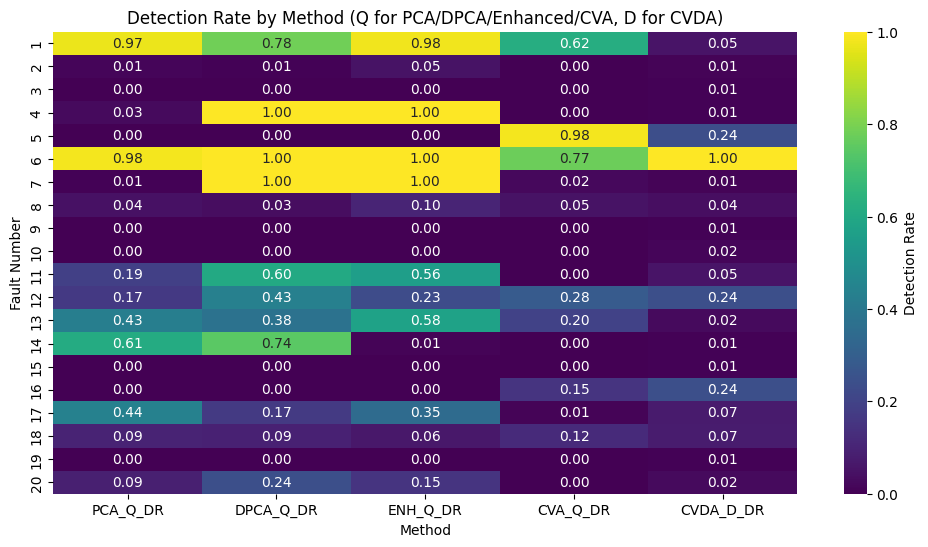

In [379]:
print("===== DETECTION RATE HEATMAP =====")

# Extract Q and D detection rates into one matrix
det_rate_mat = df_all_det[[
    "PCA_Q_DR",
    "DPCA_Q_DR",
    "ENH_Q_DR",
    "CVA_Q_DR",
    "CVDA_D_DR"
]]

det_rate_mat.index = df_all_det["Fault"]

plt.figure(figsize=(12, 6))
sns.heatmap(
    det_rate_mat,
    annot=True,
    cmap="viridis",
    fmt=".2f",
    cbar_kws={"label": "Detection Rate"},
)
plt.title("Detection Rate by Method (Q for PCA/DPCA/Enhanced/CVA, D for CVDA)")
plt.xlabel("Method")
plt.ylabel("Fault Number")
plt.show()


## 5.3 Detection Delay Heatmap
This heatmap summarizes, for each fault and each monitoring method, how quickly an alarm is raised once the fault begins. Each cell shows the average detection delay in samples, so lower values correspond to earlier warnings. By comparing patterns across methods and faults, we can see where dynamic models meaningfully reduce delay, which faults remain hard to catch early, and how much lead time the monitoring framework can realistically provide for intervention.

===== DETECTION DELAY HEATMAP =====


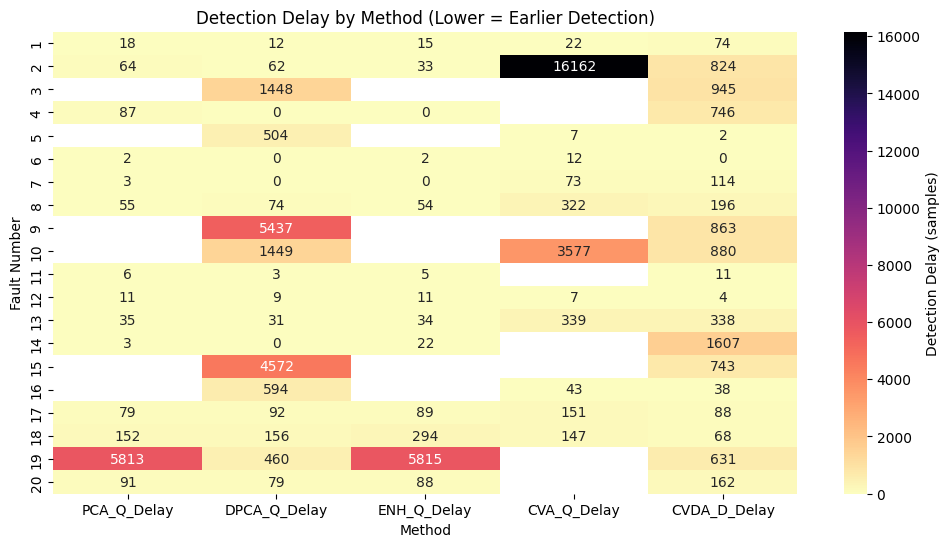

In [380]:
print("===== DETECTION DELAY HEATMAP =====")

delay_mat = df_all_det[[
    "PCA_Q_Delay",
    "DPCA_Q_Delay",
    "ENH_Q_Delay",
    "CVA_Q_Delay",
    "CVDA_D_Delay"
]].replace({None: np.nan})

delay_mat.index = df_all_det["Fault"]

plt.figure(figsize=(12, 6))
sns.heatmap(
    delay_mat,
    annot=True,
    cmap="magma_r",
    fmt=".0f",
    cbar_kws={"label": "Detection Delay (samples)"},
)
plt.title("Detection Delay by Method (Lower = Earlier Detection)")
plt.xlabel("Method")
plt.ylabel("Fault Number")
plt.show()


# 6. Fault Diagnosis
Once a fault is detected, the next step is to understand which variables or latent states are responsible for the alarm. In this section, we use contribution analysis in PCA, DPCA, CVA, and CVDA spaces to decompose the T², Q, and D-index statistics back to individual variables or canonical directions.

By visualizing these contributions over time (bar plots and heatmaps), we identify the key sensors, manipulated variables, or states driving each fault. This turns raw alarms into interpretable diagnostic insights that can guide operators toward likely root causes and relevant corrective actions.

## 6.1 Compute PCA Contributions
Here we decompose the PCA monitoring statistics (T² and Q) into variable-level contributions to see which sensors or manipulated variables are driving each alarm. For selected faults and time points, we compute and visualize these contributions as bar plots and time–variable heatmaps, allowing us to pinpoint the dominant variables behind abnormal behaviour and distinguish primary drivers from secondary effects.

In [381]:
def pca_Q_contributions(E):
    """
    Compute Q (SPE) contributions per variable.
    E : residual matrix (n_samples, n_variables)
    Returns a matrix of same shape.
    """
    return E ** 2 


def pca_T2_contributions(T, pca_model):
    """
    Compute T² contributions per principal component (not per variable!).
    Optional for explanation only.
    """
    eigvals = pca_model.explained_variance_
    return (T ** 2) / eigvals  

## 6.2 Choose a Fault to Diagnose
From the consolidated detection results, we select a representative fault to study in detail—typically one that is both clearly detected and operationally meaningful. This fault will serve as the running example for the diagnosis section, where we drill down into contribution plots and latent trajectories to understand how and why the monitoring statistics rise during its progression.

In [382]:
fault_to_plot = 5  
Xf = X_faulty_std[fault_to_plot]
T_f, E_f = compute_pca_scores_and_residuals(Xf, pca)
Q_contrib = pca_Q_contributions(E_f) 
Q_contrib_df = pd.DataFrame(Q_contrib, columns=Xf.columns)

## 6.3 Bar Plot of Top Variables Causing the Fault
In this step, we visualize the largest PCA contribution values for the selected fault as a bar plot. By ranking variables according to their contribution to the monitoring statistic at a high-alarm time point, the plot highlights the few key measurements or manipulated variables that dominate the fault signal, providing a quick, interpretable snapshot of the main drivers behind the detected abnormality.

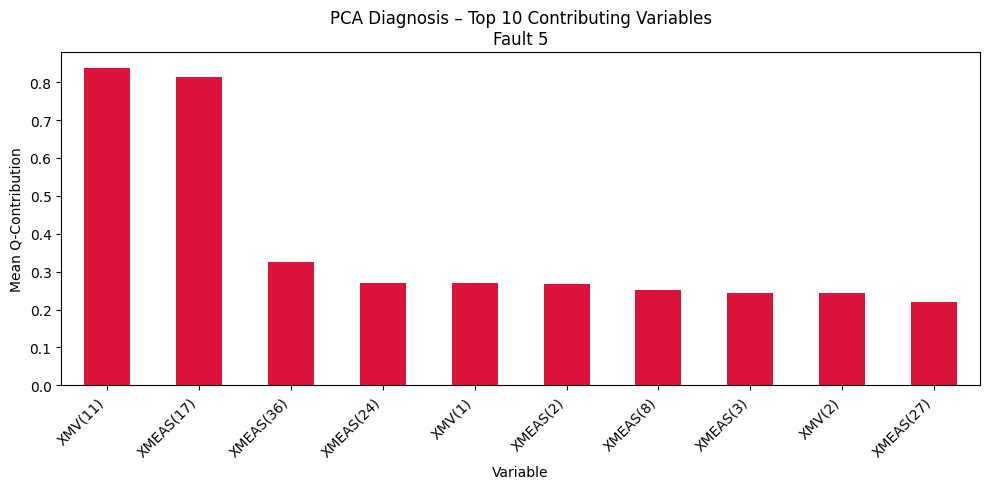

In [383]:
# Compute mean contribution per variable
mean_contrib = Q_contrib_df.mean().sort_values(ascending=False)

top_k = 10
top_vars = mean_contrib.head(top_k)

plt.figure(figsize=(10, 5))
top_vars.plot(kind="bar", color="crimson")
plt.title(f"PCA Diagnosis – Top {top_k} Contributing Variables\nFault {fault_to_plot}")
plt.ylabel("Mean Q-Contribution")
plt.xlabel("Variable")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

## 6.4 Heatmap Over Time (Variable × Time)
In this step, we plot a variable-by-time heatmap of contribution values for the chosen fault. The color intensity shows how strongly each variable contributes at each time point, revealing when specific measurements become dominant, how their influence evolves, and whether new drivers emerge as the fault progresses.

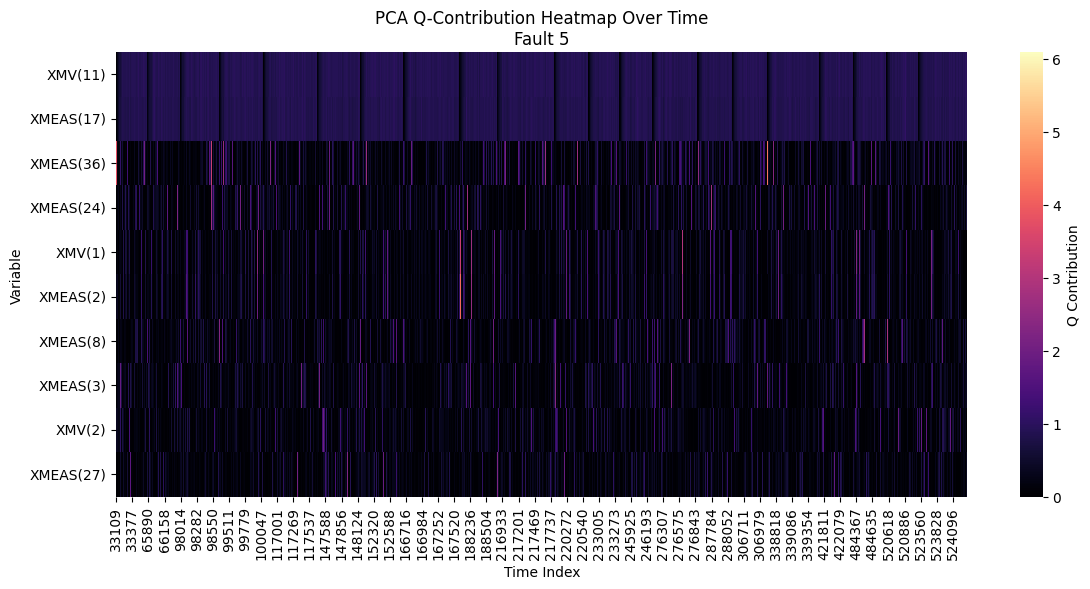

In [384]:
plt.figure(figsize=(12, 6))

# Show only top 10 variables for readability
sns.heatmap(
    Q_contrib_df[top_vars.index].T,
    cmap="magma",
    cbar_kws={"label": "Q Contribution"},
)

plt.title(f"PCA Q-Contribution Heatmap Over Time\nFault {fault_to_plot}")
plt.xlabel("Time Index")
plt.ylabel("Variable")
plt.tight_layout()
plt.show()

## 6.5 DPCA Contributions
Here we repeat the contribution analysis in the dynamic PCA space, where each variable appears together with its time lags. By examining which lagged variables contribute most to the DPCA monitoring statistics, we can see not only which measurements drive the fault, but also how far back in time their influence extends, giving a more detailed picture of the fault’s dynamic signature.

In [385]:
# Compute DPCA Contributions for a Chosen Fault

fault_to_plot = 5

# Get DPCA-enhanced inputs for this fault
Xf_dpca = X_faulty_dpca[fault_to_plot]

# Compute DPCA scores/residuals
T_f_dpca, E_f_dpca = compute_pca_scores_and_residuals(Xf_dpca, pca_dpca)

# Q contributions (dominant diagnostic metric)
Q_contrib_dpca = E_f_dpca ** 2

Q_contrib_dpca_df = pd.DataFrame(Q_contrib_dpca, columns=Xf_dpca.columns)
Q_contrib_dpca_df.head()

XMEAS(1)  XMEAS(2)  XMEAS(3)  XMEAS(4)  XMEAS(5)  XMEAS(6)  XMEAS(7)  \
33111  0.012914  0.386857  0.000378  0.142809  0.000098  0.005298  0.182927   
33112  0.011101  0.017150  0.031548  0.232262  0.000449  0.001984  0.174341   
33113  0.056760  0.072281  0.002395  0.730659  0.000133  0.005267  0.217989   
33114  0.000940  0.524683  1.184806  0.592962  0.000136  0.001427  0.201281   
33115  0.018174  0.433686  0.008135  0.717012  0.000648  0.002156  0.229835   

       XMEAS(8)  XMEAS(9)  XMEAS(10)  ...  XMV(2)_lag2  XMV(3)_lag2  \
33111  0.014182  0.113012   0.004548  ...     0.325682     0.246592   
33112  0.392936  0.141082   0.006159  ...     0.000438     0.001658   
33113  0.462341  0.029190   0.000225  ...     0.017593     0.105582   
33114  3.237432  0.082238   0.009820  ...     0.006008     0.006489   
33115  0.032996  0.000003   0.006611  ...     0.133647     0.002486   

       XMV(4)_lag2  XMV(5)_lag2  XMV(6)_lag2  XMV(7)_lag2   XMV(8)_lag2  \
33111     0.107220     0.013578     0.028943     0.000872  9.871313e-04   
33112     0.094076     0.139517     0.028836     0.000139  1.431071e-05   
33113     0.009806     0.087782     0.002246     0.000030  4.166461e-04   
33114     0.015086     0.065155     0.016038     0.000723  7.505474e-08   
33115     0.016060     0.125564     0.000049     0.001393  9.066275e-05   

       XMV(9)_lag2  XMV(10)_lag2  XMV(11)_lag2  
33111     0.000115      0.070793      0.016433  
33112     0.000360      0.258389      0.035036  
33113     0.002794      0.012129      0.069374  
33114     0.011127      0.000877      0.068466  
33115     0.011139      0.062093      0.058525  

[5 rows x 156 columns]

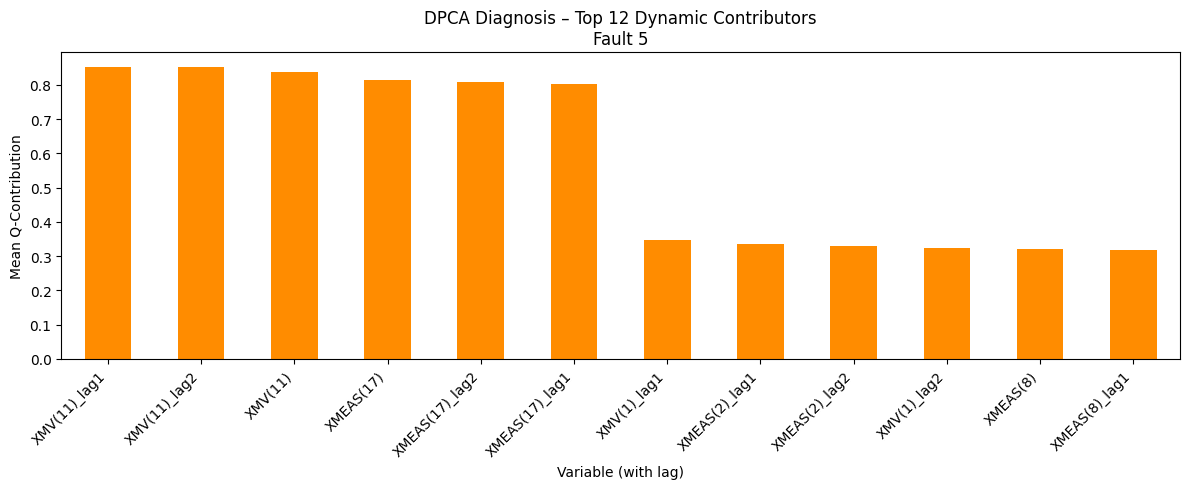

In [386]:
# Bar Plot of Top Dynamic Contributors (Current vs Lags)
mean_contrib_dpca = Q_contrib_dpca_df.mean().sort_values(ascending=False)

top_k = 12
top_vars_dpca = mean_contrib_dpca.head(top_k)

plt.figure(figsize=(12, 5))
top_vars_dpca.plot(kind="bar", color="darkorange")
plt.title(f"DPCA Diagnosis – Top {top_k} Dynamic Contributors\nFault {fault_to_plot}")
plt.ylabel("Mean Q-Contribution")
plt.xlabel("Variable (with lag)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

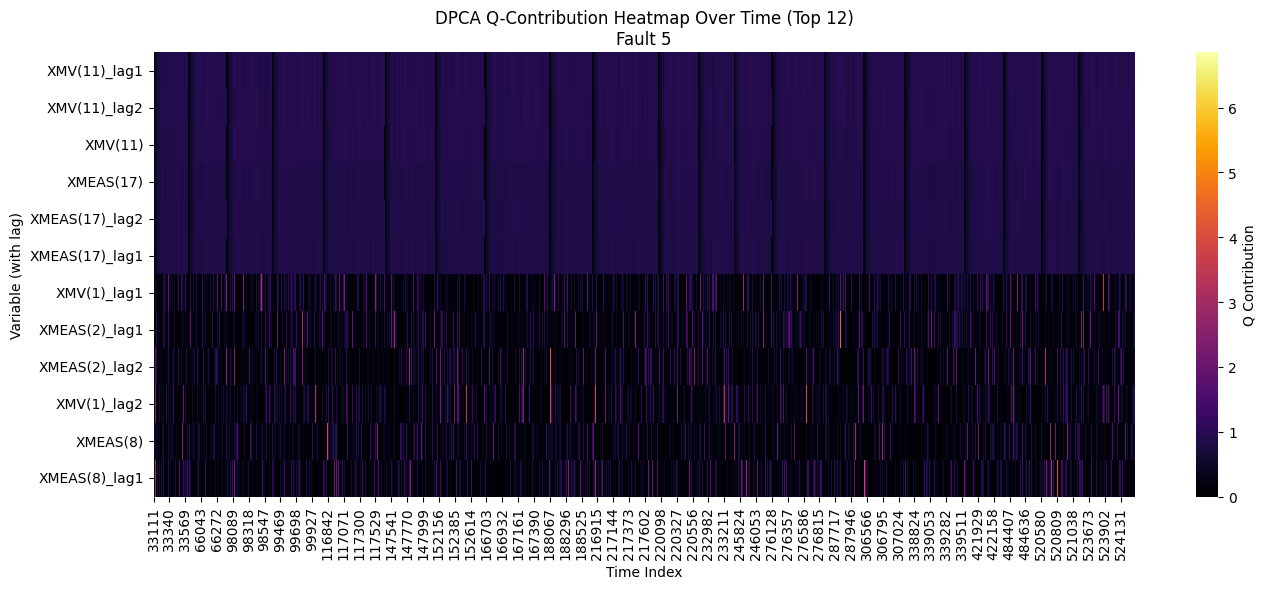

In [387]:
# Heatmap Over Time (Variable × Time)

plt.figure(figsize=(14, 6))

sns.heatmap(
    Q_contrib_dpca_df[top_vars_dpca.index].T,
    cmap="inferno",
    cbar_kws={"label": "Q Contribution"},
)

plt.title(f"DPCA Q-Contribution Heatmap Over Time (Top {top_k})\nFault {fault_to_plot}")
plt.xlabel("Time Index")
plt.ylabel("Variable (with lag)")
plt.tight_layout()
plt.show()

## 6.6 CVA/CVDA Contributions
In this section, we analyze contributions in the canonical state space learned by CVA and CVDA. By decomposing the T², Q, and D-index values into contributions from individual canonical directions, we identify which latent states and dynamic patterns are most responsible for the detected abnormal behaviour, complementing the variable-level insights from PCA and DPCA.

In [388]:
#### Highlight the Fault Onset
# 
#  Compute CVA Z + E for a chosen fault

fault_to_plot = 5

Xf = X_faulty_std[fault_to_plot].values

# Build Hankel matrices for this fault
P_f, F_f = build_hankel(Xf, p=cva_model["p"], f=cva_model["f"])

# Center using training mean
P0_f = P_f - cva_model["mean_P"]
F0_f = F_f - cva_model["mean_F"]

# Canonical variates
A = cva_model["A"]
Z_f = P0_f @ A 

# Residuals in P-space
P_proj_f = Z_f @ A.T
E_f_cva = P0_f - P_proj_f  

### 6.6.1  CVA Contribution Bar Plot (Top Canonical Variables)
We summarize CVA contributions by plotting the most influential canonical directions as a bar chart for the selected fault. This highlights which latent states dominate the T²/Q response at key alarm times, making CVA’s abstract state space easier to interpret for diagnosis.

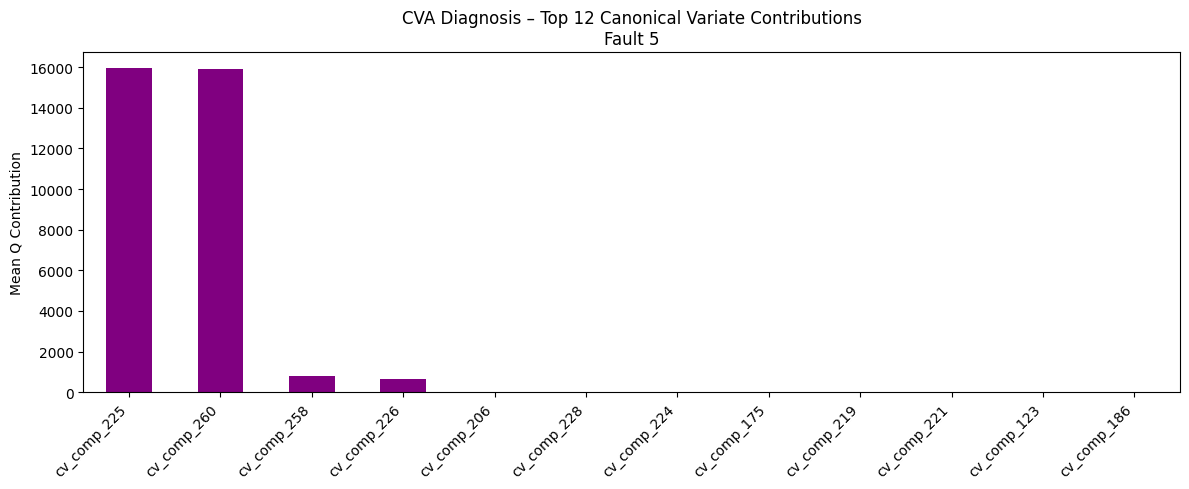

In [389]:
# CVA Contribution Bar Plot (Top Canonical Variables)
CVA_Q_contrib = (E_f_cva ** 2).mean(axis=0)

# Build Series with canonical variable names
canonical_names = [f"cv_comp_{i+1}" for i in range(len(CVA_Q_contrib))]
CVA_Q_series = pd.Series(CVA_Q_contrib, index=canonical_names)
CVA_Q_series = CVA_Q_series.sort_values(ascending=False)

top_k = 12
top_cva = CVA_Q_series.head(top_k)

plt.figure(figsize=(12, 5))
top_cva.plot(kind="bar", color="purple")
plt.title(f"CVA Diagnosis – Top {top_k} Canonical Variate Contributions\nFault {fault_to_plot}")
plt.ylabel("Mean Q Contribution")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

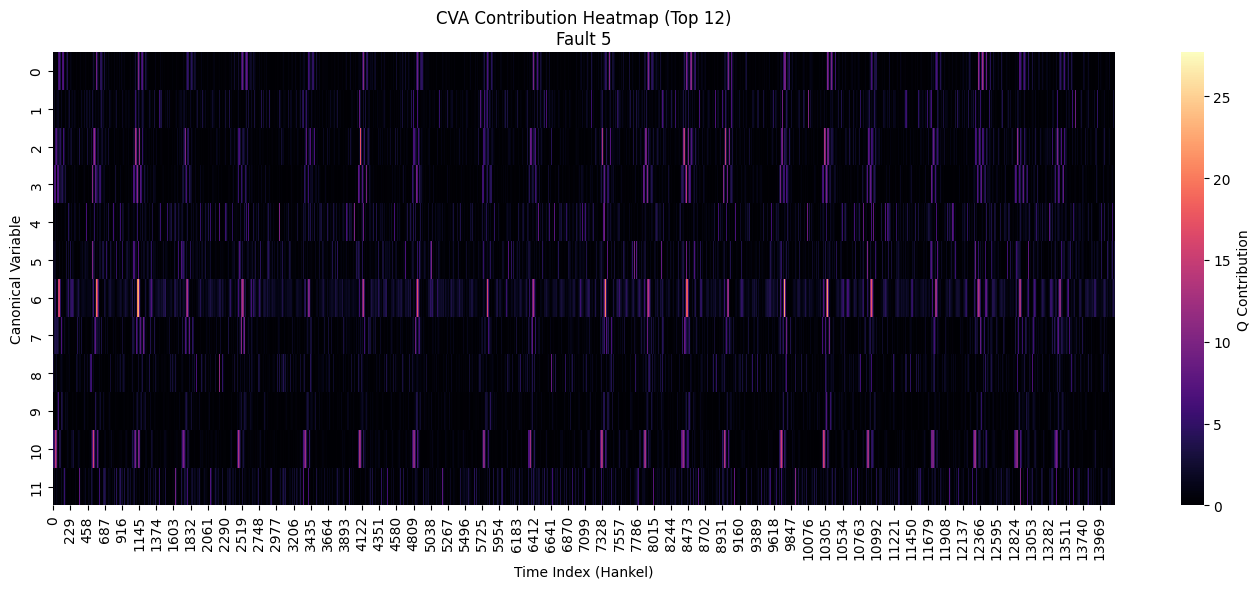

In [390]:
plt.figure(figsize=(14, 6))

sns.heatmap(
    (E_f_cva ** 2)[:, :top_k].T,
    cmap="magma",
    cbar_kws={"label": "Q Contribution"},
)

plt.title(f"CVA Contribution Heatmap (Top {top_k})\nFault {fault_to_plot}")
plt.xlabel("Time Index (Hankel)")
plt.ylabel("Canonical Variable")
plt.tight_layout()
plt.show()

### 6.6.2  CVDA D-index Contributions
Here we decompose the CVDA D-index into contributions from individual canonical directions and visualize the largest ones. This shows which latent dynamic patterns are most responsible for the predicted–vs–actual future mismatch, helping to explain why the D-index spikes during the fault.

In [391]:
# CVDA canonical variates
B = cva_model["B"]

Zp_f = P0_f @ A     
Zf_f = F0_f @ B    
Zf_pred_f = Zp_f     

# Contribution matrix
D_contrib = (Zf_f - Zf_pred_f) ** 2   # shape (N, r)

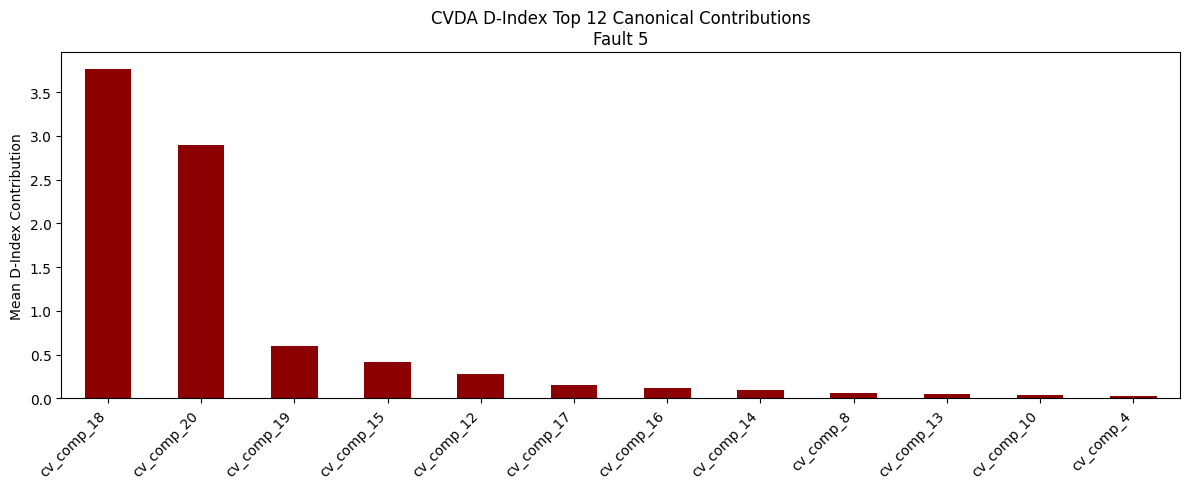

In [392]:
# CVDA D-index Contribution Bar Plot

mean_D_contrib = D_contrib.mean(axis=0)

canonical_names = [f"cv_comp_{i+1}" for i in range(D_contrib.shape[1])]
D_series = pd.Series(mean_D_contrib, index=canonical_names)
D_top = D_series.sort_values(ascending=False).head(top_k)

plt.figure(figsize=(12, 5))
D_top.plot(kind="bar", color="darkred")
plt.title(f"CVDA D-Index Top {top_k} Canonical Contributions\nFault {fault_to_plot}")
plt.ylabel("Mean D-Index Contribution")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

### 6.6.3 CVDA Contribution Heatmap
In this step, we plot a time–canonical-direction heatmap of CVDA D-index contributions for the selected fault. The color intensity shows how strongly each canonical state contributes at each time point, revealing when specific latent dynamic patterns become dominant and how their influence evolves as the fault develops.

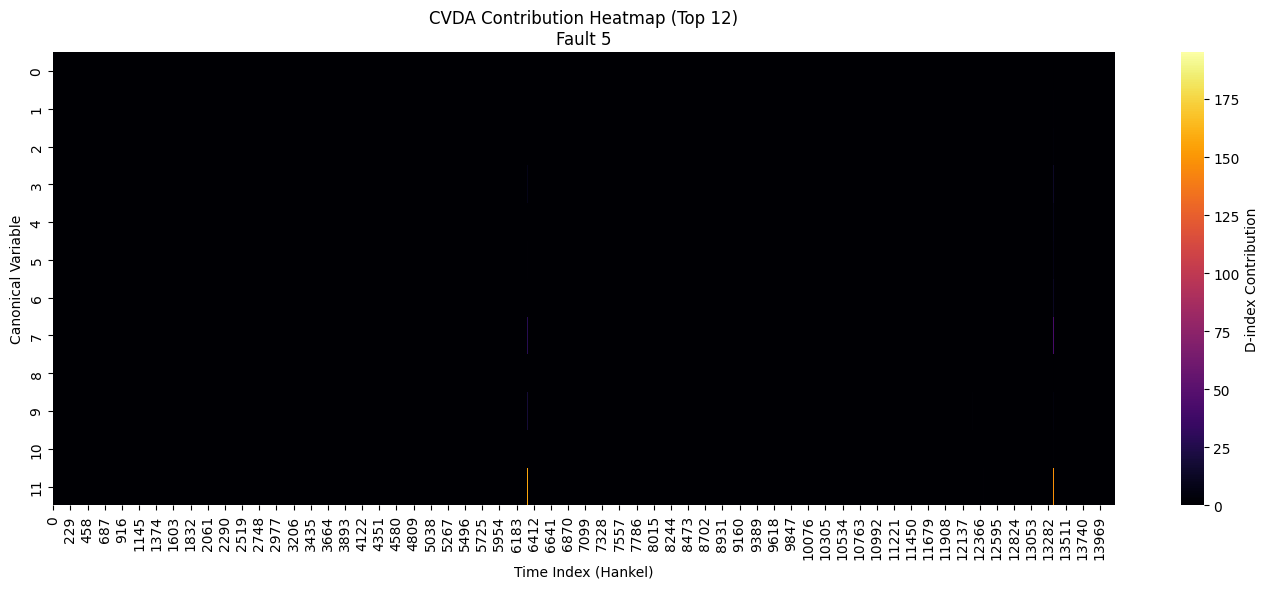

In [393]:
# CVDA Contribution Heatmap

plt.figure(figsize=(14, 6))

sns.heatmap(
    D_contrib[:, :top_k].T,
    cmap="inferno",
    cbar_kws={"label": "D-index Contribution"},
)

plt.title(f"CVDA Contribution Heatmap (Top {top_k})\nFault {fault_to_plot}")
plt.xlabel("Time Index (Hankel)")
plt.ylabel("Canonical Variable")
plt.tight_layout()
plt.show()

# 7. Fault Prognosis
In this section, we move beyond detecting and explaining faults to assessing how they evolve over time and how early warnings can be issued. Using latent trajectories (PCA/DPCA/CVA states) and the time profile of the D-index, we characterize whether each fault is abrupt or slowly developing, how quickly it drifts away from normal operation, and how much lead time the monitoring framework offers before the process reaches clearly abnormal levels. This links the statistical models to practical questions of intervention timing, maintenance planning, and risk management.

## 7.1 Trajectory Plots (PC1-PC2/CVA State)

In [394]:
fault_to_plot = 5 

### 7.1.1 PCA Trajectory (PC1-PC2)

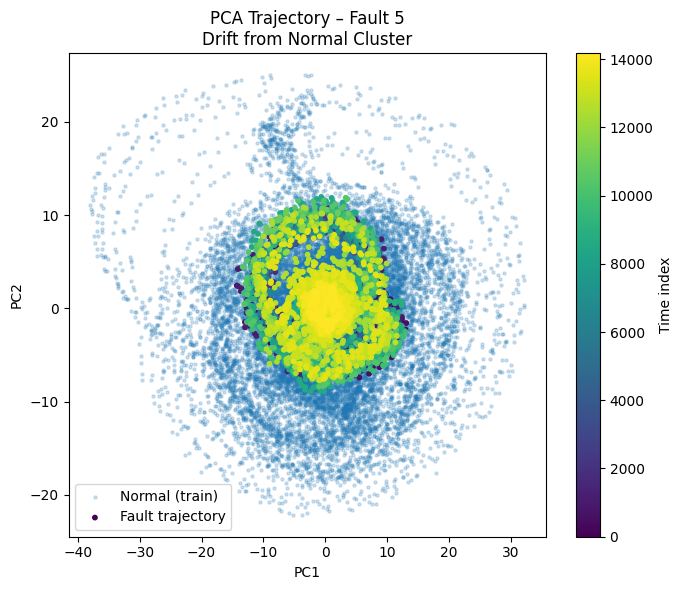

In [395]:
# PCA Trajectory (PC1-PC2)

T_train_pca = pca.transform(X_train_normal_std)             
T_fault_pca = pca.transform(X_faulty_std[fault_to_plot])      

pc1_norm, pc2_norm = T_train_pca[:, 0], T_train_pca[:, 1]
pc1_fault, pc2_fault = T_fault_pca[:, 0], T_fault_pca[:, 1]

time_idx_fault = np.arange(len(pc1_fault))

plt.figure(figsize=(7, 6))

# Normal cluster (light/transparent)
plt.scatter(
    pc1_norm, pc2_norm,
    s=5, alpha=0.2, label="Normal (train)"
)

# Fault trajectory colored by time
scatter = plt.scatter(
    pc1_fault, pc2_fault,
    c=time_idx_fault, cmap="viridis",
    s=10, label="Fault trajectory"
)

plt.colorbar(scatter, label="Time index")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title(f"PCA Trajectory – Fault {fault_to_plot}\nDrift from Normal Cluster")
plt.legend()
plt.tight_layout()
plt.show()

### 7.1.2 DPCA Trajectory (Dynamic PC1–PC2)

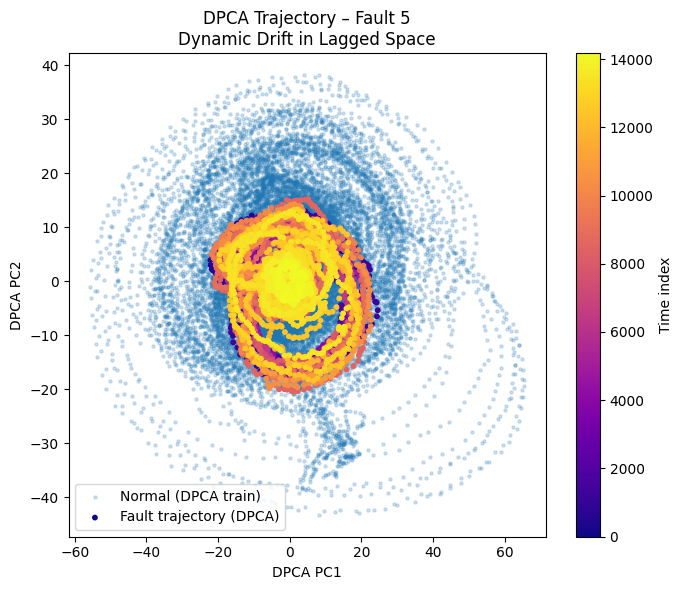

In [396]:
# DPCA Trajectory (Dynamic PC1–PC2)

# DPCA scores for normal and fault
T_train_dpca = pca_dpca.transform(X_train_dpca)
T_fault_dpca = pca_dpca.transform(X_faulty_dpca[fault_to_plot])

dp1_norm, dp2_norm = T_train_dpca[:, 0], T_train_dpca[:, 1]
dp1_fault, dp2_fault = T_fault_dpca[:, 0], T_fault_dpca[:, 1]

time_idx_fault_dpca = np.arange(len(dp1_fault))

plt.figure(figsize=(7, 6))

# Normal DPCA cluster
plt.scatter(
    dp1_norm, dp2_norm,
    s=5, alpha=0.2, label="Normal (DPCA train)"
)

# Fault DPCA trajectory
scatter = plt.scatter(
    dp1_fault, dp2_fault,
    c=time_idx_fault_dpca, cmap="plasma",
    s=10, label="Fault trajectory (DPCA)"
)

plt.colorbar(scatter, label="Time index")

plt.xlabel("DPCA PC1")
plt.ylabel("DPCA PC2")
plt.title(f"DPCA Trajectory – Fault {fault_to_plot}\nDynamic Drift in Lagged Space")
plt.legend()
plt.tight_layout()
plt.show()

### 7.1.3 CVA Trajectory (Canonical State 1–2)

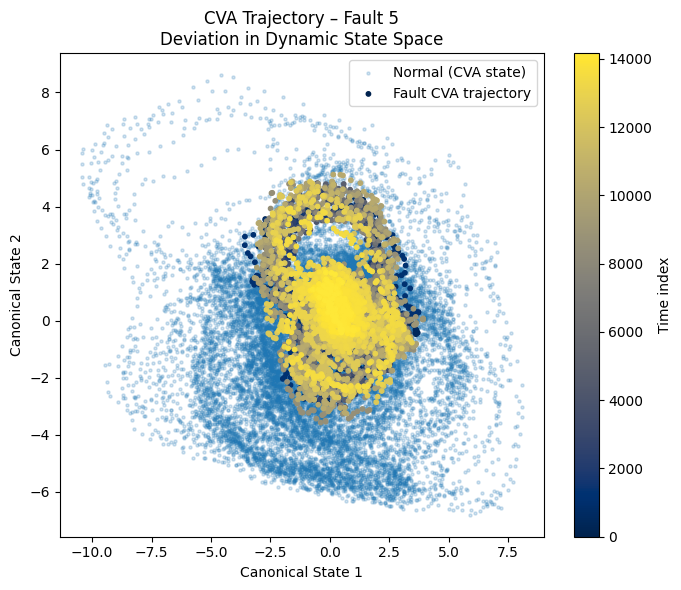

In [397]:
A = cva_model["A"]
mean_P = cva_model["mean_P"]
p = cva_model["p"]
f = cva_model["f"]

# Normal CVA trajectory (from training)
X_train_np = X_train_normal_std.values
P_train, F_train = build_hankel(X_train_np, p=p, f=f)
P0_train = P_train - mean_P
Z_train_cva = P0_train @ A          
z1_norm, z2_norm = Z_train_cva[:, 0], Z_train_cva[:, 1]

# Fault CVA trajectory
X_fault_np = X_faulty_std[fault_to_plot].values
P_fault, F_fault = build_hankel(X_fault_np, p=p, f=f)
P0_fault = P_fault - mean_P
Z_fault_cva = P0_fault @ A
z1_fault, z2_fault = Z_fault_cva[:, 0], Z_fault_cva[:, 1]

time_idx_fault_cva = np.arange(len(z1_fault))

plt.figure(figsize=(7, 6))

# Normal CVA state cluster
plt.scatter(
    z1_norm, z2_norm,
    s=5, alpha=0.2, label="Normal (CVA state)"
)

# Fault CVA state trajectory
scatter = plt.scatter(
    z1_fault, z2_fault,
    c=time_idx_fault_cva, cmap="cividis",
    s=10, label="Fault CVA trajectory"
)

plt.colorbar(scatter, label="Time index")

plt.xlabel("Canonical State 1")
plt.ylabel("Canonical State 2")
plt.title(f"CVA Trajectory – Fault {fault_to_plot}\nDeviation in Dynamic State Space")
plt.legend()
plt.tight_layout()
plt.show()

## 7.2 D-Index Evolution (CVDA Prognosis)
Here we track how the CVDA D-index changes over time for the selected fault and compare it against normal behaviour. Because the D-index reflects deviations in the process’s underlying dynamics, its growth pattern provides an early indication of how quickly the fault is progressing and how far the system has moved from normal operation. This time profile supports prognosis by showing when the fault becomes detectable, how rapidly it escalates, and how much warning time the monitoring framework can offer.

### 7.2.1 D-index vs time for Normal vs Fault

In [398]:
fault_slow = 2   
fault_fast = 5 
D_normal = compute_cvda_D(X_test_normal_std, cva_model)
D_slow = compute_cvda_D(X_faulty_std[fault_slow], cva_model)
D_fast = compute_cvda_D(X_faulty_std[fault_fast], cva_model)
print("D-limit (99% from normal):", D_lim)

D-limit (99% from normal): 9.143135381499773


### 7.2.2 Plot D-index Evolution – Normal vs Slow Fault

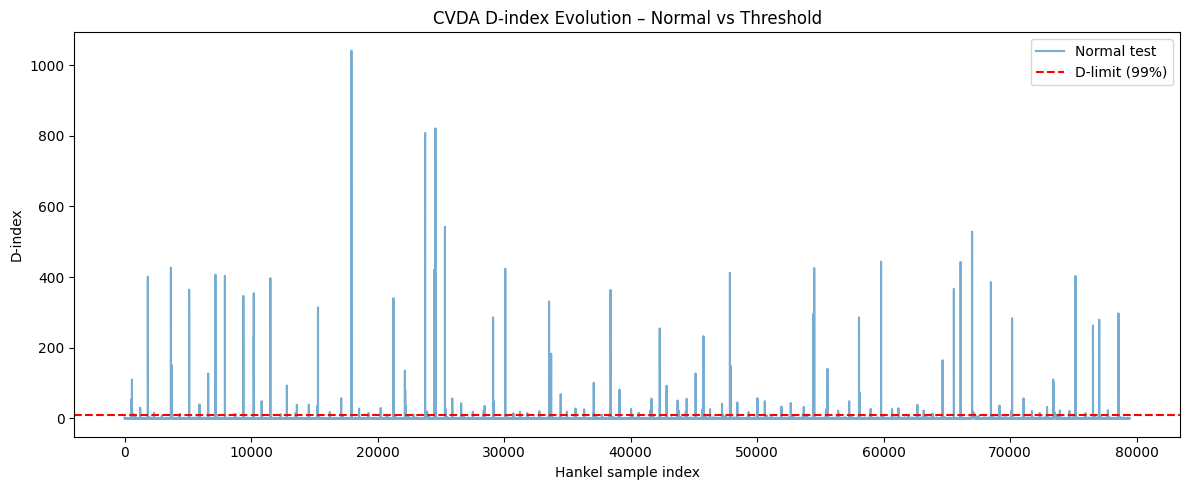

In [399]:
plt.figure(figsize=(12, 5))

plt.plot(D_normal, label="Normal test", alpha=0.6)
plt.axhline(D_lim, color="red", linestyle="--", label="D-limit (99%)")

plt.xlabel("Hankel sample index")
plt.ylabel("D-index")
plt.title("CVDA D-index Evolution – Normal vs Threshold")
plt.legend()
plt.tight_layout()
plt.show()

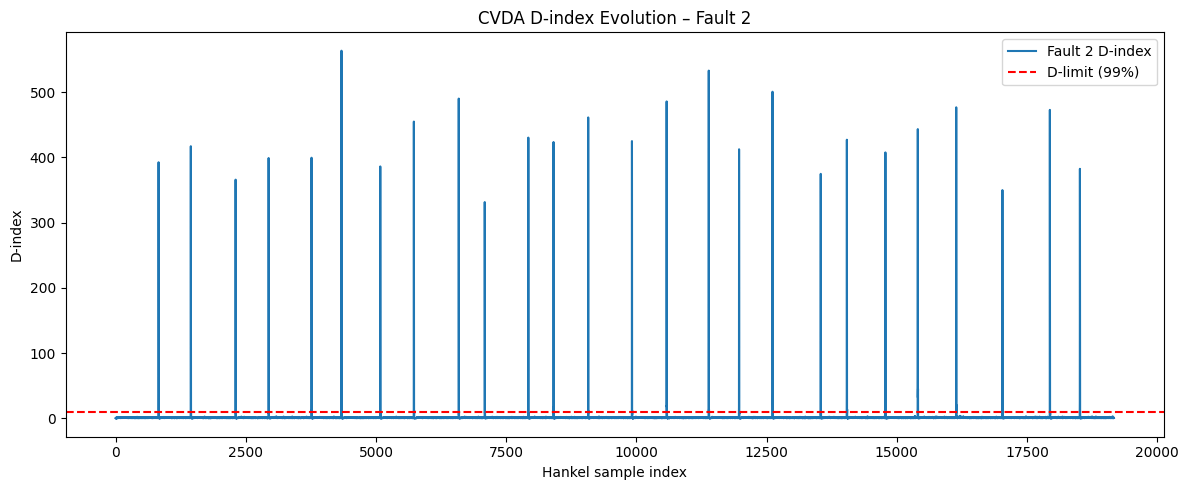

In [400]:
plt.figure(figsize=(12, 5))

plt.plot(D_slow, label=f"Fault {fault_slow} D-index")
plt.axhline(D_lim, color="red", linestyle="--", label="D-limit (99%)")

plt.xlabel("Hankel sample index")
plt.ylabel("D-index")
plt.title(f"CVDA D-index Evolution – Fault {fault_slow}")
plt.legend()
plt.tight_layout()
plt.show()

### 7.2.3 Compare Slow vs Abrupt Fault 

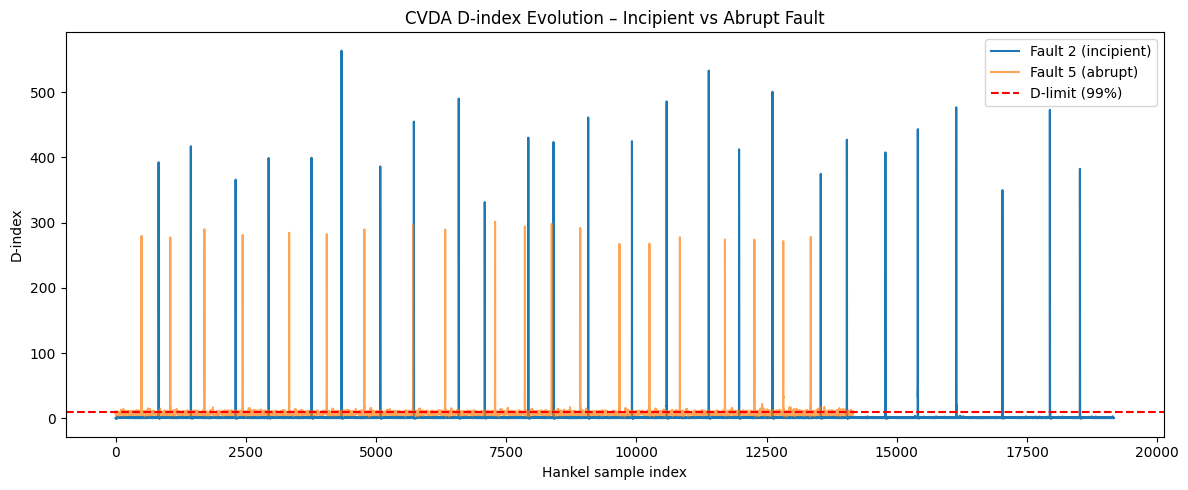

In [401]:
plt.figure(figsize=(12, 5))

plt.plot(D_slow, label=f"Fault {fault_slow} (incipient)")
plt.plot(D_fast, label=f"Fault {fault_fast} (abrupt)", alpha=0.7)
plt.axhline(D_lim, color="red", linestyle="--", label="D-limit (99%)")

plt.xlabel("Hankel sample index")
plt.ylabel("D-index")
plt.title("CVDA D-index Evolution – Incipient vs Abrupt Fault")
plt.legend()
plt.tight_layout()
plt.show()

### 7.2.4 Mark Detection Time

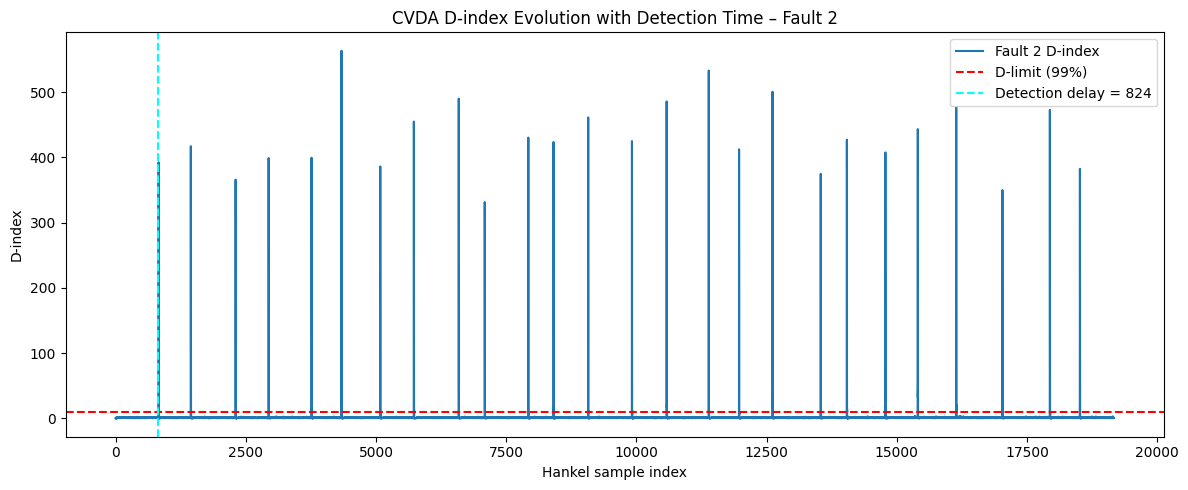

In [402]:
# Get detection delay from summary table
delay_slow = df_cvda_results.loc[
    df_cvda_results["Fault"] == fault_slow, "D_DetectionDelay"
].values[0]

plt.figure(figsize=(12, 5))

plt.plot(D_slow, label=f"Fault {fault_slow} D-index")
plt.axhline(D_lim, color="red", linestyle="--", label="D-limit (99%)")

if delay_slow is not None:
    plt.axvline(delay_slow, color="cyan", linestyle="--",
                label=f"Detection delay = {delay_slow}")

plt.xlabel("Hankel sample index")
plt.ylabel("D-index")
plt.title(f"CVDA D-index Evolution with Detection Time – Fault {fault_slow}")
plt.legend()
plt.tight_layout()
plt.show()

## 7.2.5 Prognosis Summary
This plot combines two complementary views of fault evolution. The left panel shows the PCA trajectory of the selected fault in the PC1–PC2 space, with color indicating time, to visualize how the process state drifts away from the normal region. The right panel shows the CVDA D-index over time, with its control limit, summarizing when the fault first becomes detectable and how rapidly it escalates. Together, these views provide an intuitive prognosis of both the direction and speed of degradation.

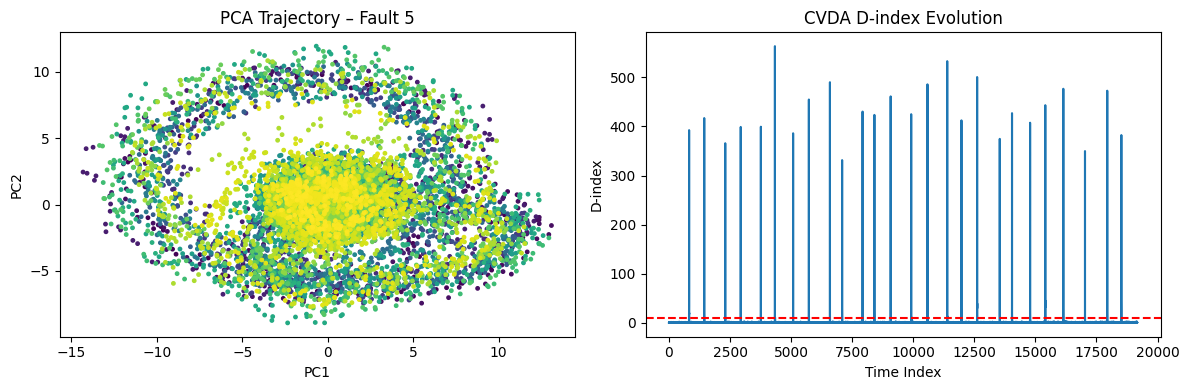

In [403]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.scatter(pc1_fault, pc2_fault, c=time_idx_fault, cmap="viridis", s=6)
plt.title(f"PCA Trajectory – Fault {fault_to_plot}")
plt.xlabel("PC1")
plt.ylabel("PC2")

plt.subplot(1, 2, 2)
plt.plot(D_slow, label=f"Fault {fault_slow}")
plt.axhline(D_lim, color="red", linestyle="--")
plt.title("CVDA D-index Evolution")
plt.xlabel("Time Index")
plt.ylabel("D-index")

plt.tight_layout()
plt.show()

# 8. Fault Detection: Has a Fault Occurred?
This section evaluates whether the process remains within its learned normal region or has transitioned into a faulty state. Using the monitoring statistics from PCA, DPCA, CVA, and CVDA, we compare test-normal behaviour against each fault scenario and check for limit violations. The goal is to answer the basic operational question—has something abnormal started to happen?—and to quantify how reliably and how early each method can flag that change.

## 8.1. PCA – Hotelling’s T² and Q (SPE) for Test Normal and Fault 3
In this section, we plot the PCA monitoring statistics T² and Q (SPE) for both the test-normal segment and Fault 3. By placing normal and fault trajectories side by side against their control limits, we can visually confirm that normal operation stays mostly within bounds, while Fault 3 produces clear, sustained exceedances. This illustrates how the PCA model distinguishes healthy behaviour from this specific fault and shows when alarms would be triggered in practice.

In [404]:
# PCA: Test Normal
T_test_pca, E_test_pca = compute_pca_scores_and_residuals(
    X_test_normal_std, pca
)
T2_test_pca = compute_T2(T_test_pca, pca.explained_variance_)
Q_test_pca  = compute_Q(E_test_pca)

# PCA: Fault 3 
Xf3 = X_faulty_std[fault_id]
T_fault3_pca, E_fault3_pca = compute_pca_scores_and_residuals(
    Xf3, pca
)
T2_fault3_pca = compute_T2(T_fault3_pca, pca.explained_variance_)
Q_fault3_pca  = compute_Q(E_fault3_pca)

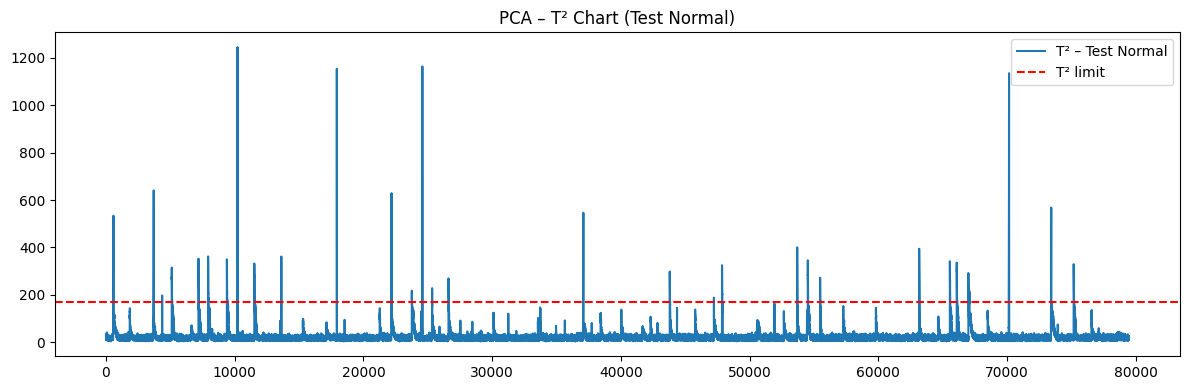

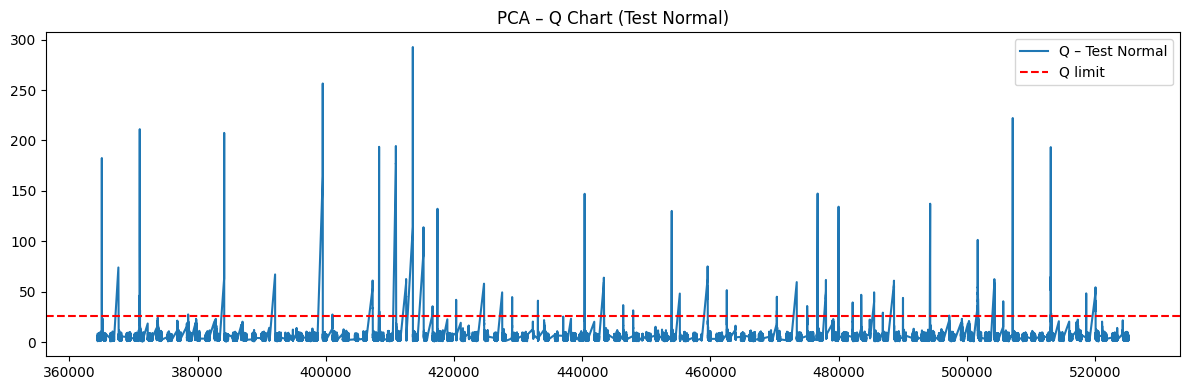

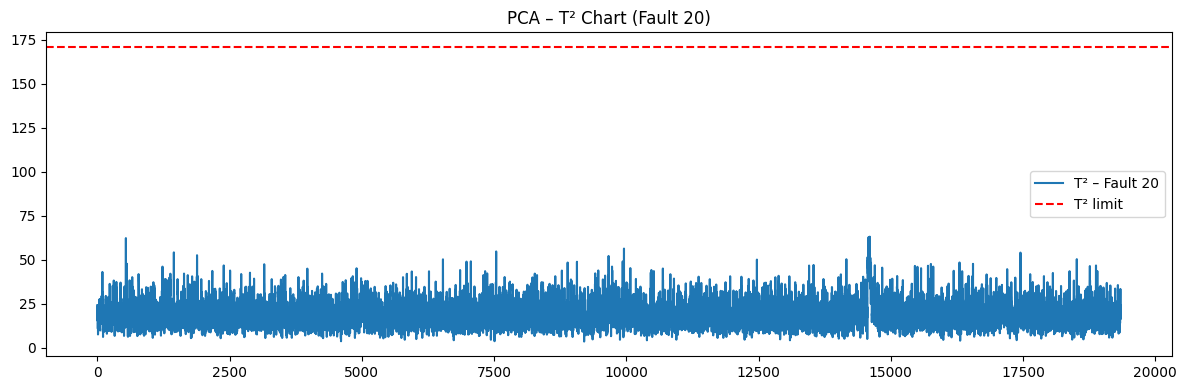

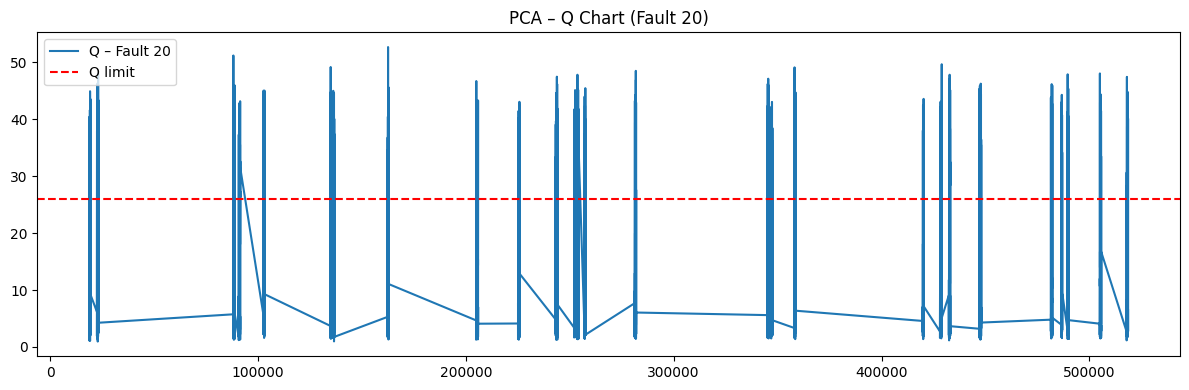

In [405]:
plt.figure(figsize=(12,4))
plt.plot(T2_test_pca, label="T² – Test Normal")
plt.axhline(T2_lim_final, color="red", linestyle="--", label="T² limit")
plt.title("PCA – T² Chart (Test Normal)")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(12,4))
plt.plot(Q_test_pca, label="Q – Test Normal")
plt.axhline(Q_lim_final, color="red", linestyle="--", label="Q limit")
plt.title("PCA – Q Chart (Test Normal)")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(12,4))
plt.plot(T2_fault3_pca, label=f"T² – Fault {fault_id}")
plt.axhline(T2_lim_final, color="red", linestyle="--", label="T² limit")
plt.title(f"PCA – T² Chart (Fault {fault_id})")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(12,4))
plt.plot(Q_fault3_pca, label=f"Q – Fault {fault_id}")
plt.axhline(Q_lim_final, color="red", linestyle="--", label="Q limit")
plt.title(f"PCA – Q Chart (Fault {fault_id})")
plt.legend()
plt.tight_layout()
plt.show()

In [406]:
# DPCA: Test Normal
T_test_dpca, E_test_dpca = compute_pca_scores_and_residuals(
    X_test_dpca, pca_dpca
)
T2_test_dpca = compute_T2(T_test_dpca, pca_dpca.explained_variance_)
Q_test_dpca  = compute_Q(E_test_dpca)

# DPCA: Fault 3
Xf3_dpca = X_faulty_dpca[fault_id]
T_fault3_dpca, E_fault3_dpca = compute_pca_scores_and_residuals(
    Xf3_dpca, pca_dpca
)
T2_fault3_dpca = compute_T2(T_fault3_dpca, pca_dpca.explained_variance_)
Q_fault3_dpca  = compute_Q(E_fault3_dpca)

## 8.2. CVA & CVDA – T² / Q / D-index for Test Normal and Fault 3
Here we compare CVA and CVDA monitoring statistics for the test-normal data and Fault 3. For CVA, we plot T² and Q to see how the canonical state deviates from normal; for CVDA, we plot the D-index and its control limit to highlight dynamic mismatches between predicted and actual future behaviour. Together, these charts show how state-space methods respond to Fault 3 versus normal operation, and whether they provide clearer or earlier separation than PCA alone.

In [407]:
# CVA T² and Q

# Make sure we have limits from training
T2_lim_cva = cva_model["T2_lim"]
Q_lim_cva  = cva_model["Q_lim"]

# CVA: Test Normal
T2_test_cva, Q_test_cva = cva_project(X_test_normal_std, cva_model)

# CVA: Fault 3
T2_fault3_cva, Q_fault3_cva = cva_project(X_faulty_std[fault_id], cva_model)

In [408]:
# CVDA D-index

# CVDA: Test Normal
D_test_cvda = compute_cvda_D(X_test_normal_std, cva_model)

# D-limit should already be computed from normal as:
# D_lim = np.quantile(D_test_cvda, 0.99)
# but in case it's already defined we just trust D_lim.

# CVDA: Fault 3
D_fault3_cvda = compute_cvda_D(X_faulty_std[fault_id], cva_model)

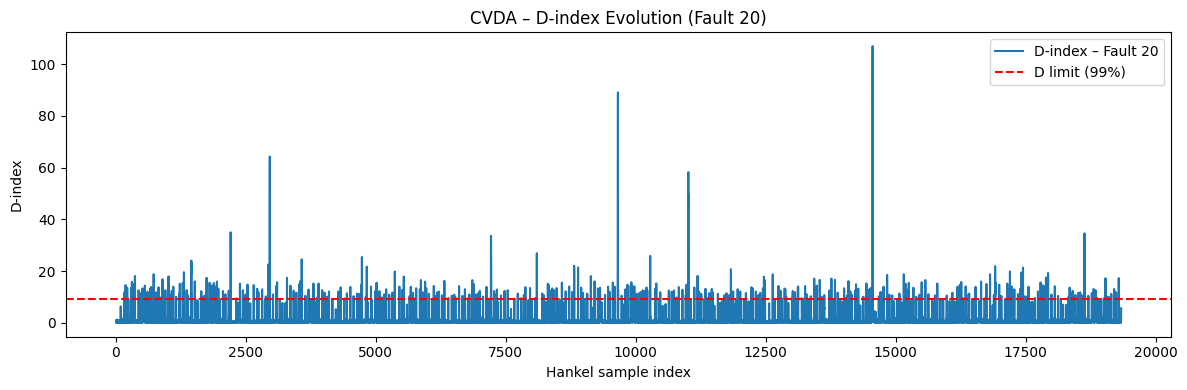

In [409]:
# Optional plots
plt.figure(figsize=(12,4))
plt.plot(D_fault3_cvda, label=f"D-index – Fault {fault_id}")
plt.axhline(D_lim, color="red", linestyle="--", label="D limit (99%)")
plt.title(f"CVDA – D-index Evolution (Fault {fault_id})")
plt.xlabel("Hankel sample index")
plt.ylabel("D-index")
plt.legend()
plt.tight_layout()
plt.show()

## 8.3. Summary Table for Fault 3 (PCA, DPCA, CVA, CVDA)

In [410]:
# Helper for detection delay

def detection_delay(sequence, limit):
    """
    First time index where sequence exceeds limit.
    Returns None if never crosses.
    """
    idx = np.where(sequence > limit)[0]
    return None if len(idx) == 0 else int(idx[0])

In [411]:
# Build metrics row by row

rows = []

# PCA 
rows.append({
    "Method": "PCA",
    "Metric": "T2",
    "Threshold": T2_lim_final,
    "FPR_Normal": float(np.mean(T2_test_pca > T2_lim_final)),
    "DetectionRate_Fault3": float(np.mean(T2_fault3_pca > T2_lim_final)),
    "DetectionDelay_Fault3": detection_delay(T2_fault3_pca, T2_lim_final),
})

rows.append({
    "Method": "PCA",
    "Metric": "Q",
    "Threshold": Q_lim_final,
    "FPR_Normal": float(np.mean(Q_test_pca > Q_lim_final)),
    "DetectionRate_Fault3": float(np.mean(Q_fault3_pca > Q_lim_final)),
    "DetectionDelay_Fault3": detection_delay(Q_fault3_pca, Q_lim_final),
})


#  DPCA 
rows.append({
    "Method": "DPCA",
    "Metric": "T2",
    "Threshold": T2_lim_dpca,
    "FPR_Normal": float(np.mean(T2_test_dpca > T2_lim_dpca)),
    "DetectionRate_Fault3": float(np.mean(T2_fault3_dpca > T2_lim_dpca)),
    "DetectionDelay_Fault3": detection_delay(T2_fault3_dpca, T2_lim_dpca),
})

rows.append({
    "Method": "DPCA",
    "Metric": "Q",
    "Threshold": Q_lim_dpca,
    "FPR_Normal": float(np.mean(Q_test_dpca > Q_lim_dpca)),
    "DetectionRate_Fault3": float(np.mean(Q_fault3_dpca > Q_lim_dpca)),
    "DetectionDelay_Fault3": detection_delay(Q_fault3_dpca, Q_lim_dpca),
})


#  CVA
rows.append({
    "Method": "CVA",
    "Metric": "T2",
    "Threshold": T2_lim_cva,
    "FPR_Normal": float(np.mean(T2_test_cva > T2_lim_cva)),
    "DetectionRate_Fault3": float(np.mean(T2_fault3_cva > T2_lim_cva)),
    "DetectionDelay_Fault3": detection_delay(T2_fault3_cva, T2_lim_cva),
})

rows.append({
    "Method": "CVA",
    "Metric": "Q",
    "Threshold": Q_lim_cva,
    "FPR_Normal": float(np.mean(Q_test_cva > Q_lim_cva)),
    "DetectionRate_Fault3": float(np.mean(Q_fault3_cva > Q_lim_cva)),
    "DetectionDelay_Fault3": detection_delay(Q_fault3_cva, Q_lim_cva),
})


# CVDA
rows.append({
    "Method": "CVDA",
    "Metric": "D-index",
    "Threshold": D_lim,
    "FPR_Normal": float(np.mean(D_test_cvda > D_lim)),
    "DetectionRate_Fault3": float(np.mean(D_fault3_cvda > D_lim)),
    "DetectionDelay_Fault3": detection_delay(D_fault3_cvda, D_lim),
})

fault3_detection_summary = pd.DataFrame(rows)
fault3_detection_summary


Method   Metric    Threshold  FPR_Normal  DetectionRate_Fault3  \
0    PCA       T2   170.868706    0.007915              0.000000   
1    PCA        Q    26.036609    0.008355              0.087455   
2   DPCA       T2   217.027348    0.009991              0.000000   
3   DPCA        Q    37.388378    0.010658              0.239442   
4    CVA       T2   217.379165    0.010055              0.000000   
5    CVA        Q  5537.210610    0.010294              0.000000   
6   CVDA  D-index     9.143135    0.010004              0.024201   

   DetectionDelay_Fault3  
0                    NaN  
1                   91.0  
2                    NaN  
3                   79.0  
4                    NaN  
5                    NaN  
6                  162.0

## 8.4 DPCA – Hotelling’s T² and Q (SPE) for Fault 2

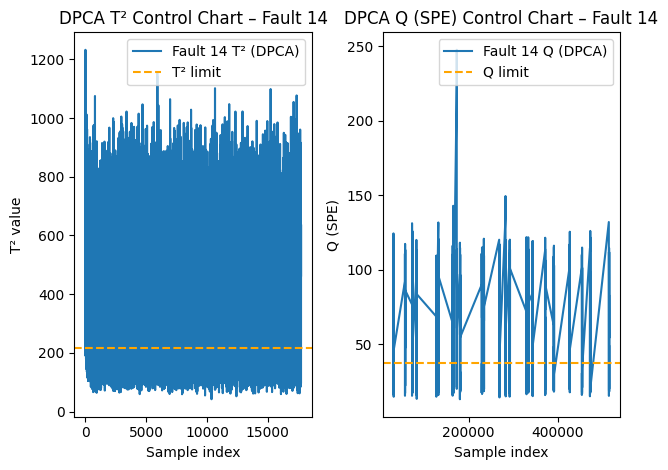

In [412]:
fault_id = 14  # Fault 2

# Get DPCA inputs for Fault 2
Xf_dpca = X_faulty_dpca[fault_id]

# Scores and residuals for DPCA
T_f_dpca, E_f_dpca = compute_pca_scores_and_residuals(Xf_dpca, pca_dpca)
eigvals_dpca = pca_dpca.explained_variance_

T2_f_dpca = compute_T2(T_f_dpca, eigvals_dpca)
Q_f_dpca  = compute_Q(E_f_dpca)

#  Plot DPCA T² and Q for Fault 2 

# T² chart
plt.subplot(1, 2, 1)
plt.plot(T2_f_dpca, label=f"Fault {fault_id} T² (DPCA)")
plt.axhline(T2_lim_dpca, color="orange", linestyle="--", label="T² limit")
plt.xlabel("Sample index")
plt.ylabel("T² value")
plt.title(f"DPCA T² Control Chart – Fault {fault_id}")
plt.legend()

# Q chart
plt.subplot(1, 2, 2)
plt.plot(Q_f_dpca, label=f"Fault {fault_id} Q (DPCA)")
plt.axhline(Q_lim_dpca, color="orange", linestyle="--", label="Q limit")
plt.xlabel("Sample index")
plt.ylabel("Q (SPE)")
plt.title(f"DPCA Q (SPE) Control Chart – Fault {fault_id}")
plt.legend()

plt.tight_layout()
plt.show()

## 8.5 CVA – Hotelling’s T² and Q (SPE) for Fault 2

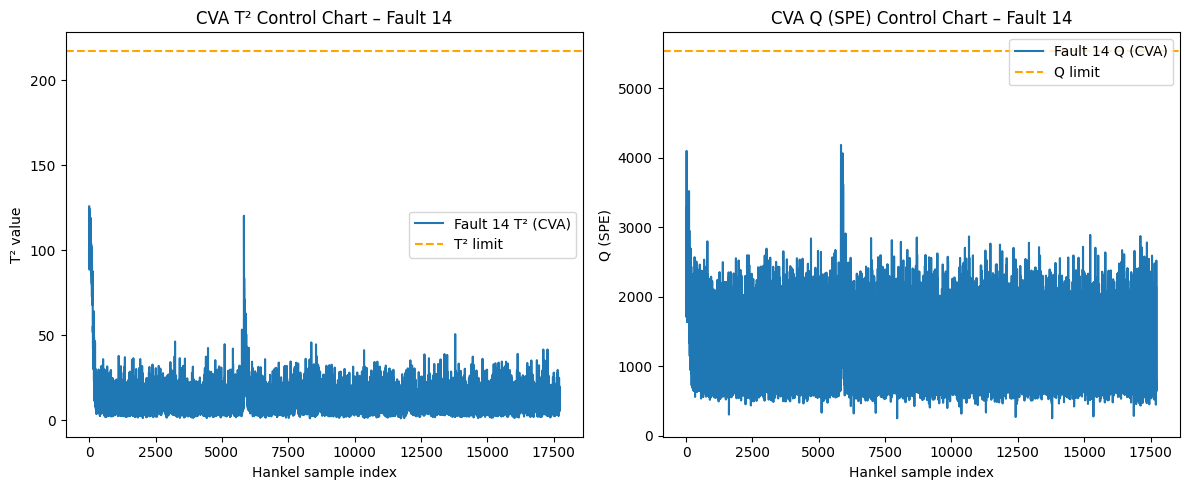

In [413]:
# CVA limits from training
T2_lim_cva = cva_model["T2_lim"]
Q_lim_cva  = cva_model["Q_lim"]

# CVA T² and Q for Fault 2
Xf_std = X_faulty_std[fault_id]
T2_f_cva, Q_f_cva = cva_project(Xf_std, cva_model)

plt.figure(figsize=(12, 5))

# T² chart
plt.subplot(1, 2, 1)
plt.plot(T2_f_cva, label=f"Fault {fault_id} T² (CVA)")
plt.axhline(T2_lim_cva, color="orange", linestyle="--", label="T² limit")
plt.xlabel("Hankel sample index")
plt.ylabel("T² value")
plt.title(f"CVA T² Control Chart – Fault {fault_id}")
plt.legend()

# Q chart
plt.subplot(1, 2, 2)
plt.plot(Q_f_cva, label=f"Fault {fault_id} Q (CVA)")
plt.axhline(Q_lim_cva, color="orange", linestyle="--", label="Q limit")
plt.xlabel("Hankel sample index")
plt.ylabel("Q (SPE)")
plt.title(f"CVA Q (SPE) Control Chart – Fault {fault_id}")
plt.legend()

plt.tight_layout()
plt.show()

## 8.6 CVDA – D-Index Evolution for Fault 2

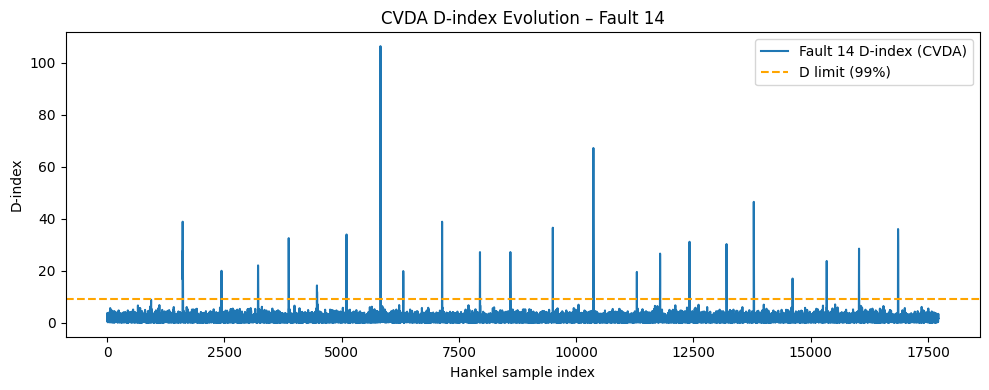

In [414]:
D_f2 = compute_cvda_D(X_faulty_std[fault_id], cva_model)

plt.figure(figsize=(10, 4))
plt.plot(D_f2, label=f"Fault {fault_id} D-index (CVDA)")
plt.axhline(D_lim, color="orange", linestyle="--", label="D limit (99%)")
plt.xlabel("Hankel sample index")
plt.ylabel("D-index")
plt.title(f"CVDA D-index Evolution – Fault {fault_id}")
plt.legend()
plt.tight_layout()
plt.show()

# 9. Fault Diagnosis: Where did it occur?
In this final section, we focus on localizing the detected fault: using PCA/DPCA/CVA/CVDA contribution plots and time-resolved visualizations, we identify which variables or latent states are most responsible and interpret these patterns in terms of specific process units or operating conditions, turning abstract alarms into concrete hypotheses about where in the plant the disturbance originates.

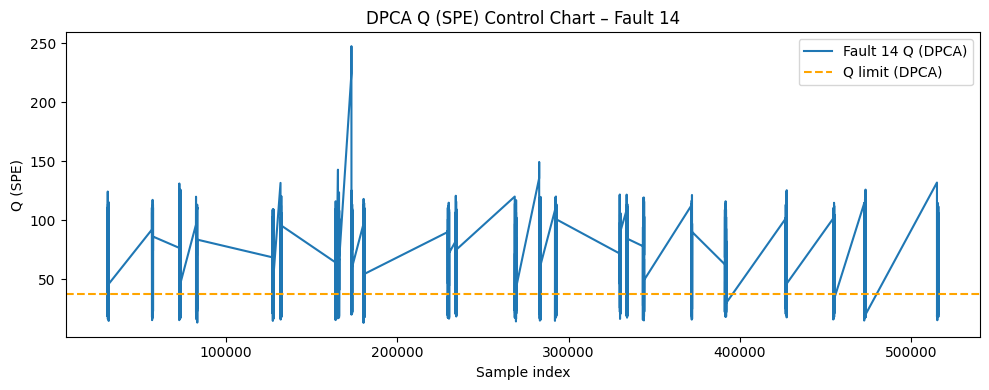

In [415]:
# DPCA Q Chart for Fault 2 (Severity)

# Choose Fault 2
fault_id = 14

# Get DPCA-embedded data for Fault 2
Xf_dpca = X_faulty_dpca[fault_id]

# Scores and residuals for DPCA
T_f_dpca, E_f_dpca = compute_pca_scores_and_residuals(Xf_dpca, pca_dpca)
eigvals_dpca = pca_dpca.explained_variance_

T2_f_dpca = compute_T2(T_f_dpca, eigvals_dpca)
Q_f_dpca  = compute_Q(E_f_dpca)

plt.figure(figsize=(10, 4))
plt.plot(Q_f_dpca, label=f"Fault {fault_id} Q (DPCA)")
plt.axhline(Q_lim_dpca, color="orange", linestyle="--", label="Q limit (DPCA)")
plt.xlabel("Sample index")
plt.ylabel("Q (SPE)")
plt.title(f"DPCA Q (SPE) Control Chart – Fault {fault_id}")
plt.legend()
plt.tight_layout()
plt.show()

In [416]:
# DPCA Q-Contributions for Fault 2

# Q contributions: squared residuals per variable
Q_contrib_dpca = E_f_dpca ** 2

# Put into DataFrame for convenience
Q_contrib_dpca_df = pd.DataFrame(Q_contrib_dpca, columns=Xf_dpca.columns)

Q_contrib_dpca_df.head()

XMEAS(1)  XMEAS(2)  XMEAS(3)  XMEAS(4)  XMEAS(5)  XMEAS(6)  XMEAS(7)  \
30673  0.432887  0.111490  0.040118  0.003737  0.007094  0.008676  0.023946   
30674  0.000339  0.047784  0.001755  0.154512  0.000142  0.005700  0.024010   
30675  0.015398  0.116604  0.440337  0.034890  0.000239  0.006154  0.009660   
30676  0.015319  0.466728  0.004530  0.000078  0.002696  0.015486  0.028648   
30677  0.791785  0.095048  0.208174  0.010405  0.002569  0.027578  0.003393   

           XMEAS(8)  XMEAS(9)  XMEAS(10)  ...  XMV(2)_lag2  XMV(3)_lag2  \
30673  9.710251e-02  1.495619   0.564247  ...     0.204728     1.160832   
30674  2.018139e-07  0.027332   0.251986  ...     0.052535     0.001735   
30675  5.529370e-01  0.276960   0.661241  ...     0.001573     0.032119   
30676  4.862129e-02  0.387236   0.751592  ...     0.007870     0.109052   
30677  2.564466e-01  0.278664   0.558352  ...     0.279330     1.655506   

       XMV(4)_lag2  XMV(5)_lag2  XMV(6)_lag2  XMV(7)_lag2  XMV(8)_lag2  \
30673     0.002747     0.000358     0.259005     0.000753     0.000019   
30674     0.000236     0.001194     0.198689     0.000474     0.000076   
30675     0.008268     0.000018     0.265095     0.000007     0.000011   
30676     0.000020     0.023441     0.895163     0.000264     0.000125   
30677     0.000033     0.002913     0.210600     0.000624     0.000287   

       XMV(9)_lag2  XMV(10)_lag2  XMV(11)_lag2  
30673     0.000731      2.381079      0.000046  
30674     0.000443      0.085683      0.002620  
30675     0.000658      1.511954      0.002583  
30676     0.001247      2.444347      0.000595  
30677     0.000705      3.199143      0.007297  

[5 rows x 156 columns]

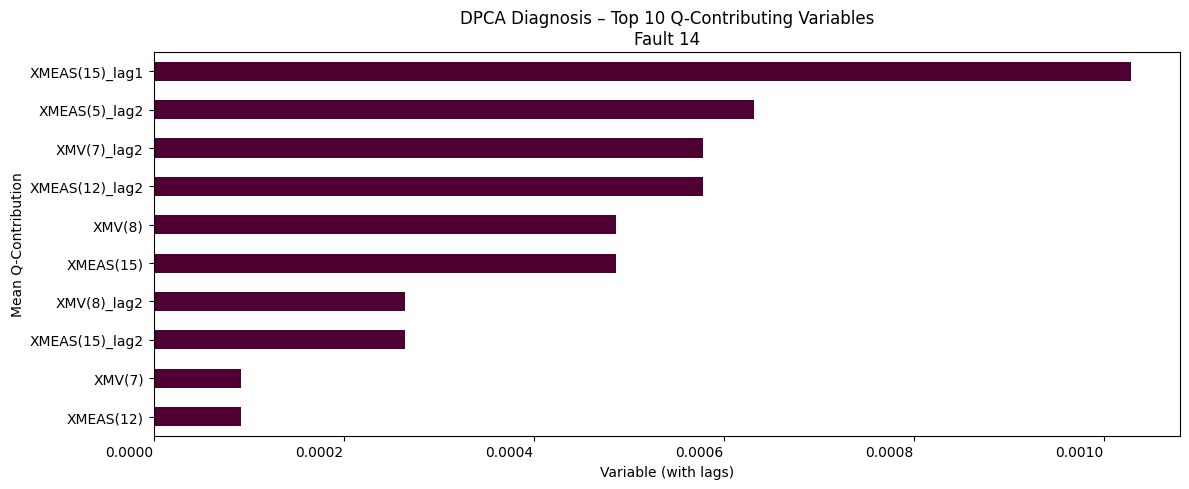

In [417]:
# Bar Plot – Top Contributing Variables

# Mean contribution per variable across time
mean_contrib_dpca = Q_contrib_dpca_df.mean().sort_values(ascending=True)

top_k = 10 
top_vars_dpca = mean_contrib_dpca.head(top_k)

plt.figure(figsize=(12, 5))
top_vars_dpca.plot(kind="barh", color='#4d0031')
plt.title(f"DPCA Diagnosis – Top {top_k} Q-Contributing Variables\nFault {fault_id}")
plt.ylabel("Mean Q-Contribution")
plt.xlabel("Variable (with lags)")
plt.xticks(rotation=0, ha="right")
plt.tight_layout()
plt.show()

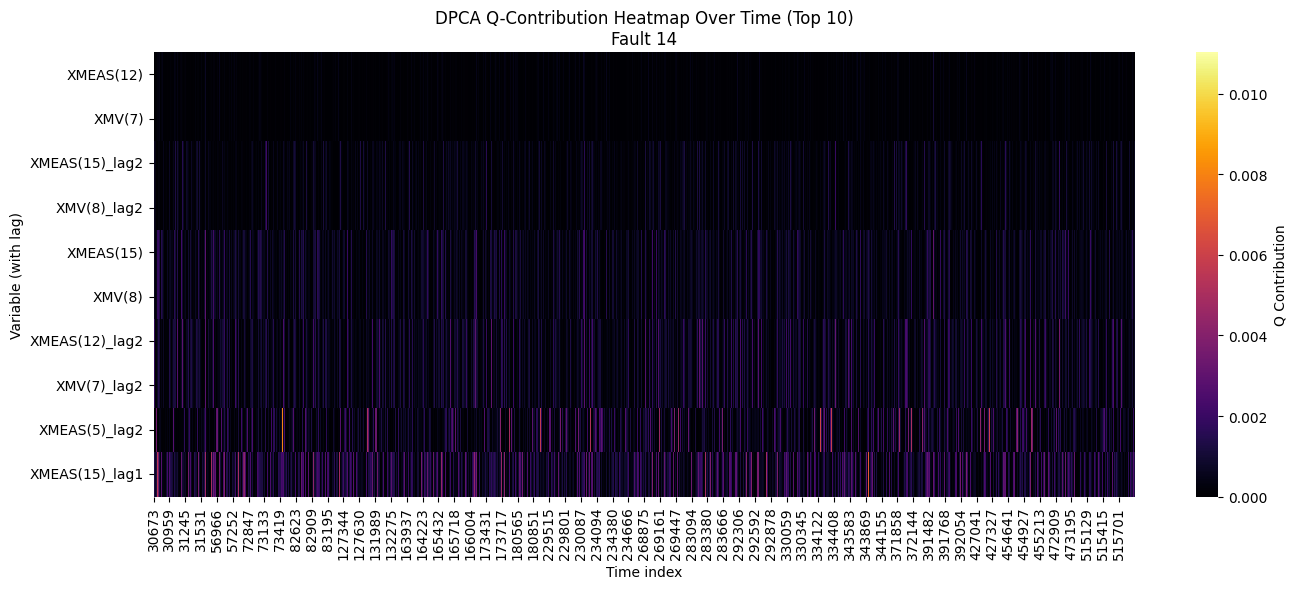

In [418]:
# Heatmap – Contributions Over Time (How it evolves)

plt.figure(figsize=(14, 6))

sns.heatmap(
    Q_contrib_dpca_df[top_vars_dpca.index].T,
    cmap="inferno",
    cbar_kws={"label": "Q Contribution"},
)

plt.title(f"DPCA Q-Contribution Heatmap Over Time (Top {top_k})\nFault {fault_id}")
plt.xlabel("Time index")
plt.ylabel("Variable (with lag)")
plt.tight_layout()
plt.show()

# 10. Fault Prognosis: How will it progress in the future?
Here we interpret the latent trajectories and D-index evolution in terms of future risk. By analyzing how quickly the process state moves away from the normal region and how early the D-index crosses its limit, we infer whether the fault is likely to remain mild, worsen gradually, or escalate rapidly. This links the monitoring results to practical questions such as how much warning time is available, when interventions should be scheduled, and which faults require the most urgent response.

## 10.1 DPCA Trajectory Plot (PC1 vs PC2)

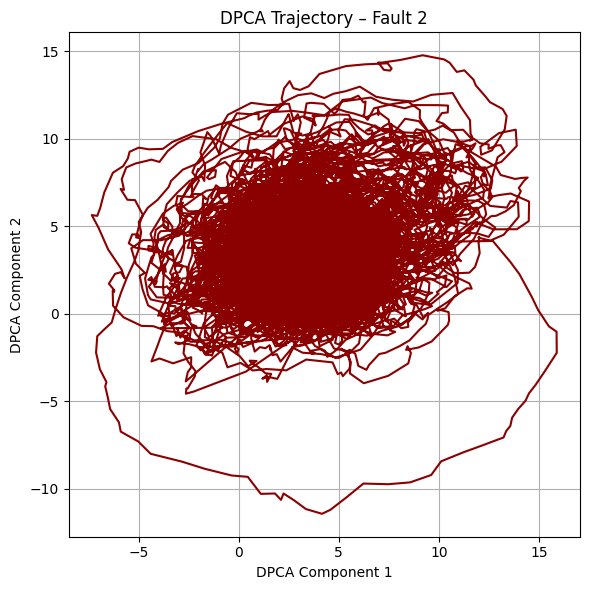

In [419]:
# DPCA scores for Fault 2
T_f_dpca, _ = compute_pca_scores_and_residuals(X_faulty_dpca[2], pca_dpca)

plt.figure(figsize=(6, 6))
plt.plot(T_f_dpca[:,0], T_f_dpca[:,1], color="darkred")
plt.title("DPCA Trajectory – Fault 2")
plt.xlabel("DPCA Component 1")
plt.ylabel("DPCA Component 2")
plt.grid(True)
plt.tight_layout()
plt.show()


## 10.2 CVA Trajectory Plot (CV1 vs CV2)

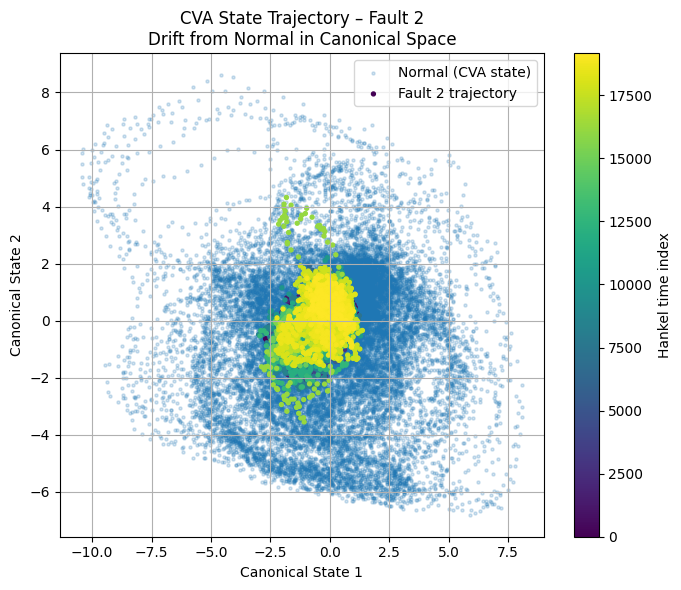

In [420]:
def compute_cva_states(X_df, cva_model):
    """
    Compute CVA canonical state trajectories Z from a standardized dataframe X_df.

    Uses the past Hankel matrix P:
        1. Build Hankel P, F using window sizes p, f
        2. Center P with training mean_P
        3. Project P0 into canonical space using A

    Returns:
        Z : array of shape (n_hankel_samples, n_canonical_vars)
    """
    A = cva_model["A"]       
    p = cva_model["p"]      
    f = cva_model["f"]       
    mean_P = cva_model["mean_P"]  
   
    X = X_df.values
    P, F = build_hankel(X, p=p, f=f)
    P0 = P - mean_P
    Z = P0 @ A
    return Z

fault_id = 2

Z_norm = compute_cva_states(X_train_normal_std, cva_model)
Z_fault2 = compute_cva_states(X_faulty_std[fault_id], cva_model)

time_idx_fault = np.arange(Z_fault2.shape[0])

plt.figure(figsize=(7, 6))

# Normal cluster (faded)
plt.scatter(
    Z_norm[:, 0], Z_norm[:, 1],
    s=5, alpha=0.2, label="Normal (CVA state)"
)

# Fault 2 trajectory (colored by time)
scatter = plt.scatter(
    Z_fault2[:, 0], Z_fault2[:, 1],
    c=time_idx_fault,
    cmap="viridis",
    s=8,
    label="Fault 2 trajectory"
)

plt.colorbar(scatter, label="Hankel time index")

plt.title("CVA State Trajectory – Fault 2\nDrift from Normal in Canonical Space")
plt.xlabel("Canonical State 1")
plt.ylabel("Canonical State 2")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## 10.3 CVDA D-Index Evolution
In this subsection, we track the CVDA D-index over time for selected faults and compare it with normal operation. The shape and timing of D-index exceedances summarize how early each fault becomes detectable and how aggressively its dynamics deviate from the learned normal behaviour, providing a compact prognosis signal.

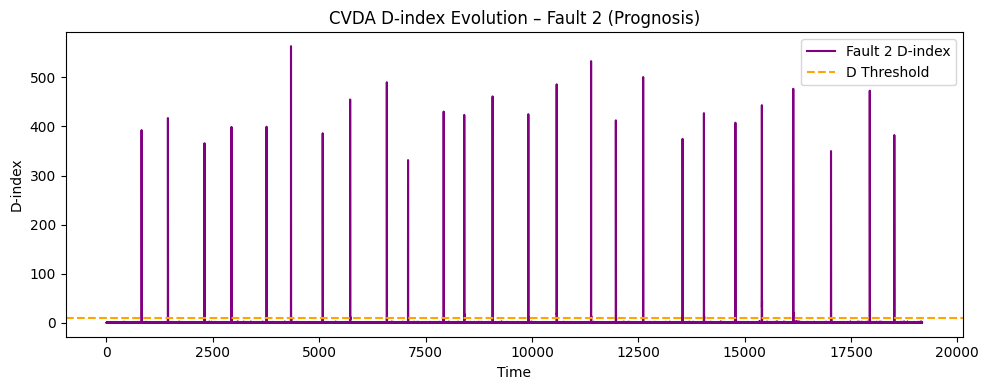

In [421]:
D_f2 = compute_cvda_D(X_faulty_std[2], cva_model)

plt.figure(figsize=(10, 4))
plt.plot(D_f2, label="Fault 2 D-index", color="purple")
plt.axhline(D_lim, color="orange", linestyle="--", label="D Threshold")
plt.title("CVDA D-index Evolution – Fault 2 (Prognosis)")
plt.xlabel("Time")
plt.ylabel("D-index")
plt.legend()
plt.tight_layout()
plt.show()

Fault 2 detection delay (CVDA): 824


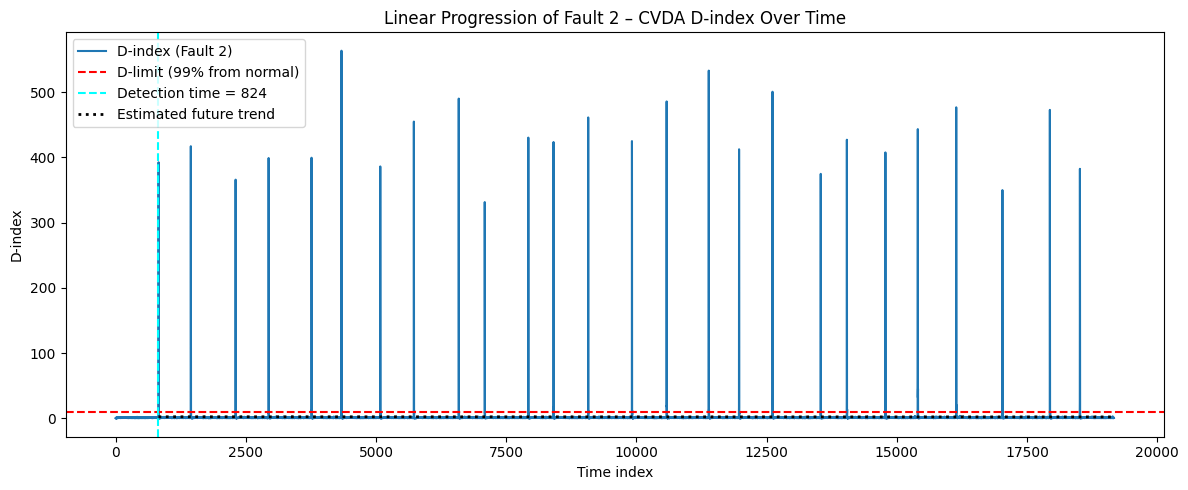

In [422]:
fault_id = 2
D_f2 = compute_cvda_D(X_faulty_std[fault_id], cva_model)  

N = len(D_f2)
t = np.arange(N)  

# D-limit (already computed from normal)
# D_lim = np.quantile(D_test_cvda, 0.99) 

def detection_delay(sequence, limit):
    idx = np.where(sequence > limit)[0]
    return None if len(idx) == 0 else int(idx[0])

delay_f2 = detection_delay(D_f2, D_lim)

print(f"Fault 2 detection delay (CVDA): {delay_f2}")

#  Fit a simple trend line AFTER detection 
if delay_f2 is not None:
    # Use points from detection onwards  for linear trend
    t_trend = t[delay_f2:]
    D_trend = D_f2[delay_f2:]

    # Simple linear regression: D ≈ a * t + b
    coeffs = np.polyfit(t_trend, D_trend, deg=1)
    a, b = coeffs
    D_fit = a * t_trend + b
else:
    t_trend = None
    D_fit = None

#  Plot D-index progression with threshold + trend 
plt.figure(figsize=(12, 5))

plt.plot(t, D_f2, label="D-index (Fault 2)", linewidth=1.5)

# Threshold line
plt.axhline(D_lim, color="red", linestyle="--", label="D-limit (99% from normal)")

# Mark detection time
if delay_f2 is not None:
    plt.axvline(delay_f2, color="cyan", linestyle="--",
                label=f"Detection time = {delay_f2}")

# Trend line for "future progression"
if D_fit is not None:
    plt.plot(t_trend, D_fit, color="black", linestyle=":",
             linewidth=2, label="Estimated future trend")

plt.xlabel("Time index")
plt.ylabel("D-index")
plt.title("Linear Progression of Fault 2 – CVDA D-index Over Time")
plt.legend()
plt.tight_layout()
plt.show()

Detection index for Fault 2: 824


/var/folders/30/grpl6qtd129fw1d9qgf71z9r0000gn/T/ipykernel_872/3257441099.py:8: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  timestamps = pd.date_range(


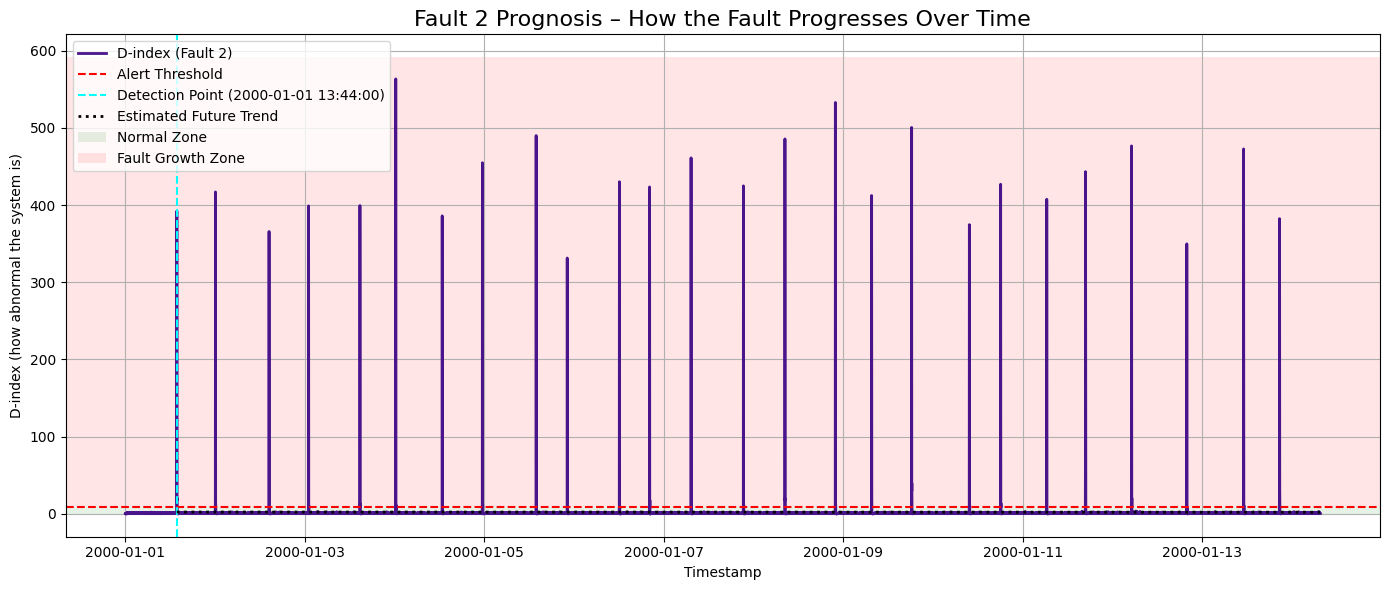

In [423]:
fault_id = 2
D_f2 = compute_cvda_D(X_faulty_std[fault_id], cva_model)
N = len(D_f2)

if isinstance(X_faulty_std[fault_id].index, pd.DatetimeIndex):
    timestamps = X_faulty_std[fault_id].index
else:
    timestamps = pd.date_range(
        start="2000-01-01 00:00:00",
        periods=N,
        freq="T" 
    )
def find_detection_point(values, threshold):
    values = np.asarray(values).ravel()
    idx = np.where(values > threshold)[0]
    if len(idx) == 0:
        return None
    return int(idx[0])

det_idx = find_detection_point(D_f2, D_lim)
print("Detection index for Fault 2:", det_idx)

D_future = None
t_trend = None

if det_idx is not None and det_idx < N - 10:
    D_trend = np.asarray(D_f2[det_idx:], dtype=float).ravel()
    t_trend = np.arange(len(D_trend))
    slope, intercept = np.polyfit(t_trend, D_trend, deg=1)
    D_future = slope * t_trend + intercept

plt.figure(figsize=(14, 6))

# D-index curve
plt.plot(timestamps, D_f2, label="D-index (Fault 2)", color="#4a148c", linewidth=2)

# Threshold line
plt.axhline(D_lim, color="red", linestyle="--", label="Alert Threshold")

# Detection vertical line
if det_idx is not None:
    plt.axvline(
        timestamps[det_idx],
        color="cyan",
        linestyle="--",
        label=f"Detection Point ({timestamps[det_idx]})"
    )

if D_future is not None and t_trend is not None:
    trend_timestamps = timestamps[det_idx:det_idx + len(t_trend)]
    plt.plot(
        trend_timestamps,
        D_future,
        linestyle=":",
        color="black",
        linewidth=2,
        label="Estimated Future Trend"
    )

plt.axhspan(min(D_f2), D_lim, facecolor='green', alpha=0.10, label="Normal Zone")
plt.axhspan(D_lim, max(D_f2) * 1.05, facecolor='red', alpha=0.10, label="Fault Growth Zone")

plt.title("Fault 2 Prognosis – How the Fault Progresses Over Time", fontsize=16)
plt.xlabel("Timestamp")
plt.ylabel("D-index (how abnormal the system is)")
plt.legend(loc="upper left")
plt.grid(True)
plt.tight_layout()
plt.show()

Detection index for Fault 2 (DPCA-Q): 0


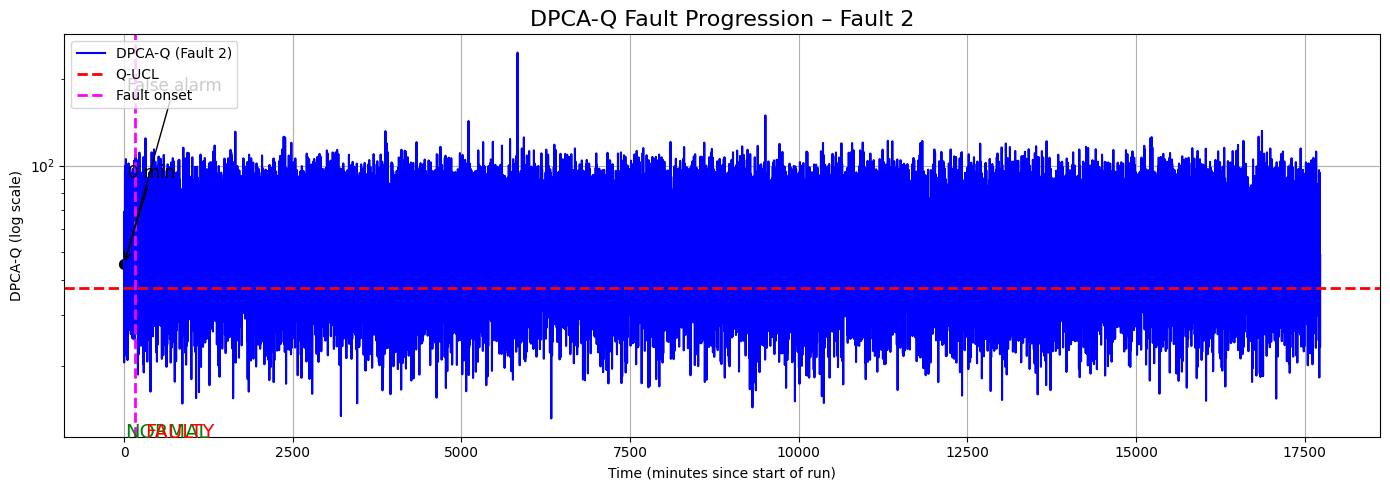

In [424]:
# GET DPCA Q for Fault 2
fault_id = 14
Xf_dpca = X_faulty_dpca[fault_id]
T_dpca, E_dpca = compute_pca_scores_and_residuals(Xf_dpca, pca_dpca)
Q_dpca_raw = compute_Q(E_dpca)
Q_dpca = np.asarray(Q_dpca_raw, dtype=float).ravel()
N = len(Q_dpca)
Q_limit = Q_lim_dpca  
time_minutes = np.arange(N)  

# Approximate fault onset in DPCA domain
fault_start = 160  # 

def find_first_crossing(values, threshold):
    values = np.asarray(values).ravel()
    idx = np.where(values > threshold)[0]
    return None if len(idx) == 0 else int(idx[0])

det_idx = find_first_crossing(Q_dpca, Q_limit)
print("Detection index for Fault 2 (DPCA-Q):", det_idx)
plt.figure(figsize=(14, 5))
plt.plot(time_minutes, Q_dpca, color='blue', linewidth=1.5, label='DPCA-Q (Fault 2)')
plt.yscale('log')

# Q control limit
plt.axhline(Q_limit, color='red', linestyle='--', linewidth=2, label='Q-UCL')

# Fault onset (magenta dashed line)
plt.axvline(fault_start, color='magenta', linestyle='--', linewidth=2,
            label='Fault onset')

# NORMAL / FAULTY labels
plt.text(20, Q_limit * 0.3, "NORMAL", color="green", fontsize=14)
plt.text(fault_start + 150, Q_limit * 0.3, "FAULTY", color="red", fontsize=14)

# Detection annotation 
if det_idx is not None and det_idx < N:
    plt.scatter(time_minutes[det_idx], Q_dpca[det_idx], color='black', s=50)
    plt.annotate(f"{int(time_minutes[det_idx])} min",
                 xy=(time_minutes[det_idx], Q_dpca[det_idx]),
                 xytext=(time_minutes[det_idx] + 60, Q_dpca[det_idx] * 2),
                 arrowprops=dict(facecolor='black', arrowstyle='->'),
                 fontsize=12)
false_alarm_idx = np.where((time_minutes < fault_start) & (Q_dpca > Q_limit))[0]
if len(false_alarm_idx) > 0:
    fa = int(false_alarm_idx[0])
    plt.scatter(time_minutes[fa], Q_dpca[fa], color='black')
    plt.annotate("False alarm",
                 xy=(time_minutes[fa], Q_dpca[fa]),
                 xytext=(time_minutes[fa] + 40, Q_dpca[fa] * 4),
                 arrowprops=dict(facecolor='black', arrowstyle='->'),
                 fontsize=12)

plt.title("DPCA-Q Fault Progression – Fault 2", fontsize=16)
plt.xlabel("Time (minutes since start of run)")
plt.ylabel("DPCA-Q (log scale)")
plt.grid(True)
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

# 11. Scree Plot/Cumulative Variance Plot
This is just a sanity check and a quick comparison on how scree plot looks for PCA and DPCA.

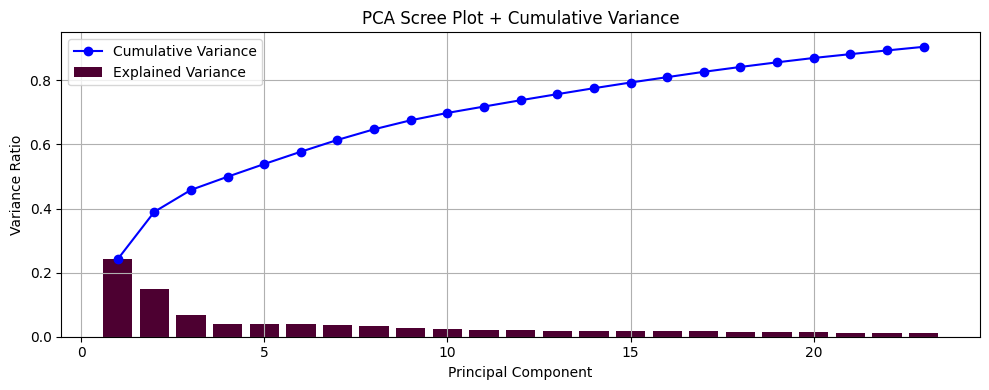

In [425]:
pca_candidates = [globals()[x] for x in globals().keys() if "pca" in x.lower()]
pca_static = None
for model in pca_candidates:
    if hasattr(model, "explained_variance_ratio_"):
        pca_static = model
        break

if pca_static is None:
    raise ValueError("No PCA model with explained_variance_ratio_ found. Check your PCA variable names.")

explained = pca_static.explained_variance_ratio_
cumvar = np.cumsum(explained)
k = np.arange(1, len(explained)+1)

plt.figure(figsize=(10, 4))
plt.bar(k, explained, label="Explained Variance", color='#4d0031')
plt.plot(k, cumvar, marker="o", color="blue", label="Cumulative Variance")
plt.xlabel("Principal Component")
plt.ylabel("Variance Ratio")
plt.title("PCA Scree Plot + Cumulative Variance")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

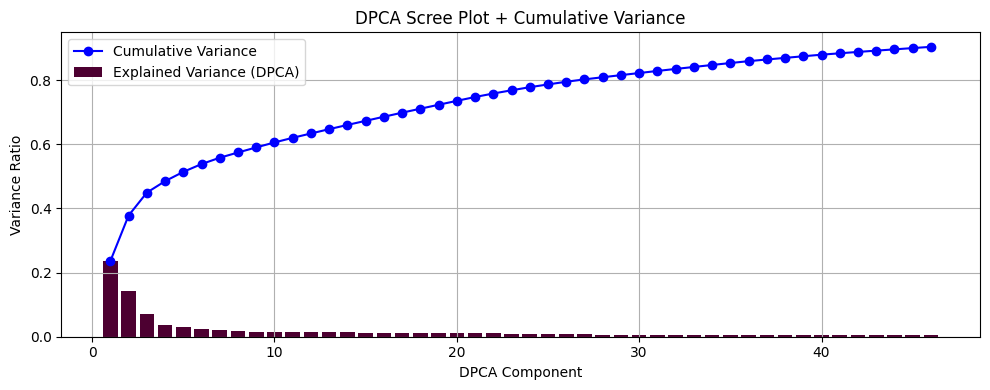

In [426]:
# Find DPCA PCA model
if "pca_dpca" not in globals():
    pca_dpca = None
    for name, obj in globals().items():
        if "dpca" in name.lower() and hasattr(obj, "explained_variance_ratio_"):
            pca_dpca = obj
            print(f"Using {name} as DPCA model.")
            break
    if pca_dpca is None:
        raise ValueError("No DPCA PCA model found (with explained_variance_ratio_)")
        
explained_dpca = pca_dpca.explained_variance_ratio_
cumvar_dpca = np.cumsum(explained_dpca)
k_dpca = np.arange(1, len(explained_dpca) + 1)

plt.figure(figsize=(10, 4))
plt.bar(k_dpca, explained_dpca, label="Explained Variance (DPCA)", color='#4d0031')
plt.plot(k_dpca, cumvar_dpca, marker="o", color="blue", label="Cumulative Variance")
plt.xlabel("DPCA Component")
plt.ylabel("Variance Ratio")
plt.title("DPCA Scree Plot + Cumulative Variance")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

## 12. Run Across All Fault
In this step, we systematically apply the selected monitoring models to every fault scenario in the dataset, computing detection statistics and performance metrics in a loop. This produces a consistent, comparable set of results across all faults, which can then be summarized in the master detection tables and heatmaps.

In [427]:
df_all = pd.read_csv("data_python_data_3years.txt")

In [428]:
def load_fault_data(fault_id, window=True):
    """
    Returns only the fault segment for the given fault_id.
    If window=True, return rows AFTER the fault first appears.
    """

    df_fault = df_all[df_all["Status"] == fault_id].copy()

    if df_fault.empty:
        print(f"Warning: Fault {fault_id} not found in dataset.")
        return None
        
    df_fault.reset_index(drop=True, inplace=True)

    return df_fault

In [429]:
def load_fault_window(fault_id, before=2000, after=5000):
    """
    Returns a window centered around the first appearance of fault.
    before: number of samples before fault onset
    after: number of samples after fault onset
    """
    idx_start = df_all.index[df_all["Status"] == fault_id][0]

    start = max(0, idx_start - before)
    end = idx_start + after

    return df_all.iloc[start:end].reset_index(drop=True)

In [430]:
fault_ids = [f for f in range(1, 22) if f != 2]

In [431]:
def load_fault_data(fault_id):
    df = pd.read_csv(f"/mnt/data/TEP/fault_{fault_id}.csv")
    return df

In [432]:
def run_detection(df_fault, models):
    results = {}

    # PCA
    T2_pca, Q_pca = compute_pca_stats(df_fault, models["pca"])
    results["PCA"] = evaluate_detection(T2_pca, Q_pca)
    # DPCA
    T2_dpca, Q_dpca = compute_dpca_stats(df_fault, models["dpca"])
    results["DPCA"] = evaluate_detection(T2_dpca, Q_dpca)
    # CVA
    T2_cva, Q_cva = compute_cva_stats(df_fault, models["cva"])
    results["CVA"] = evaluate_detection(T2_cva, Q_cva)
    # CVDA
    D_index = compute_cvda_stats(df_fault, models["cvda"])
    results["CVDA"] = evaluate_cvda_detection(D_index)

    return results

In [433]:
def run_diagnosis(df_fault, models):
    diagnosis = {}

    diagnosis["PCA_Q_contrib"] = compute_q_contribution(df_fault, models["pca"])
    diagnosis["DPCA_Q_contrib"] = compute_q_contribution_dpca(df_fault, models["dpca"])
    diagnosis["CVA_contrib"] = compute_cva_contribution(df_fault, models["cva"])
    diagnosis["CVDA_contrib"] = compute_cvda_contribution(df_fault, models["cvda"])

    return diagnosis

In [434]:
def run_prognosis(df_fault, models):
    prognosis = {}

    # DPCA Q progression
    _, dpca_Q = compute_dpca_stats(df_fault, models["dpca"])
    prognosis["DPCA_Q_trend"] = detect_trend(dpca_Q)

    # CVDA D-index progression
    D_index = compute_cvda_stats(df_fault, models["cvda"])
    prognosis["CVDA_trend"] = detect_trend(D_index)

    return prognosis

In [435]:
def detect_trend(series):
    slope = np.polyfit(range(len(series)), series, 1)[0]
    if slope > 0.001:
        return "Increasing"
    elif slope < -0.001:
        return "Decreasing"
    else:
        return "Stable"

In [436]:
import os

def save_plot(fig, folder, filename):
    os.makedirs(folder, exist_ok=True)
    fig.savefig(os.path.join(folder, filename), dpi=200)


In [437]:
def detection_delay(sequence, limit):
    """
    Return the index of the first sample that exceeds 'limit'.
    If no sample exceeds the limit, return None.
    """
    idx = np.where(sequence > limit)[0]
    return None if len(idx) == 0 else int(idx[0])


def get_pca_stats(X, pca_model, eigenvalues):
    """
    Compute PCA scores, residuals, and T²/Q statistics
    for a given dataset X and PCA model.
    """
    T, E = compute_pca_scores_and_residuals(X, pca_model)
    T2 = compute_T2(T, eigenvalues)
    Q = compute_Q(E)
    return T, E, T2, Q


def evaluate_detection(T2, Q, T2_limit, Q_limit):
    """
    Compute detection rate and detection delay for T² and Q
    given their control limits.
    """
    det_T2 = float((T2 > T2_limit).mean())
    det_Q = float((Q > Q_limit).mean())

    delay_T2 = detection_delay(T2, T2_limit) if det_T2 > 0 else None
    delay_Q = detection_delay(Q, Q_limit) if det_Q > 0 else None

    return {
        "T2_DetectionRate": det_T2,
        "Q_DetectionRate": det_Q,
        "T2_DetectionDelay": delay_T2,
        "Q_DetectionDelay": delay_Q,
    }


def compute_q_contribution(E, top_k=10):
    """
    Compute average Q (SPE) contribution per variable across time.

    Parameters
    ----------
    E : pandas.DataFrame
        Residuals (X - X_reconstructed) with the same columns as X.
    top_k : int
        Number of top contributing variables to return.

    Returns
    -------
    contrib_sorted : pandas.Series
        Top-k mean squared residuals per variable, sorted descending.
    """
    # Each variable's contribution to Q is its squared residual
    sq = E ** 2
    mean_contrib = sq.mean(axis=0)
    contrib_sorted = mean_contrib.sort_values(ascending=False)
    return contrib_sorted.head(top_k)


def classify_trend(values, frac=0.2, ratio_thresh=0.2):
    """
    Classify a series as Increasing / Decreasing / Stable
    based on the change between early and late segments.

    Parameters
    ----------
    values : array-like
        Statistic over time (e.g., DPCA Q or D-index).
    frac : float
        Fraction of samples to use at the start and end.
    ratio_thresh : float
        Threshold for relative change (±20% default).

    Returns
    -------
    label : str
        "Increasing", "Decreasing", or "Stable".
    """
    arr = np.asarray(values)
    n = arr.size
    if n < 10:
        return "Insufficient data"

    k = max(int(n * frac), 1)
    start_mean = arr[:k].mean()
    end_mean = arr[-k:].mean()

    if start_mean == 0:
        return "Stable"

    rel_change = (end_mean - start_mean) / abs(start_mean)

    if rel_change > ratio_thresh:
        return "Increasing"
    if rel_change < -ratio_thresh:
        return "Decreasing"
    return "Stable"

def run_fault_pipeline(
    fault_id,
    top_k=10,
    plot_detection=True,
    plot_diagnosis=True,
    plot_prognosis=True,
):
    """
    Run Fault Detection, Diagnosis, and Prognosis for a single fault.

    Uses:
    - Static PCA (pca, eigvals, T2_lim_final, Q_lim_final)
    - Dynamic PCA / Takens-PCA (pca_dpca, eigvals_dpca, T2_lim_dpca, Q_lim_dpca)
    - Data: X_faulty_std[fault_id], X_faulty_dpca[fault_id]

    Returns
    -------
    result : dict
        {
          "fault_id": ...,
          "PCA": {detection dict, contributions},
          "DPCA": {detection dict, contributions, trend},
        }
    """

    Xf_std = X_faulty_std[fault_id]
    Xf_dpca = X_faulty_dpca[fault_id]

    T_pca, E_pca, T2_pca, Q_pca = get_pca_stats(Xf_std, pca, eigvals)
    det_pca = evaluate_detection(T2_pca, Q_pca, T2_lim_final, Q_lim_final)
    T_dpca, E_dpca, T2_dpca, Q_dpca = get_pca_stats(
        Xf_dpca, pca_dpca, eigvals_dpca
    )
    det_dpca = evaluate_detection(T2_dpca, Q_dpca, T2_lim_dpca, Q_lim_dpca)
    q_contrib_pca = compute_q_contribution(E_pca, top_k=top_k)
    q_contrib_dpca = compute_q_contribution(E_dpca, top_k=top_k)
    trend_dpca_Q = classify_trend(Q_dpca)
    if plot_detection:
        fig, axes = plt.subplots(2, 2, figsize=(14, 8), sharex=False)

        # PCA T² and Q
        axes[0, 0].plot(T2_pca, label=f"Fault {fault_id} – PCA T²")
        axes[0, 0].axhline(T2_lim_final, linestyle="--", color="red",
                           label="T² limit")
        axes[0, 0].set_title(f"Fault {fault_id} – PCA T² Chart")
        axes[0, 0].set_xlabel("Sample index")
        axes[0, 0].set_ylabel("T²")
        axes[0, 0].legend()

        axes[0, 1].plot(Q_pca, label=f"Fault {fault_id} – PCA Q")
        axes[0, 1].axhline(Q_lim_final, linestyle="--", color="red",
                           label="Q limit")
        axes[0, 1].set_title(f"Fault {fault_id} – PCA Q Chart")
        axes[0, 1].set_xlabel("Sample index")
        axes[0, 1].set_ylabel("Q (SPE)")
        axes[0, 1].legend()

        # DPCA T² and Q
        axes[1, 0].plot(T2_dpca, label=f"Fault {fault_id} – DPCA T²")
        axes[1, 0].axhline(T2_lim_dpca, linestyle="--", color="red",
                           label="T² limit")
        axes[1, 0].set_title(f"Fault {fault_id} – DPCA T² Chart")
        axes[1, 0].set_xlabel("Sample index")
        axes[1, 0].set_ylabel("T²")
        axes[1, 0].legend()

        axes[1, 1].plot(Q_dpca, label=f"Fault {fault_id} – DPCA Q")
        axes[1, 1].axhline(Q_lim_dpca, linestyle="--", color="red",
                           label="Q limit")
        axes[1, 1].set_title(f"Fault {fault_id} – DPCA Q Chart")
        axes[1, 1].set_xlabel("Sample index")
        axes[1, 1].set_ylabel("Q (SPE)")
        axes[1, 1].legend()

        plt.tight_layout()
        plt.show()

    if plot_diagnosis:
        fig, axes = plt.subplots(1, 2, figsize=(14, 4))

        q_contrib_pca.sort_values(ascending=True).plot(
            kind="barh", ax=axes[0]
        )
        axes[0].set_title(f"Fault {fault_id} – PCA Q-Contribution (Top {top_k})")
        axes[0].set_xlabel("Mean Q Contribution")

        q_contrib_dpca.sort_values(ascending=True).plot(
            kind="barh", ax=axes[1]
        )
        axes[1].set_title(f"Fault {fault_id} – DPCA Q-Contribution (Top {top_k})")
        axes[1].set_xlabel("Mean Q Contribution")

        plt.tight_layout()
        plt.show()

    if plot_prognosis:
        plt.figure(figsize=(12, 4))
        plt.plot(Q_dpca, label=f"Fault {fault_id} – DPCA Q")
        plt.axhline(Q_lim_dpca, linestyle="--", color="red", label="Q limit")
        plt.yscale("log")
        plt.title(
            f"Fault {fault_id} – DPCA Q Progression "
            f"(Trend: {trend_dpca_Q})"
        )
        plt.xlabel("Sample index")
        plt.ylabel("Q (SPE, log scale)")
        plt.legend()
        plt.tight_layout()
        plt.show()
    result = {
        "fault_id": fault_id,
        "PCA": {
            "detection": det_pca,
            "top_Q_contributors": q_contrib_pca,
        },
        "DPCA": {
            "detection": det_dpca,
            "top_Q_contributors": q_contrib_dpca,
            "Q_trend": trend_dpca_Q,
        },
    }

    return result

all_fault_ids = sorted(X_faulty_std.keys())
fault_ids_to_run = [fid for fid in all_fault_ids if fid != 2]

all_results = []

for fid in fault_ids_to_run:
    print(f"\n===== Running pipeline for Fault {fid} =====")
    res = run_fault_pipeline(
        fault_id=fid,
        top_k=10,
        plot_detection=False,   
        plot_diagnosis=False,   
        plot_prognosis=False,
    )
    all_results.append(res)
summary_rows = []
for r in all_results:
    fid = r["fault_id"]

    pca_det = r["PCA"]["detection"]
    dpca_det = r["DPCA"]["detection"]

    summary_rows.append({
        "Fault": fid,
        "PCA_T2_DR": pca_det["T2_DetectionRate"],
        "PCA_T2_Delay": pca_det["T2_DetectionDelay"],
        "PCA_Q_DR": pca_det["Q_DetectionRate"],
        "PCA_Q_Delay": pca_det["Q_DetectionDelay"],
        "DPCA_T2_DR": dpca_det["T2_DetectionRate"],
        "DPCA_T2_Delay": dpca_det["T2_DetectionDelay"],
        "DPCA_Q_DR": dpca_det["Q_DetectionRate"],
        "DPCA_Q_Delay": dpca_det["Q_DetectionDelay"],
        "DPCA_Q_trend": r["DPCA"]["Q_trend"],
    })

df_summary = pd.DataFrame(summary_rows).sort_values("Fault").reset_index(drop=True)
df_summary


===== Running pipeline for Fault 1 =====

===== Running pipeline for Fault 3 =====

===== Running pipeline for Fault 4 =====

===== Running pipeline for Fault 5 =====

===== Running pipeline for Fault 6 =====

===== Running pipeline for Fault 7 =====

===== Running pipeline for Fault 8 =====

===== Running pipeline for Fault 9 =====

===== Running pipeline for Fault 10 =====

===== Running pipeline for Fault 11 =====

===== Running pipeline for Fault 12 =====

===== Running pipeline for Fault 13 =====

===== Running pipeline for Fault 14 =====

===== Running pipeline for Fault 15 =====

===== Running pipeline for Fault 16 =====

===== Running pipeline for Fault 17 =====

===== Running pipeline for Fault 18 =====

===== Running pipeline for Fault 19 =====

===== Running pipeline for Fault 20 =====


Fault  PCA_T2_DR  PCA_T2_Delay  PCA_Q_DR  PCA_Q_Delay  DPCA_T2_DR  \
0       1   0.018378          50.0  0.971368         18.0    0.947381   
1       3   0.000000           NaN  0.000000          NaN    0.000000   
2       4   0.000000           NaN  0.025593         87.0    0.000000   
3       5   0.000000           NaN  0.000000          NaN    0.000000   
4       6   0.360061          48.0  0.981089          2.0    0.435606   
5       7   0.219995          10.0  0.007478          3.0    0.997670   
6       8   0.017543          85.0  0.043919         55.0    0.041391   
7       9   0.000000           NaN  0.000000          NaN    0.000000   
8      10   0.000000           NaN  0.000000          NaN    0.000000   
9      11   0.002114         146.0  0.188537          6.0    0.019922   
10     12   0.002301          20.0  0.166858         11.0    0.008074   
11     13   0.031192         116.0  0.425122         35.0    0.251761   
12     14   0.531157           1.0  0.610895          3.0    0.748971   
13     15   0.000000           NaN  0.000000          NaN    0.000000   
14     16   0.000000           NaN  0.000000          NaN    0.000000   
15     17   0.373086          81.0  0.436525         79.0    0.435458   
16     18   0.047478         162.0  0.094955        152.0    0.073340   
17     19   0.000000           NaN  0.000136       5813.0    0.000000   
18     20   0.000000           NaN  0.087455         91.0    0.000000   

    DPCA_T2_Delay  DPCA_Q_DR  DPCA_Q_Delay DPCA_Q_trend  
0            25.0   0.784553            12       Stable  
1             NaN   0.000282          1448       Stable  
2             NaN   1.000000             0       Stable  
3             NaN   0.003528           504       Stable  
4            44.0   1.000000             0       Stable  
5             1.0   0.996812             0       Stable  
6            83.0   0.034781            74       Stable  
7             NaN   0.000574          5437       Stable  
8             NaN   0.000791          1449       Stable  
9            27.0   0.602374             3       Stable  
10           19.0   0.432526             9   Decreasing  
11           43.0   0.376468            31       Stable  
12            0.0   0.742485             0       Stable  
13            NaN   0.000359          4572       Stable  
14            NaN   0.001039           594       Stable  
15           79.0   0.168890            92       Stable  
16          154.0   0.093162           156       Stable  
17            NaN   0.001088           460       Stable  
18            NaN   0.239442            79       Stable

In [438]:

def detection_delay(sequence, limit):
    """
    Return the index of the first sample that exceeds 'limit'.
    If no sample exceeds the limit, return None.
    """
    seq = np.asarray(sequence)
    idx = np.where(seq > limit)[0]
    return None if len(idx) == 0 else int(idx[0])


def get_pca_stats(X, pca_model, eigenvalues):
    """
    Compute PCA scores, residuals, and T²/Q statistics
    for a given dataset X and PCA model.

    Assumes you already have:
    - compute_pca_scores_and_residuals(X, model) -> (T, E)
    - compute_T2(T, eigenvalues)
    - compute_Q(E)
    """
    T, E = compute_pca_scores_and_residuals(X, pca_model)
    T2 = compute_T2(T, eigenvalues)
    Q = compute_Q(E)
    return T, E, T2, Q


def evaluate_detection(T2, Q, T2_limit, Q_limit):
    """
    Compute detection rate and detection delay for T² and Q
    given their control limits.
    """
    T2 = np.asarray(T2)
    Q = np.asarray(Q)

    det_T2 = float((T2 > T2_limit).mean())
    det_Q = float((Q > Q_limit).mean())

    delay_T2 = detection_delay(T2, T2_limit) if det_T2 > 0 else None
    delay_Q = detection_delay(Q, Q_limit) if det_Q > 0 else None

    return {
        "T2_DetectionRate": det_T2,
        "Q_DetectionRate": det_Q,
        "T2_DetectionDelay": delay_T2,
        "Q_DetectionDelay": delay_Q,
    }


def evaluate_single_stat(stat, limit):
    """
    Generic detection metrics for a single statistic (e.g., D-index).

    Returns:
    - DetectionRate: fraction of samples above limit
    - DetectionDelay: index of first exceedance (or None)
    """
    stat = np.asarray(stat)
    det_rate = float((stat > limit).mean())
    det_delay = detection_delay(stat, limit) if det_rate > 0 else None
    return {"DetectionRate": det_rate, "DetectionDelay": det_delay}


def compute_q_contribution(E, top_k=10):
    """
    Compute average Q (SPE) contribution per variable across time.

    Parameters
    ----------
    E : pandas.DataFrame
        Residuals (X - X_reconstructed) with the same columns as X.
    top_k : int
        Number of top contributing variables to return.

    Returns
    -------
    contrib_sorted : pandas.Series
        Top-k mean squared residuals per variable, sorted descending.
    """
    sq = E ** 2
    mean_contrib = sq.mean(axis=0)
    contrib_sorted = mean_contrib.sort_values(ascending=False)
    return contrib_sorted.head(top_k)


def classify_trend(values, frac=0.2, ratio_thresh=0.2):
    """
    Classify a series as Increasing / Decreasing / Stable
    based on change between early and late segments.

    Parameters
    ----------
    values : array-like
        Statistic over time (e.g., DPCA Q or D-index).
    frac : float
        Fraction of samples to use at the start and end.
    ratio_thresh : float
        Threshold for relative change (±20% default).

    Returns
    -------
    label : str
        "Increasing", "Decreasing", or "Stable".
    """
    arr = np.asarray(values)
    n = arr.size
    if n < 10:
        return "Insufficient data"

    k = max(int(n * frac), 1)
    start_mean = arr[:k].mean()
    end_mean = arr[-k:].mean()

    if start_mean == 0:
        return "Stable"

    rel_change = (end_mean - start_mean) / abs(start_mean)

    if rel_change > ratio_thresh:
        return "Increasing"
    if rel_change < -ratio_thresh:
        return "Decreasing"
    return "Stable"


In [439]:
def run_fault_pipeline(
    fault_id,
    top_k=10,
    plot_detection=True,
    plot_diagnosis=True,
    plot_prognosis=True,
):
    """
    Run Fault Detection, Diagnosis, and Prognosis for a single fault.

    Uses:
    - Static PCA:
        X_faulty_std[fault_id], pca, eigvals,
        T2_lim_final, Q_lim_final
    - Dynamic PCA / Takens-PCA:
        X_faulty_dpca[fault_id], pca_dpca, eigvals_dpca,
        T2_lim_dpca, Q_lim_dpca
    - CVA:
        T2_cva_dict[fault_id], Q_cva_dict[fault_id],
        T2_lim_cva, Q_lim_cva
    - CVDA:
        Dindex_dict[fault_id], D_limit

    Returns
    -------
    result : dict
        {
          "fault_id": ...,
          "PCA": {...},
          "DPCA": {...},
          "CVA": {...},
          "CVDA": {...},
        }
    """

    Xf_std = X_faulty_std[fault_id]
    Xf_dpca = X_faulty_dpca[fault_id]

    T_pca, E_pca, T2_pca, Q_pca = get_pca_stats(Xf_std, pca, eigvals)
    det_pca = evaluate_detection(T2_pca, Q_pca, T2_lim_final, Q_lim_final)

    T_dpca, E_dpca, T2_dpca, Q_dpca = get_pca_stats(
        Xf_dpca, pca_dpca, eigvals_dpca
    )
    det_dpca = evaluate_detection(T2_dpca, Q_dpca, T2_lim_dpca, Q_lim_dpca)

    if fault_id in T2_cva_dict and fault_id in Q_cva_dict:
        T2_cva = np.asarray(T2_cva_dict[fault_id])
        Q_cva = np.asarray(Q_cva_dict[fault_id])
        det_cva = evaluate_detection(T2_cva, Q_cva, T2_lim_cva, Q_lim_cva)
    else:
        T2_cva = None
        Q_cva = None
        det_cva = None

    if fault_id in Dindex_dict:
        D_idx = np.asarray(Dindex_dict[fault_id])
        det_cvda = evaluate_single_stat(D_idx, D_limit)
        trend_cvda = classify_trend(D_idx)
    else:
        D_idx = None
        det_cvda = None
        trend_cvda = None

    q_contrib_pca = compute_q_contribution(E_pca, top_k=top_k)
    q_contrib_dpca = compute_q_contribution(E_dpca, top_k=top_k)

 
    cva_contrib = None
    cvda_contrib = None

    trend_dpca_Q = classify_trend(Q_dpca)
    trend_cva_Q = classify_trend(Q_cva) if Q_cva is not None else None

    if plot_detection:
        fig, axes = plt.subplots(2, 2, figsize=(14, 8))
        # PCA T²
        axes[0, 0].plot(T2_pca, label=f"Fault {fault_id} – PCA T²")
        axes[0, 0].axhline(T2_lim_final, linestyle="--", color="red",
                           label="T² limit")
        axes[0, 0].set_title(f"Fault {fault_id} – PCA T² Chart")
        axes[0, 0].set_xlabel("Sample index")
        axes[0, 0].set_ylabel("T²")
        axes[0, 0].legend()

        axes[0, 1].plot(T2_dpca, label=f"Fault {fault_id} – DPCA T²")
        axes[0, 1].axhline(T2_lim_dpca, linestyle="--", color="red",
                           label="T² limit")
        axes[0, 1].set_title(f"Fault {fault_id} – DPCA T² Chart")
        axes[0, 1].set_xlabel("Sample index")
        axes[0, 1].set_ylabel("T²")
        axes[0, 1].legend()

        # CVA T² (if available)
        if T2_cva is not None:
            axes[1, 0].plot(T2_cva, label=f"Fault {fault_id} – CVA T²")
            axes[1, 0].axhline(T2_lim_cva, linestyle="--", color="red",
                               label="T² limit")
            axes[1, 0].set_title(f"Fault {fault_id} – CVA T² Chart")
            axes[1, 0].set_xlabel("Sample index")
            axes[1, 0].set_ylabel("T²")
            axes[1, 0].legend()
        else:
            axes[1, 0].text(0.5, 0.5, "No CVA data",
                            ha="center", va="center")
            axes[1, 0].set_axis_off()

        if D_idx is not None:
            axes[1, 1].plot(D_idx, label=f"Fault {fault_id} – D-index")
            axes[1, 1].axhline(D_limit, linestyle="--", color="red",
                               label="D limit")
            axes[1, 1].set_title(f"Fault {fault_id} – CVDA D-index")
            axes[1, 1].set_xlabel("Sample index")
            axes[1, 1].set_ylabel("D-index")
            axes[1, 1].legend()
        else:
            axes[1, 1].text(0.5, 0.5, "No CVDA data",
                            ha="center", va="center")
            axes[1, 1].set_axis_off()

        plt.tight_layout()
        plt.show()

    if plot_diagnosis:
        fig, axes = plt.subplots(1, 2, figsize=(14, 4))

        q_contrib_pca.sort_values(ascending=True).plot(
            kind="barh", ax=axes[0]
        )
        axes[0].set_title(f"Fault {fault_id} – PCA Q-Contribution (Top {top_k})")
        axes[0].set_xlabel("Mean Q Contribution")

        q_contrib_dpca.sort_values(ascending=True).plot(
            kind="barh", ax=axes[1]
        )
        axes[1].set_title(f"Fault {fault_id} – DPCA Q-Contribution (Top {top_k})")
        axes[1].set_xlabel("Mean Q Contribution")

        plt.tight_layout()
        plt.show()

    if plot_prognosis:
        # DPCA Q progression
        plt.figure(figsize=(12, 4))
        plt.plot(Q_dpca, label=f"Fault {fault_id} – DPCA Q")
        plt.axhline(Q_lim_dpca, linestyle="--", color="red", label="Q limit")
        plt.yscale("log")
        plt.title(
            f"Fault {fault_id} – DPCA Q Progression "
            f"(Trend: {trend_dpca_Q})"
        )
        plt.xlabel("Sample index")
        plt.ylabel("Q (SPE, log scale)")
        plt.legend()
        plt.tight_layout()
        plt.show()

        # CVDA D progression (if available)
        if D_idx is not None:
            plt.figure(figsize=(12, 4))
            plt.plot(D_idx, label=f"Fault {fault_id} – D-index")
            plt.axhline(D_limit, linestyle="--", color="red", label="D limit")
            plt.yscale("log")
            plt.title(
                f"Fault {fault_id} – CVDA D-index Progression "
                f"(Trend: {trend_cvda})"
            )
            plt.xlabel("Sample index")
            plt.ylabel("D-index (log scale)")
            plt.legend()
            plt.tight_layout()
            plt.show()

    result = {
        "fault_id": fault_id,
        "PCA": {
            "detection": det_pca,
            "top_Q_contributors": q_contrib_pca,
        },
        "DPCA": {
            "detection": det_dpca,
            "top_Q_contributors": q_contrib_dpca,
            "Q_trend": trend_dpca_Q,
        },
        "CVA": {
            "detection": det_cva,
            "Q_trend": trend_cva_Q,
        },
        "CVDA": {
            "detection": det_cvda,
            "D_trend": trend_cvda,
        },
    }

    return result


In [440]:
[v for v in dir() if "cva" in v.lower()]


['CVA_Q_contrib',
 'CVA_Q_series',
 'E_f_cva',
 'E_train_cva',
 'Q_f_cva',
 'Q_fault3_cva',
 'Q_lim_cva',
 'Q_test_cva',
 'Q_train_cva',
 'T2_f_cva',
 'T2_fault3_cva',
 'T2_lim_cva',
 'T2_test_cva',
 'T2_train_cva',
 'Z_fault_cva',
 'Z_train_cva',
 'compute_cva_states',
 'cva_det',
 'cva_model',
 'cva_project',
 'cva_results',
 'fa_Q_cva',
 'fa_T2_cva',
 'time_idx_fault_cva',
 'top_cva']

In [441]:
def dpca_top_contributors(E_dpca, top_k=10):
    """
    Returns the top-k DPCA Q-contributing variables.

    Parameters
    ----------
    E_dpca : pandas.DataFrame
        DPCA residual matrix for one fault (after Takens embedding).
        Columns should be variable names (possibly with lag suffixes).
    top_k : int
        Number of top contributors to return.

    Returns
    -------
    contrib_sorted : pandas.Series
        Sorted mean squared residuals (descending), top_k only.
    """

    # Q contributions 
    sq = E_dpca ** 2

    # Mean contribution per variable across time
    mean_contrib = sq.mean(axis=0)

    # Sort highest 
    contrib_sorted = mean_contrib.sort_values(ascending=False)

    return contrib_sorted.head(top_k)

In [442]:
X_faulty_dpca[fault_id] 
pca_dpca            
eigvals_dpca             

array([36.74656955, 22.16616369, 11.14284417,  5.57585693,  4.51914226,
        3.8026258 ,  3.07519217,  2.5530351 ,  2.46534472,  2.42224329,
        2.24619211,  2.10998247,  2.09828669,  2.05378614,  1.99621537,
        1.98733323,  1.97560691,  1.92839735,  1.91778883,  1.90697443,
        1.87242823,  1.69695036,  1.56436515,  1.50639123,  1.34510535,
        1.30337043,  1.15116374,  1.03477156,  1.02926264,  1.02083079,
        1.01799738,  0.97272961,  0.96450576,  0.96045041,  0.95014367,
        0.9091246 ,  0.80726167,  0.7886167 ,  0.78429267,  0.76657933,
        0.67895786,  0.66618896,  0.62535019,  0.62069437,  0.61797088,
        0.61273087])

In [443]:
dpca_contrib_all = {}

for fid in sorted(X_faulty_dpca.keys()):
    if fid == 2:   # skip Fault 2 if needed
        continue
    
    print(f"\n=== DPCA Diagnosis for Fault {fid} ===")
    
    # Compute DPCA stats
    T_dpca, E_dpca, T2_dpca, Q_dpca = get_pca_stats(
        X_faulty_dpca[fid], pca_dpca, eigvals_dpca
    )
    
    # Top 10 contributing variables
    top10 = dpca_top_contributors(E_dpca, top_k=10)
    
    dpca_contrib_all[fid] = top10
    print(top10)


=== DPCA Diagnosis for Fault 1 ===
XMEAS(23)_lag2    7.866658
XMEAS(38)_lag2    1.528235
XMEAS(38)_lag1    1.288547
XMEAS(38)         1.156048
XMEAS(27)_lag1    0.885022
XMV(3)            0.743883
XMEAS(27)_lag2    0.730146
XMV(3)_lag2       0.729254
XMEAS(1)          0.715098
XMEAS(1)_lag2     0.698695
dtype: float64

=== DPCA Diagnosis for Fault 3 ===
XMV(1)_lag1      0.350811
XMEAS(2)_lag1    0.347454
XMEAS(2)_lag2    0.340036
XMV(1)_lag2      0.329948
XMEAS(8)_lag2    0.298704
XMEAS(8)_lag1    0.298446
XMEAS(8)         0.298272
XMEAS(36)        0.287996
XMV(1)           0.287242
XMEAS(2)         0.286273
dtype: float64

=== DPCA Diagnosis for Fault 4 ===
XMV(10)_lag1      17.159337
XMV(10)_lag2      11.978209
XMV(10)           11.485396
XMEAS(21)          3.497225
XMEAS(21)_lag1     3.443745
XMEAS(21)_lag2     3.291804
XMEAS(9)_lag2      0.958964
XMEAS(9)           0.670806
XMV(1)_lag2        0.558774
XMEAS(2)_lag2      0.544018
dtype: float64

=== DPCA Diagnosis for Fault 5 ===
X

In [444]:
# Create summary list
dpca_rows = []

for fid in sorted(X_faulty_dpca.keys()):
    if fid == 2:  
        continue

    # Compute DPCA stats
    T_dpca, E_dpca, T2_dpca, Q_dpca = get_pca_stats(
        X_faulty_dpca[fid], pca_dpca, eigvals_dpca
    )

    # Top 10 contributors
    top10 = dpca_top_contributors(E_dpca, top_k=10)

    # Convert to table rows
    for rank, (var, contrib) in enumerate(top10.items(), start=1):
        dpca_rows.append({
            "Fault": fid,
            "Rank": rank,
            "Variable": var,
            "Mean_Q_Contribution": contrib
        })

# Convert to DataFrame
df_dpca_table = pd.DataFrame(dpca_rows)

df_dpca_table

Fault  Rank        Variable  Mean_Q_Contribution
0        1     1  XMEAS(23)_lag2             7.866658
1        1     2  XMEAS(38)_lag2             1.528235
2        1     3  XMEAS(38)_lag1             1.288547
3        1     4       XMEAS(38)             1.156048
4        1     5  XMEAS(27)_lag1             0.885022
..     ...   ...             ...                  ...
185     20     6       XMEAS(11)             0.532121
186     20     7       XMEAS(23)             0.530035
187     20     8  XMEAS(20)_lag2             0.479030
188     20     9  XMEAS(23)_lag1             0.446816
189     20    10       XMEAS(27)             0.410124

[190 rows x 4 columns]

In [445]:
def dpca_top3(E_dpca):
    """
    Return top 3 contributing variables as a python list.
    """
    sq = E_dpca ** 2                         
    mean_contrib = sq.mean(axis=0)           
    top3 = mean_contrib.sort_values(ascending=False).head(3)
    return list(top3.index)

In [446]:
dpca_top3_dict = {}

for fid in sorted(X_faulty_dpca.keys()):
    if fid == 2:  
        continue

    # Get DPCA stats
    T_dpca, E_dpca, T2_dpca, Q_dpca = get_pca_stats(
        X_faulty_dpca[fid],
        pca_dpca,
        eigvals_dpca
    )

    # Compute top 3 variables
    top3 = dpca_top3(E_dpca)
    dpca_top3_dict[fid] = top3


In [447]:
df_dpca_top3 = pd.DataFrame({
    "Fault": list(dpca_top3_dict.keys()),
    "DPCA_Top3": [", ".join(v) for v in dpca_top3_dict.values()]
})


In [448]:
df_summary   


Fault  PCA_T2_DR  PCA_T2_Delay  PCA_Q_DR  PCA_Q_Delay  DPCA_T2_DR  \
0       1   0.018378          50.0  0.971368         18.0    0.947381   
1       3   0.000000           NaN  0.000000          NaN    0.000000   
2       4   0.000000           NaN  0.025593         87.0    0.000000   
3       5   0.000000           NaN  0.000000          NaN    0.000000   
4       6   0.360061          48.0  0.981089          2.0    0.435606   
5       7   0.219995          10.0  0.007478          3.0    0.997670   
6       8   0.017543          85.0  0.043919         55.0    0.041391   
7       9   0.000000           NaN  0.000000          NaN    0.000000   
8      10   0.000000           NaN  0.000000          NaN    0.000000   
9      11   0.002114         146.0  0.188537          6.0    0.019922   
10     12   0.002301          20.0  0.166858         11.0    0.008074   
11     13   0.031192         116.0  0.425122         35.0    0.251761   
12     14   0.531157           1.0  0.610895          3.0    0.748971   
13     15   0.000000           NaN  0.000000          NaN    0.000000   
14     16   0.000000           NaN  0.000000          NaN    0.000000   
15     17   0.373086          81.0  0.436525         79.0    0.435458   
16     18   0.047478         162.0  0.094955        152.0    0.073340   
17     19   0.000000           NaN  0.000136       5813.0    0.000000   
18     20   0.000000           NaN  0.087455         91.0    0.000000   

    DPCA_T2_Delay  DPCA_Q_DR  DPCA_Q_Delay DPCA_Q_trend  
0            25.0   0.784553            12       Stable  
1             NaN   0.000282          1448       Stable  
2             NaN   1.000000             0       Stable  
3             NaN   0.003528           504       Stable  
4            44.0   1.000000             0       Stable  
5             1.0   0.996812             0       Stable  
6            83.0   0.034781            74       Stable  
7             NaN   0.000574          5437       Stable  
8             NaN   0.000791          1449       Stable  
9            27.0   0.602374             3       Stable  
10           19.0   0.432526             9   Decreasing  
11           43.0   0.376468            31       Stable  
12            0.0   0.742485             0       Stable  
13            NaN   0.000359          4572       Stable  
14            NaN   0.001039           594       Stable  
15           79.0   0.168890            92       Stable  
16          154.0   0.093162           156       Stable  
17            NaN   0.001088           460       Stable  
18            NaN   0.239442            79       Stable

In [449]:
df_final = (
    df_summary
    .merge(df_dpca_top3, on="Fault", how="left")
    .sort_values("Fault")
    .reset_index(drop=True)
)


In [450]:
df_final

Fault  PCA_T2_DR  PCA_T2_Delay  PCA_Q_DR  PCA_Q_Delay  DPCA_T2_DR  \
0       1   0.018378          50.0  0.971368         18.0    0.947381   
1       3   0.000000           NaN  0.000000          NaN    0.000000   
2       4   0.000000           NaN  0.025593         87.0    0.000000   
3       5   0.000000           NaN  0.000000          NaN    0.000000   
4       6   0.360061          48.0  0.981089          2.0    0.435606   
5       7   0.219995          10.0  0.007478          3.0    0.997670   
6       8   0.017543          85.0  0.043919         55.0    0.041391   
7       9   0.000000           NaN  0.000000          NaN    0.000000   
8      10   0.000000           NaN  0.000000          NaN    0.000000   
9      11   0.002114         146.0  0.188537          6.0    0.019922   
10     12   0.002301          20.0  0.166858         11.0    0.008074   
11     13   0.031192         116.0  0.425122         35.0    0.251761   
12     14   0.531157           1.0  0.610895          3.0    0.748971   
13     15   0.000000           NaN  0.000000          NaN    0.000000   
14     16   0.000000           NaN  0.000000          NaN    0.000000   
15     17   0.373086          81.0  0.436525         79.0    0.435458   
16     18   0.047478         162.0  0.094955        152.0    0.073340   
17     19   0.000000           NaN  0.000136       5813.0    0.000000   
18     20   0.000000           NaN  0.087455         91.0    0.000000   

    DPCA_T2_Delay  DPCA_Q_DR  DPCA_Q_Delay DPCA_Q_trend  \
0            25.0   0.784553            12       Stable   
1             NaN   0.000282          1448       Stable   
2             NaN   1.000000             0       Stable   
3             NaN   0.003528           504       Stable   
4            44.0   1.000000             0       Stable   
5             1.0   0.996812             0       Stable   
6            83.0   0.034781            74       Stable   
7             NaN   0.000574          5437       Stable   
8             NaN   0.000791          1449       Stable   
9            27.0   0.602374             3       Stable   
10           19.0   0.432526             9   Decreasing   
11           43.0   0.376468            31       Stable   
12            0.0   0.742485             0       Stable   
13            NaN   0.000359          4572       Stable   
14            NaN   0.001039           594       Stable   
15           79.0   0.168890            92       Stable   
16          154.0   0.093162           156       Stable   
17            NaN   0.001088           460       Stable   
18            NaN   0.239442            79       Stable   

                                         DPCA_Top3  
0   XMEAS(23)_lag2, XMEAS(38)_lag2, XMEAS(38)_lag1  
1        XMV(1)_lag1, XMEAS(2)_lag1, XMEAS(2)_lag2  
2              XMV(10)_lag1, XMV(10)_lag2, XMV(10)  
3              XMV(11)_lag1, XMV(11)_lag2, XMV(11)  
4               XMV(3)_lag2, XMV(3)_lag1, XMEAS(1)  
5     XMEAS(27)_lag2, XMEAS(8)_lag2, XMEAS(8)_lag1  
6          XMEAS(23)_lag2, XMEAS(8), XMEAS(8)_lag1  
7          XMV(1)_lag1, XMEAS(2)_lag1, XMV(1)_lag2  
8        XMV(1)_lag1, XMEAS(2)_lag1, XMEAS(2)_lag2  
9              XMV(10)_lag1, XMV(10), XMV(10)_lag2  
10       XMEAS(11), XMEAS(11)_lag2, XMEAS(11)_lag1  
11            XMEAS(16), XMEAS(23)_lag2, XMEAS(33)  
12       XMEAS(21)_lag1, XMEAS(21)_lag2, XMEAS(21)  
13       XMEAS(2)_lag1, XMV(1)_lag1, XMEAS(2)_lag2  
14         XMV(1)_lag1, XMEAS(2)_lag1, XMV(1)_lag2  
15       XMEAS(21)_lag2, XMEAS(21), XMEAS(21)_lag1  
16            XMEAS(11), XMEAS(11)_lag1, XMEAS(22)  
17       XMV(1)_lag1, XMEAS(2)_lag1, XMEAS(2)_lag2  
18                XMV(5)_lag2, XMV(5), XMV(5)_lag1